# Analytics

#### Date: 2020/02

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM: SiGeD

##### Semester: 2020/02
##### Professor: Hilmer Neri

##### Members:

- Vitor Leal
- Gabriel Carvalho
- Ezequiel de Oliveira
- Gabriela Guedes
- Davi Marinho da Silva Campos
- João Pedro Alves da Silva Chaves
- Thiago França Vale Oliveira
- Lucas da Cunha Andrade
- Dafne Moretti Moreira
- Victor Yukio Cavalcanti Miki

### LIBRARIES

In [1]:
!pip3 install -r requirements.txt

In [2]:
# Deal with data
import pandas as pd
import numpy as np
import json
from glob import glob
import os

# Deal with API request
import urllib3
from urllib3 import request

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime


### GRAPH SETTINGS

In [3]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [4]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### SonarCloud

##### Path to the folder with all your jsons

In [5]:
jsons = glob('../analytics-raw-data/*.json') # add the path here

In [6]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    aux_df = df['filename'].str.split(r"SiGeD-(.*?)-*-(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [7]:
base_component_df = create_base_component_df(jsons)

In [8]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
531,duplicated_lines_density,3.8,False,fga-eps-mds-2020-2-SiGeD-Clients-04-05-2021_V1...,Clients,04-05-2021_V1.1.1
532,functions,49,NaN,fga-eps-mds-2020-2-SiGeD-Clients-04-05-2021_V1...,Clients,04-05-2021_V1.1.1
533,security_rating,1.0,True,fga-eps-mds-2020-2-SiGeD-Clients-04-05-2021_V1...,Clients,04-05-2021_V1.1.1
534,files,14,NaN,fga-eps-mds-2020-2-SiGeD-Clients-04-05-2021_V1...,Clients,04-05-2021_V1.1.1
535,complexity,77,NaN,fga-eps-mds-2020-2-SiGeD-Clients-04-05-2021_V1...,Clients,04-05-2021_V1.1.1
536,ncloc,701,NaN,fga-eps-mds-2020-2-SiGeD-Clients-04-05-2021_V1...,Clients,04-05-2021_V1.1.1
537,coverage,64.9,False,fga-eps-mds-2020-2-SiGeD-Clients-04-05-2021_V1...,Clients,04-05-2021_V1.1.1
538,reliability_rating,1.0,True,fga-eps-mds-2020-2-SiGeD-Clients-04-05-2021_V1...,Clients,04-05-2021_V1.1.1
539,comment_lines_density,0.3,False,fga-eps-mds-2020-2-SiGeD-Clients-04-05-2021_V1...,Clients,04-05-2021_V1.1.1
378,duplicated_lines_density,0.0,True,fga-eps-mds-2020-2-SiGeD-Clients-16-04-2021_v0...,Clients,16-04-2021_v0.3.2


#### Create dataframe per file

In [9]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'security_rating',
               'tests',
               'test_success_density',
               'test_execution_time',
               'reliability_rating']

len(metric_list)

12

In [10]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = 'js')

        file_component_df['filename'] = os.path.basename(i)

        df = df.append(file_component_df, ignore_index=True)
        
    # replace TeamName by yours.    
    aux_df = df['filename'].str.split(r"SiGeD-(.*?)-(.*?)_(.*?).json", expand=True)
    
    df['repository'] = aux_df[1]
    
    df['version'] = aux_df[2]
    
    df = df.sort_values(by=['repository', 'version'])
        
    return df

In [11]:
file_component_df = create_file_df(jsons)

In [12]:
file_component_df.head(10)

,path,functions,complexity,comment_lines_density,duplicated_lines_density,coverage,ncloc,security_rating,tests,test_success_density,test_execution_time,reliability_rating,filename,repository,version
3642,tests/api.test.js,16,16,0.9,0.0,NaN,223,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-04-05-2021_V1...,Clients,04-05-2021
3643,tests/__mocks__/axios.js,2,4,0.0,0.0,0.0,17,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-04-05-2021_V1...,Clients,04-05-2021
3644,src/Services/Axios/baseService.js,0,0,0.0,0.0,100.0,8,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-04-05-2021_V1...,Clients,04-05-2021
3645,src/Controllers/ClientController.js,8,17,0.0,17.3,82.3,152,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-04-05-2021_V1...,Clients,04-05-2021
3646,src/Models/ClientSchema.js,0,0,0.0,0.0,100.0,75,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-04-05-2021_V1...,Clients,04-05-2021
3647,scripts/consts.js,0,0,0.0,0.0,0.0,9,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-04-05-2021_V1...,Clients,04-05-2021
3648,src/Utils/functionsJWS.js,2,4,0.0,0.0,NaN,16,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-04-05-2021_V1...,Clients,04-05-2021
3649,src/index.js,3,3,0.0,0.0,94.1,28,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-04-05-2021_V1...,Clients,04-05-2021
3650,scripts/release.js,7,8,0.0,0.0,0.0,60,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-04-05-2021_V1...,Clients,04-05-2021
3651,src/routes.js,0,0,0.0,0.0,100.0,11,1.0,NaN,100.0,NaN,1.0,fga-eps-mds-2020-2-SiGeD-Clients-04-05-2021_V1...,Clients,04-05-2021


In [14]:
# file_component_df.to_excel('data.xlsx', index = False)

#### Create dataframe per repository

In [15]:
# Example

clients_df = file_component_df[file_component_df['repository'] == 'Clients']
demands_df = file_component_df[file_component_df['repository'] == 'Demands']
frontend_df = file_component_df[file_component_df['repository'] == 'Frontend']
sectors_df = file_component_df[file_component_df['repository'] == 'Sectors']
users_df = file_component_df[file_component_df['repository'] == 'Users']

### Metric calculations

##### COMPLEXITY

In [16]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [17]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [18]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

In [19]:
def get_ncloc(df):
    sum = 0
    for item in df['ncloc']:
        value = int(item)
        sum += value
    ncloc = sum/len(df)
    return ncloc

### Calculate m1, m2 and m3 for each repository

In [20]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    repository_list = []
    version_list = []
    ncloc_list = []
    
    metrics_df = pd.DataFrame()
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        ncloc_list.append(get_ncloc(version_df))
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list
                              })
        
    return metrics_df

In [21]:
users_metrics = create_metrics_df(users_df)
sectors_metrics = create_metrics_df(sectors_df)
frontend_metrics = create_metrics_df(frontend_df)
demands_metrics = create_metrics_df(demands_df)
clients_metrics = create_metrics_df(clients_df)

### Data visualization

- You must do this for each of your repositories

## M1

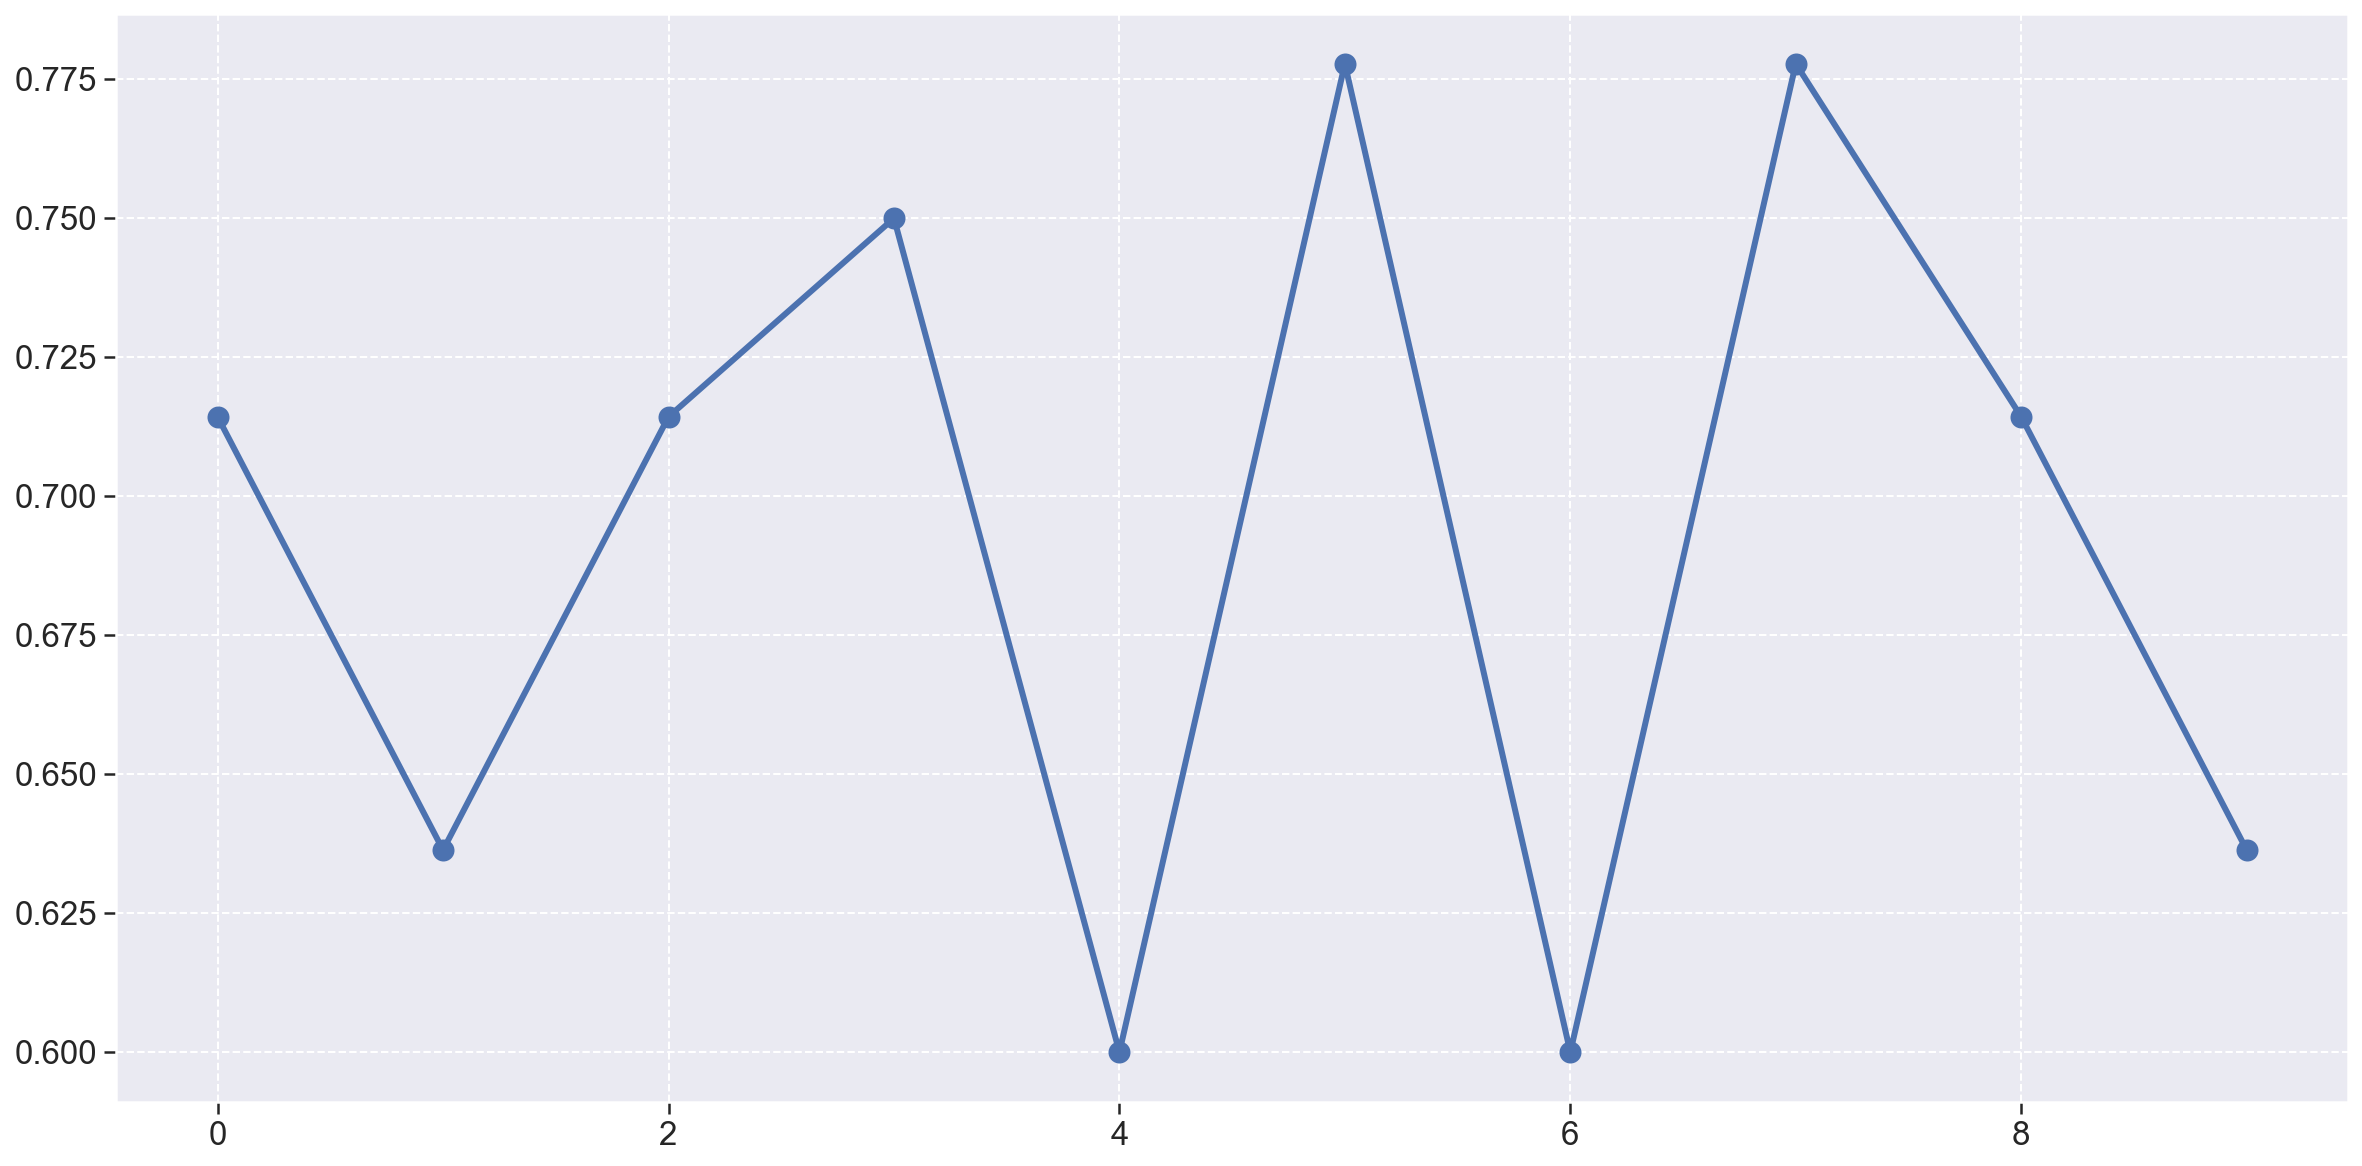

In [22]:
fig = plt.figure(figsize=(20, 10))

plt.plot(users_metrics['m1'], linewidth=3, marker='o', markersize=10)

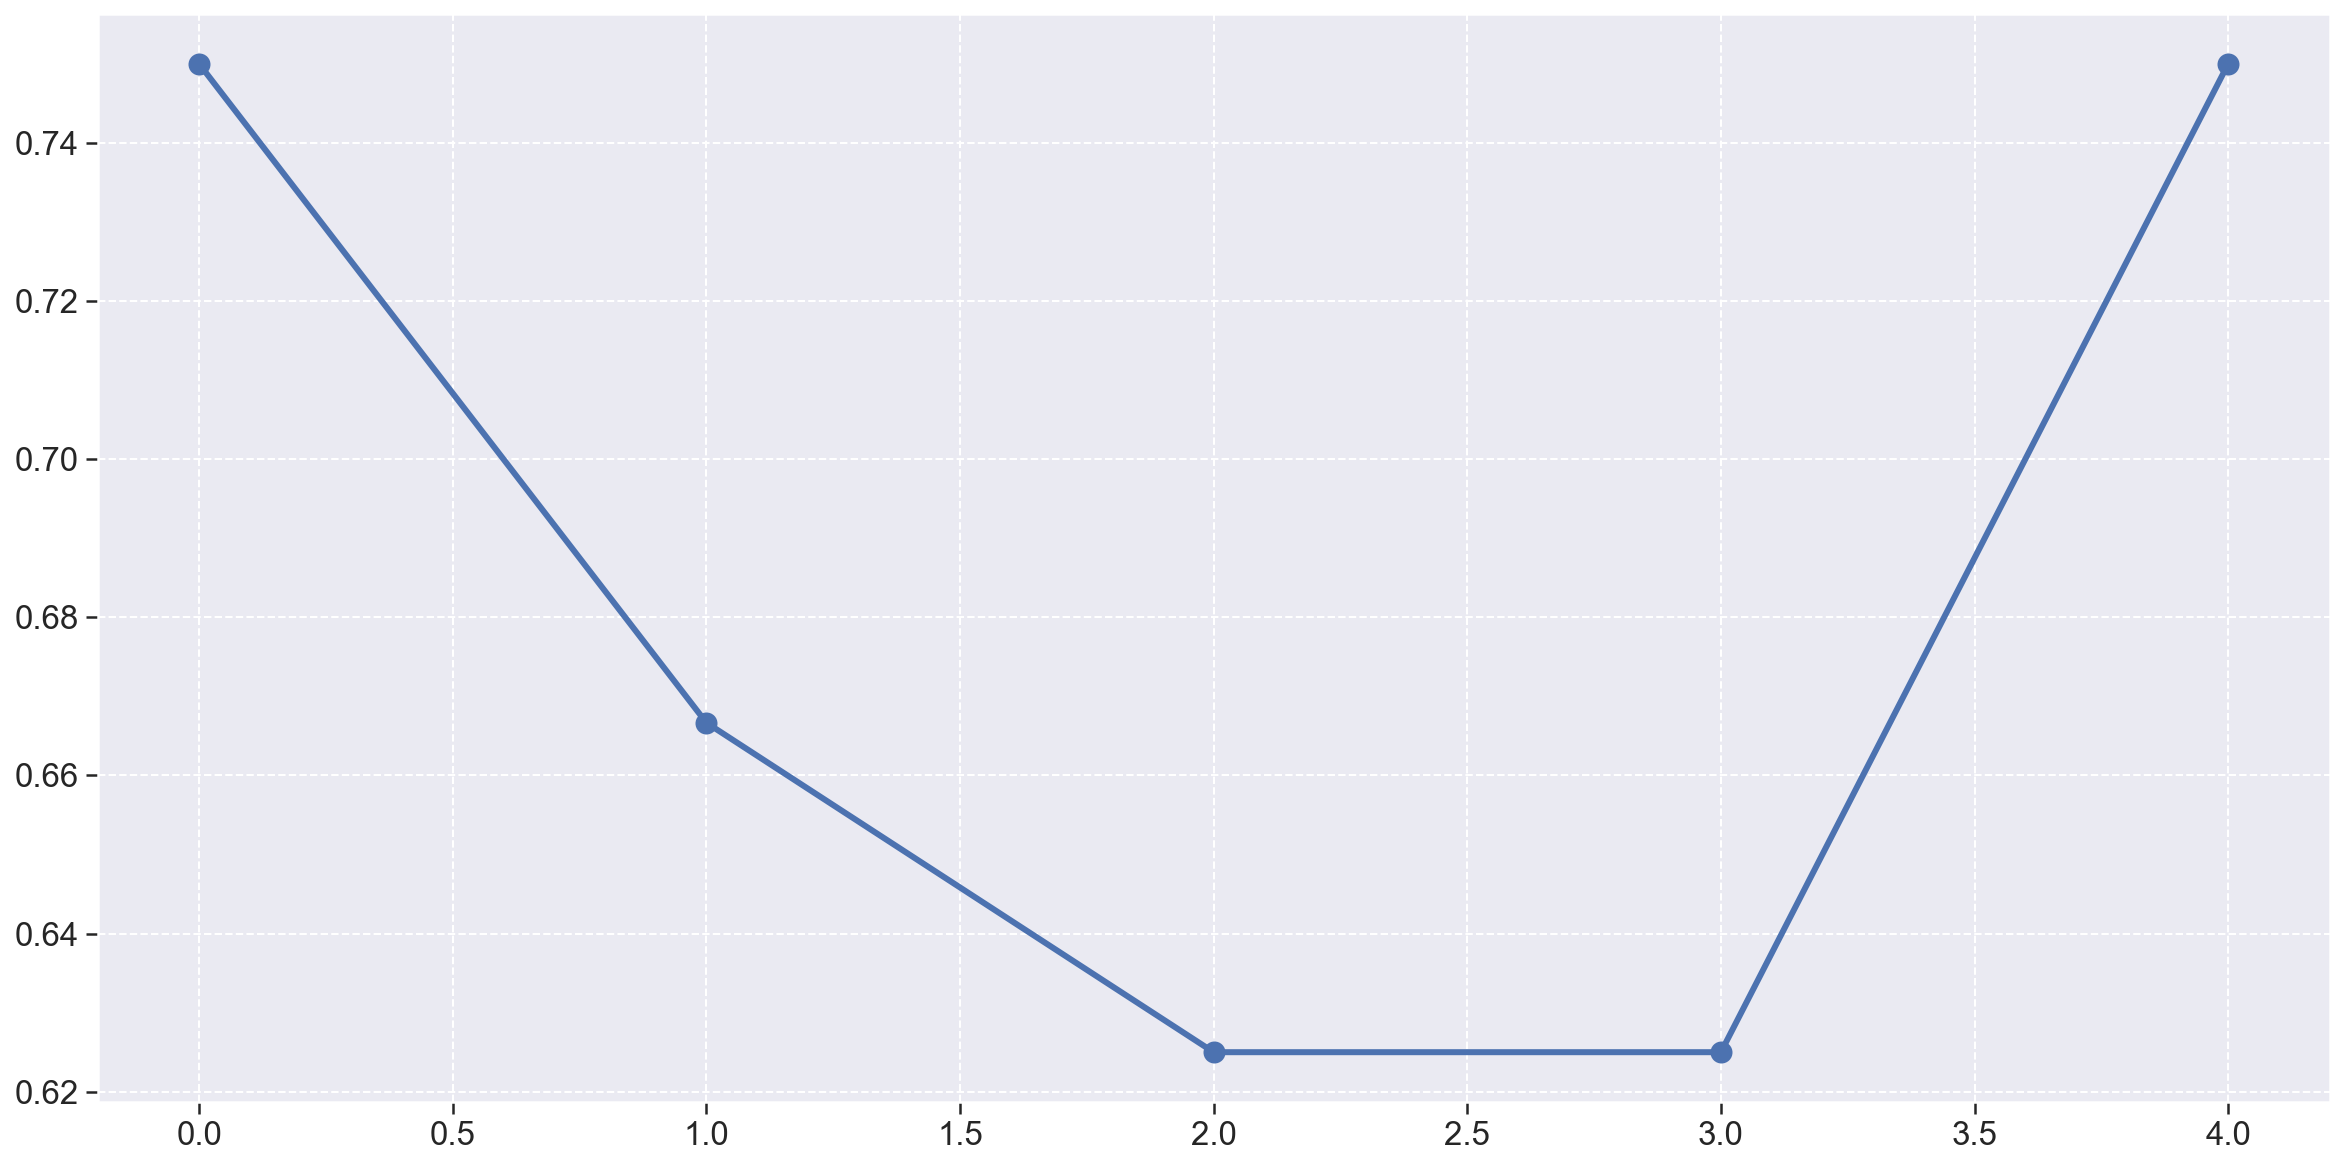

In [23]:
fig = plt.figure(figsize=(20, 10))

plt.plot(sectors_metrics['m1'], linewidth=3, marker='o', markersize=10)

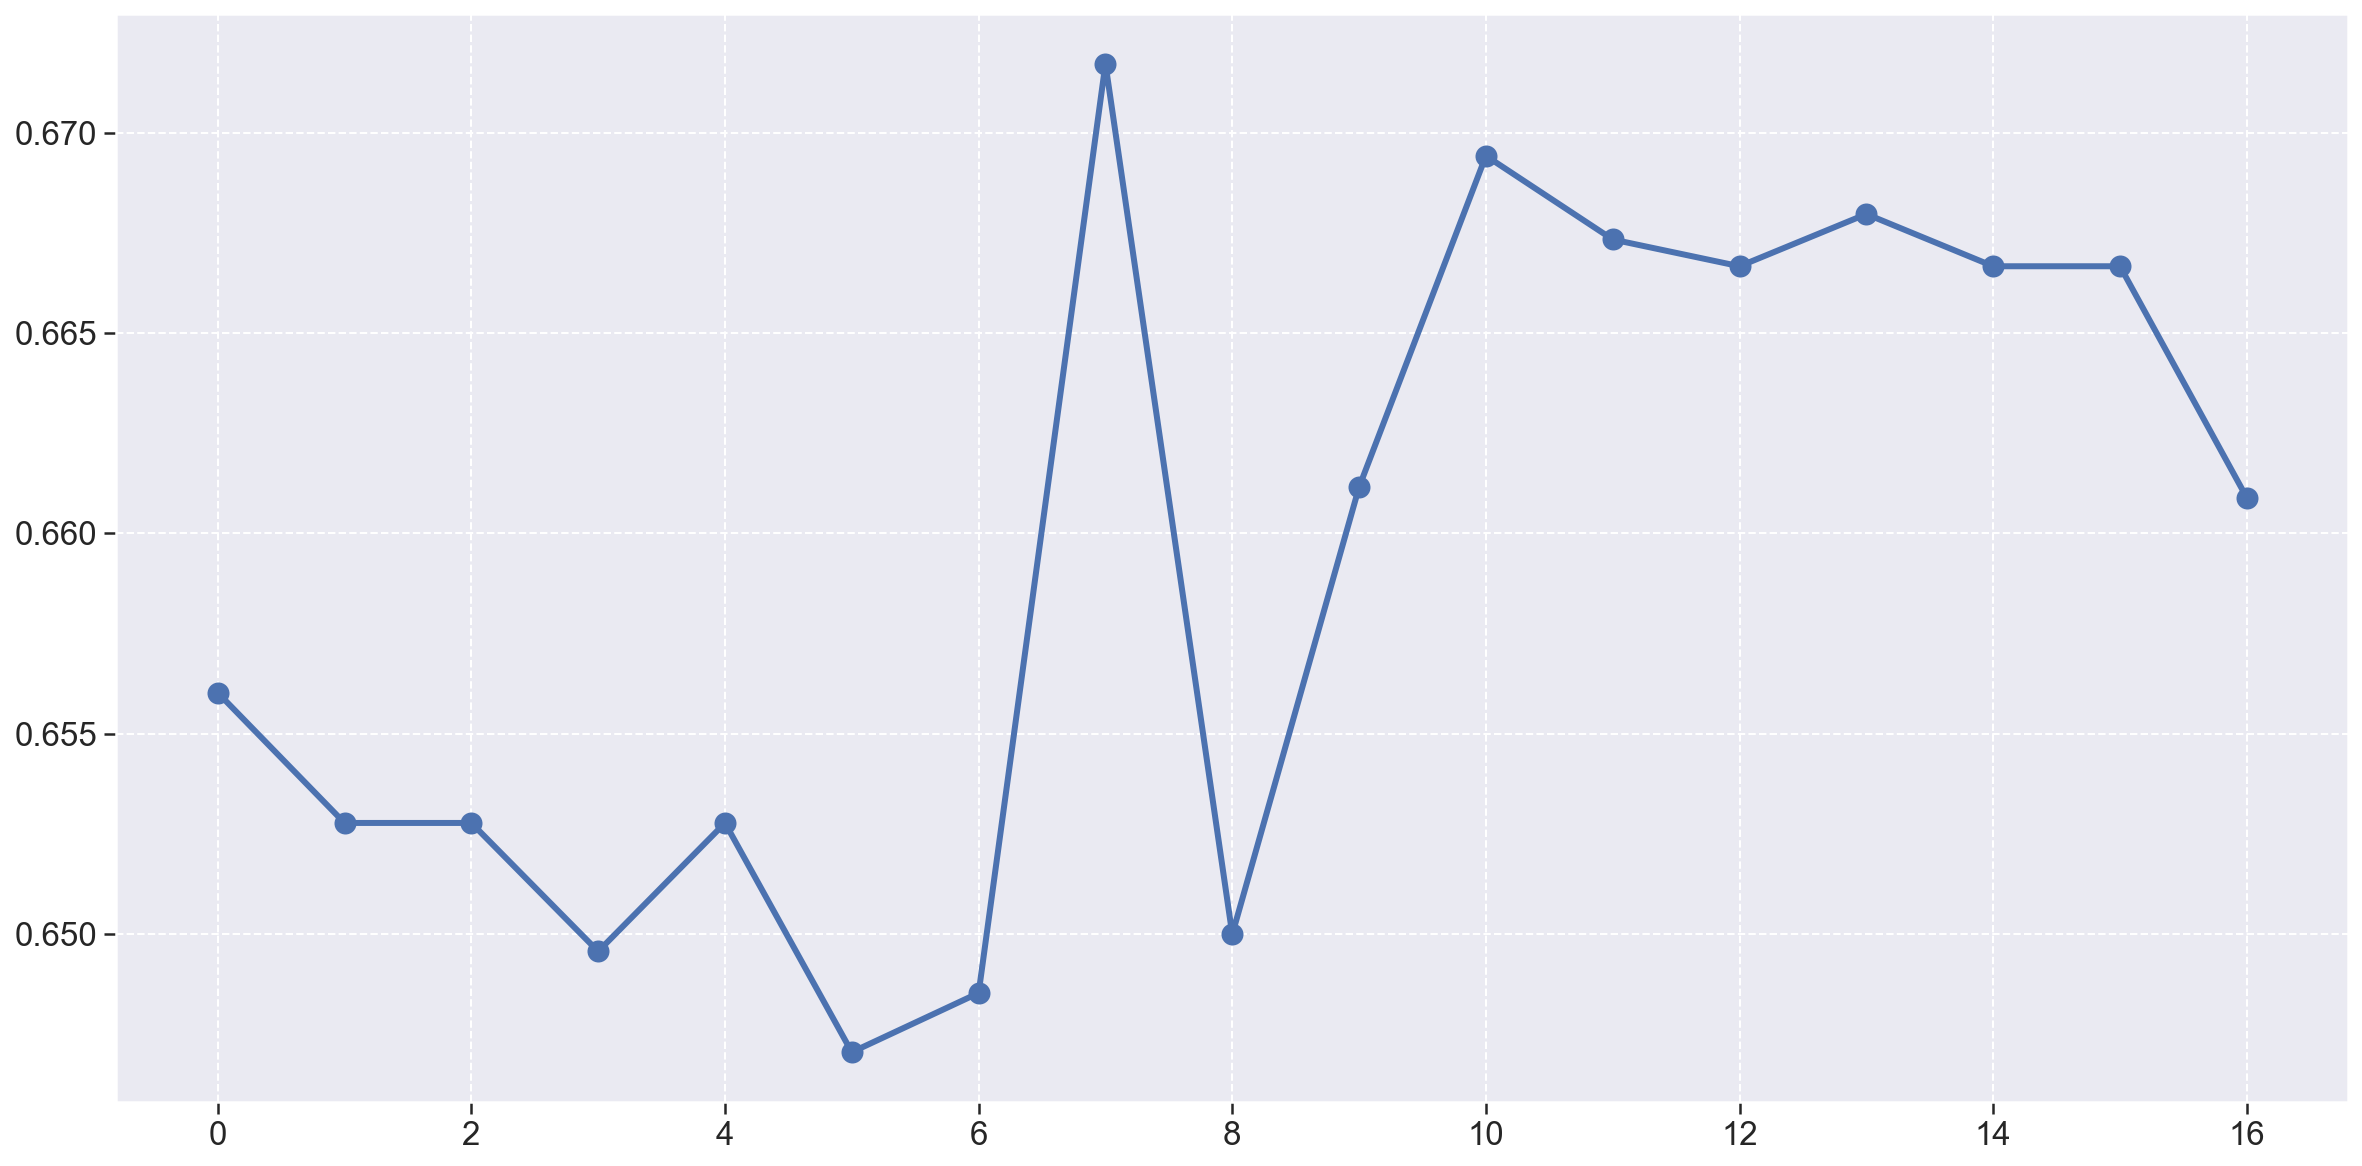

In [24]:
fig = plt.figure(figsize=(20, 10))

plt.plot(frontend_metrics['m1'], linewidth=3, marker='o', markersize=10)

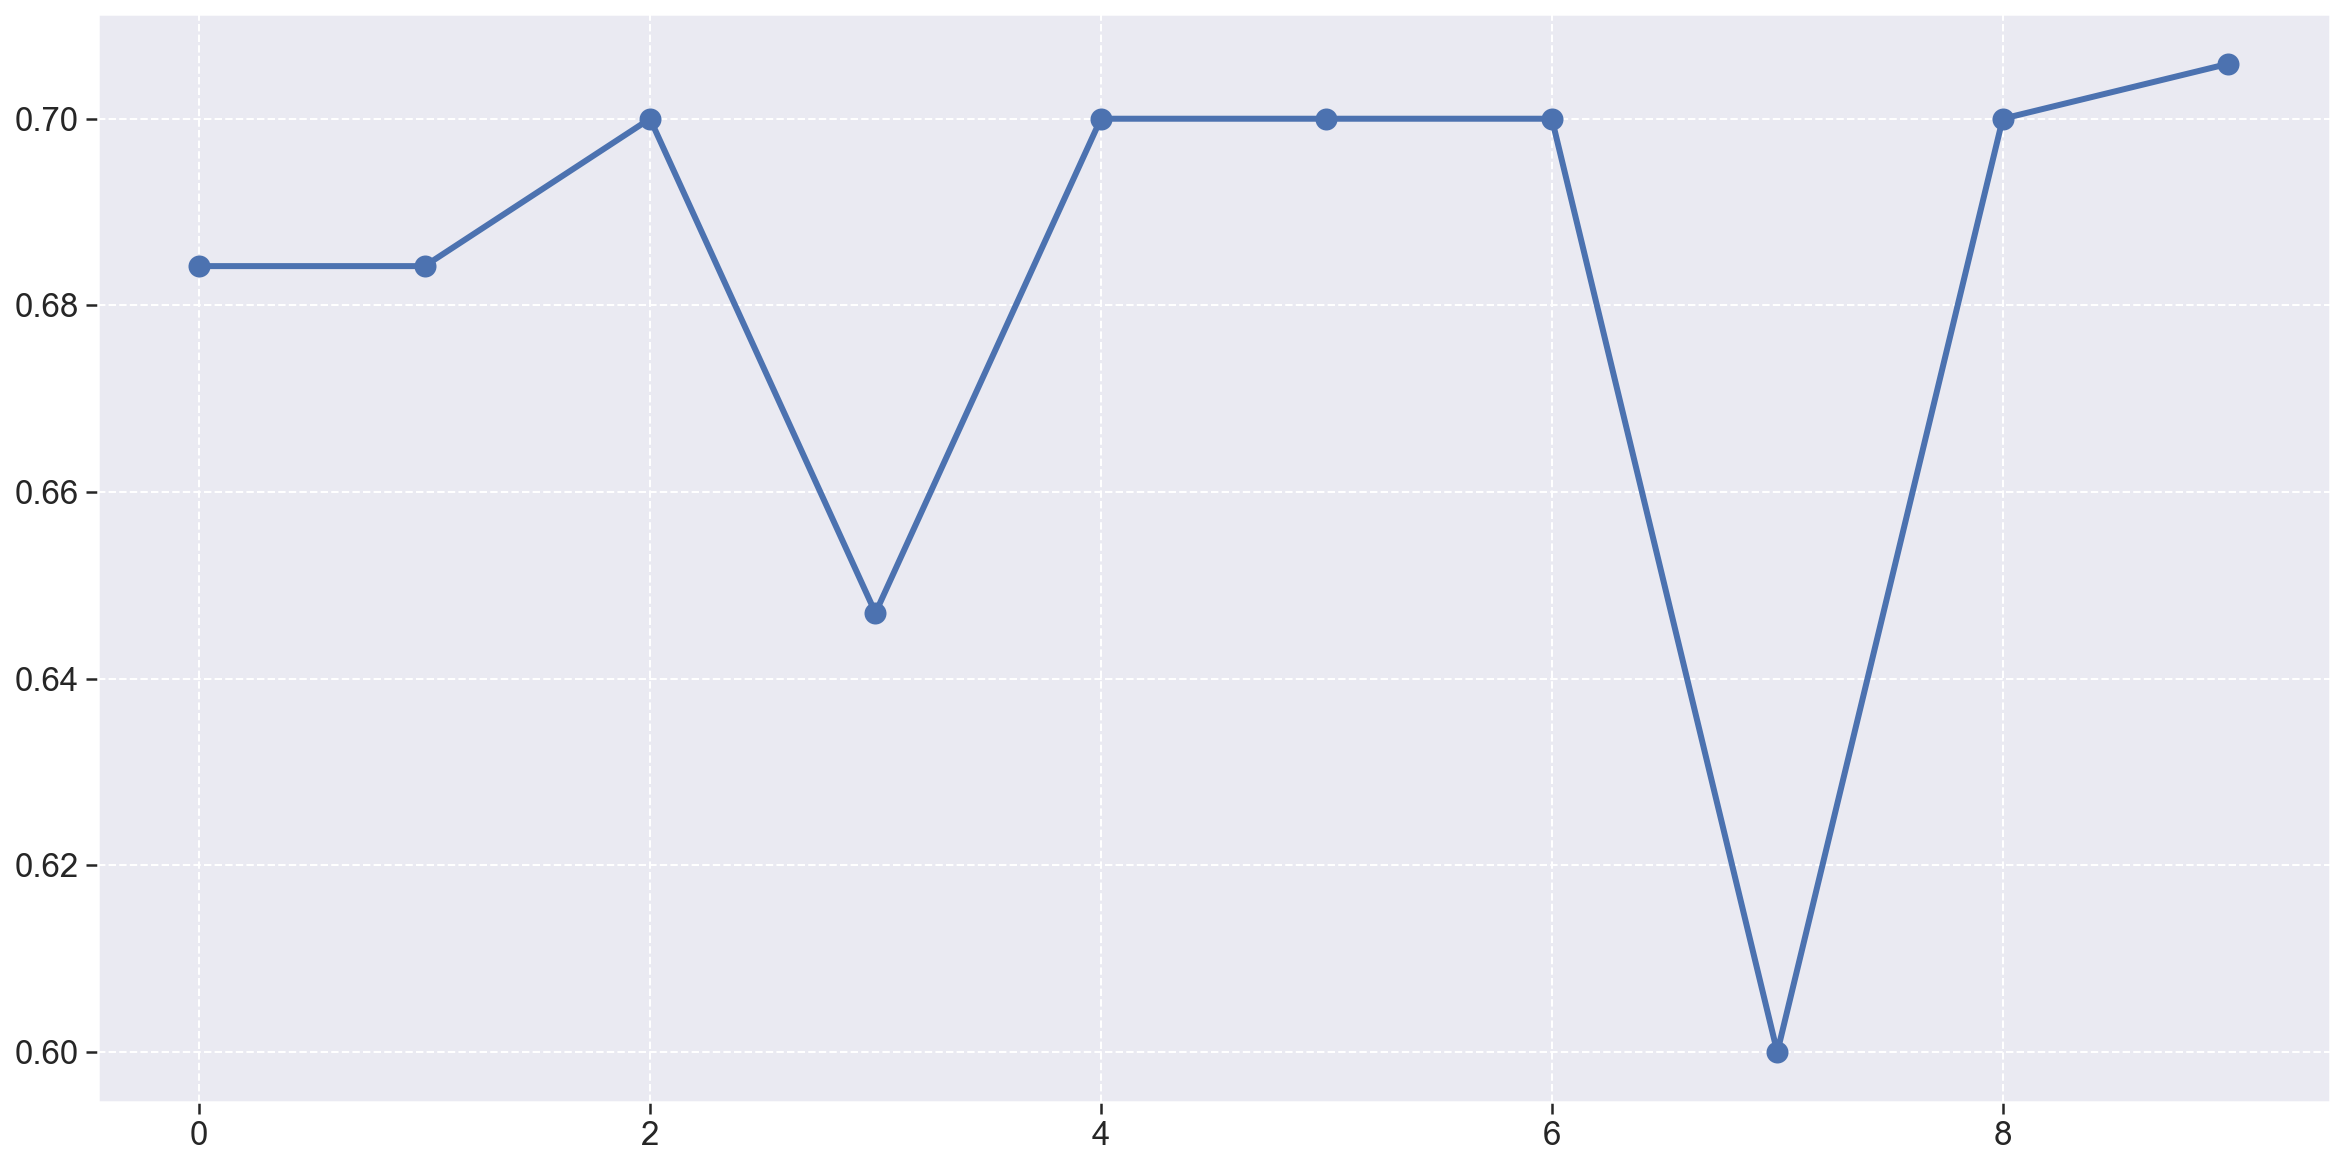

In [25]:
fig = plt.figure(figsize=(20, 10))

plt.plot(demands_metrics['m1'], linewidth=3, marker='o', markersize=10)

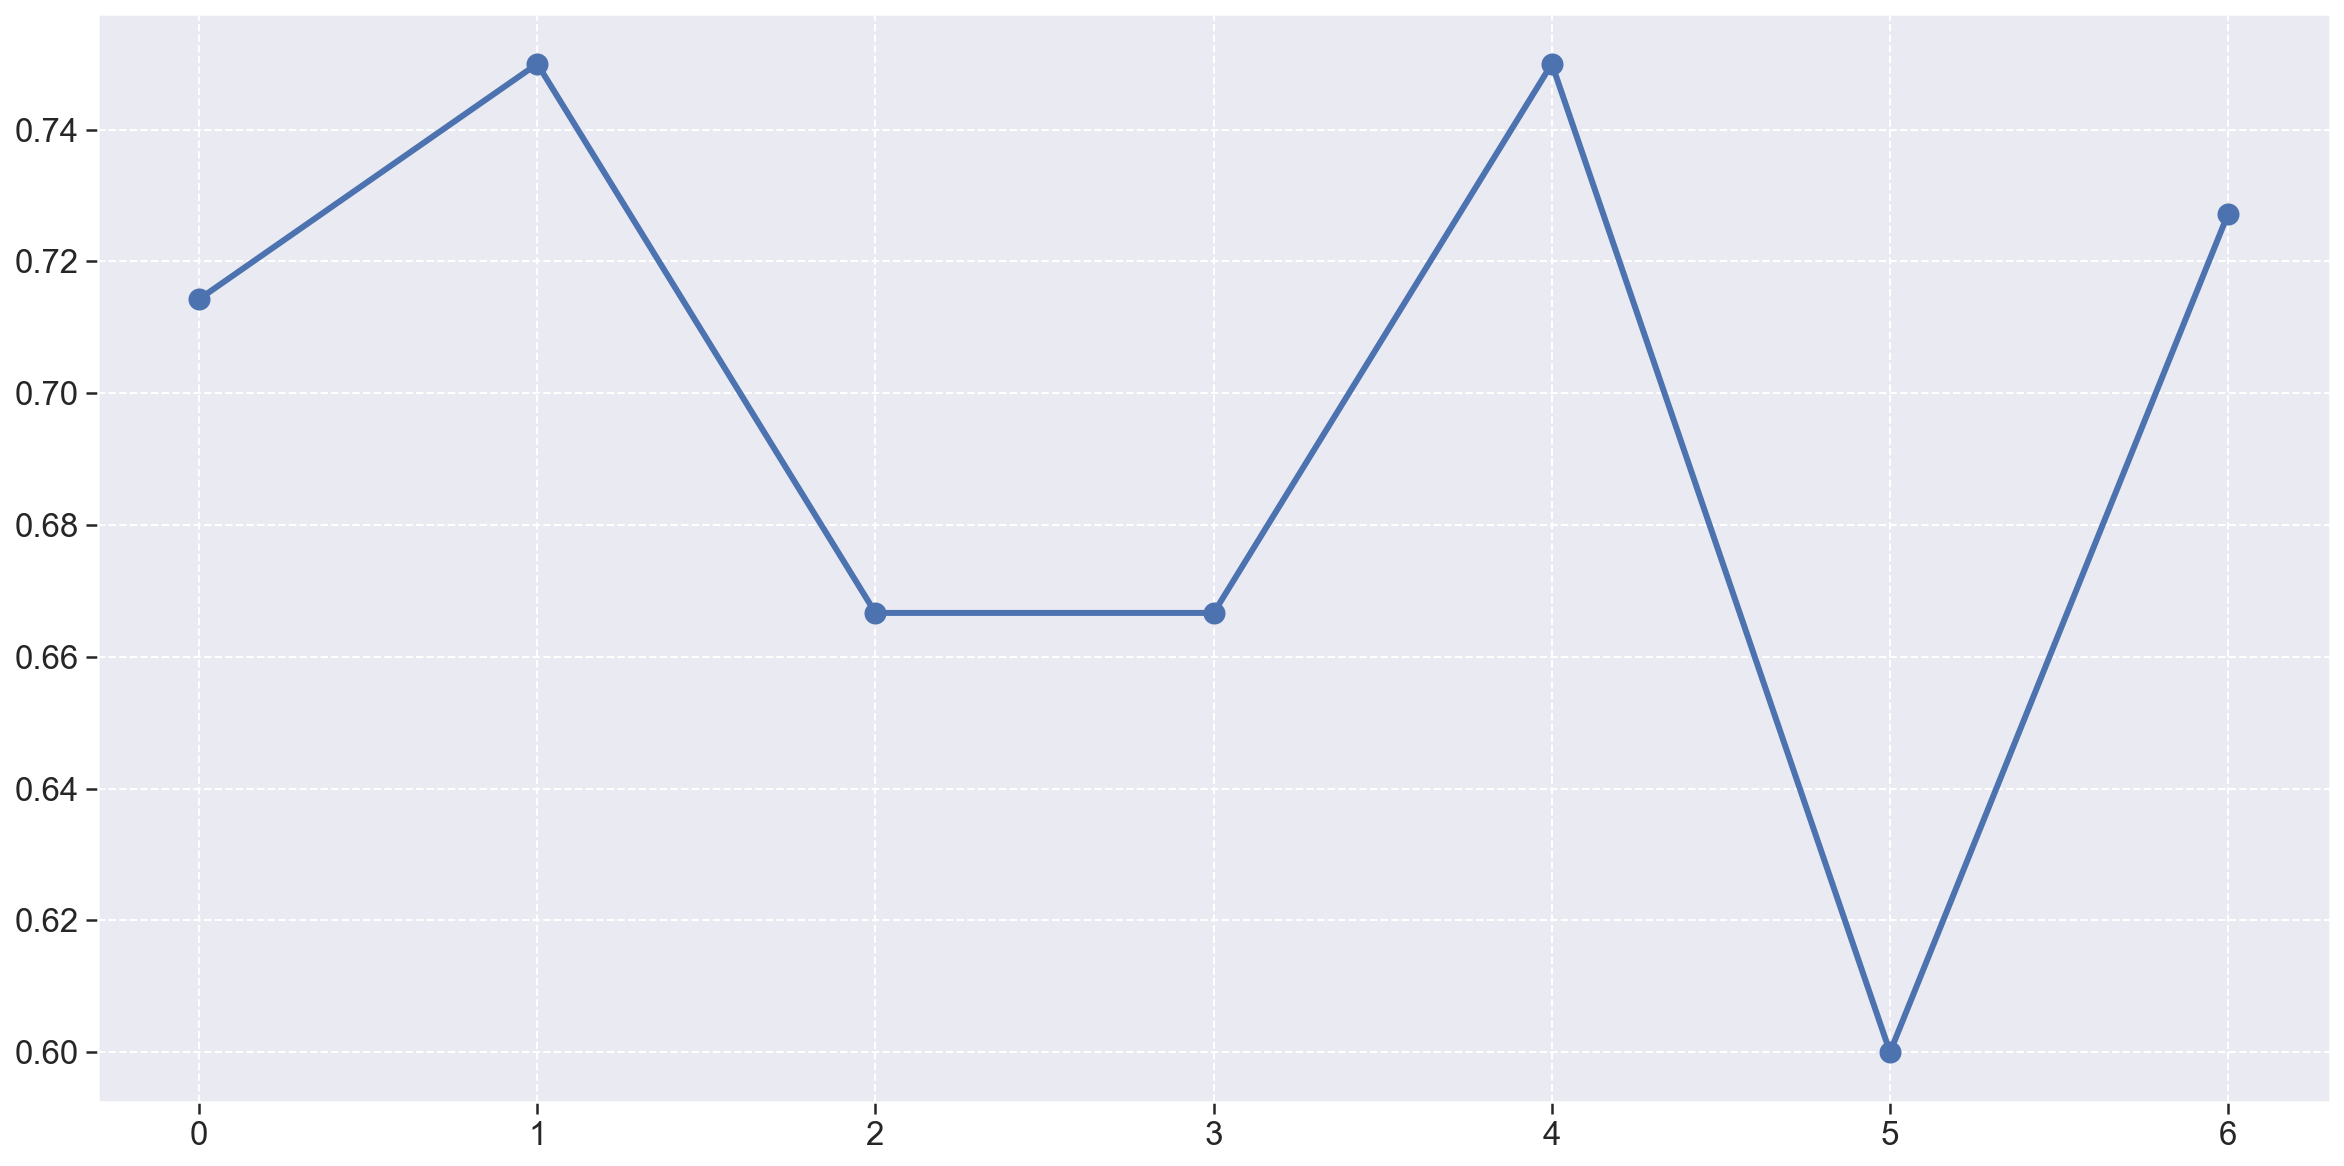

In [26]:
fig = plt.figure(figsize=(20, 10))

plt.plot(clients_metrics['m1'], linewidth=3, marker='o', markersize=10)

## M2

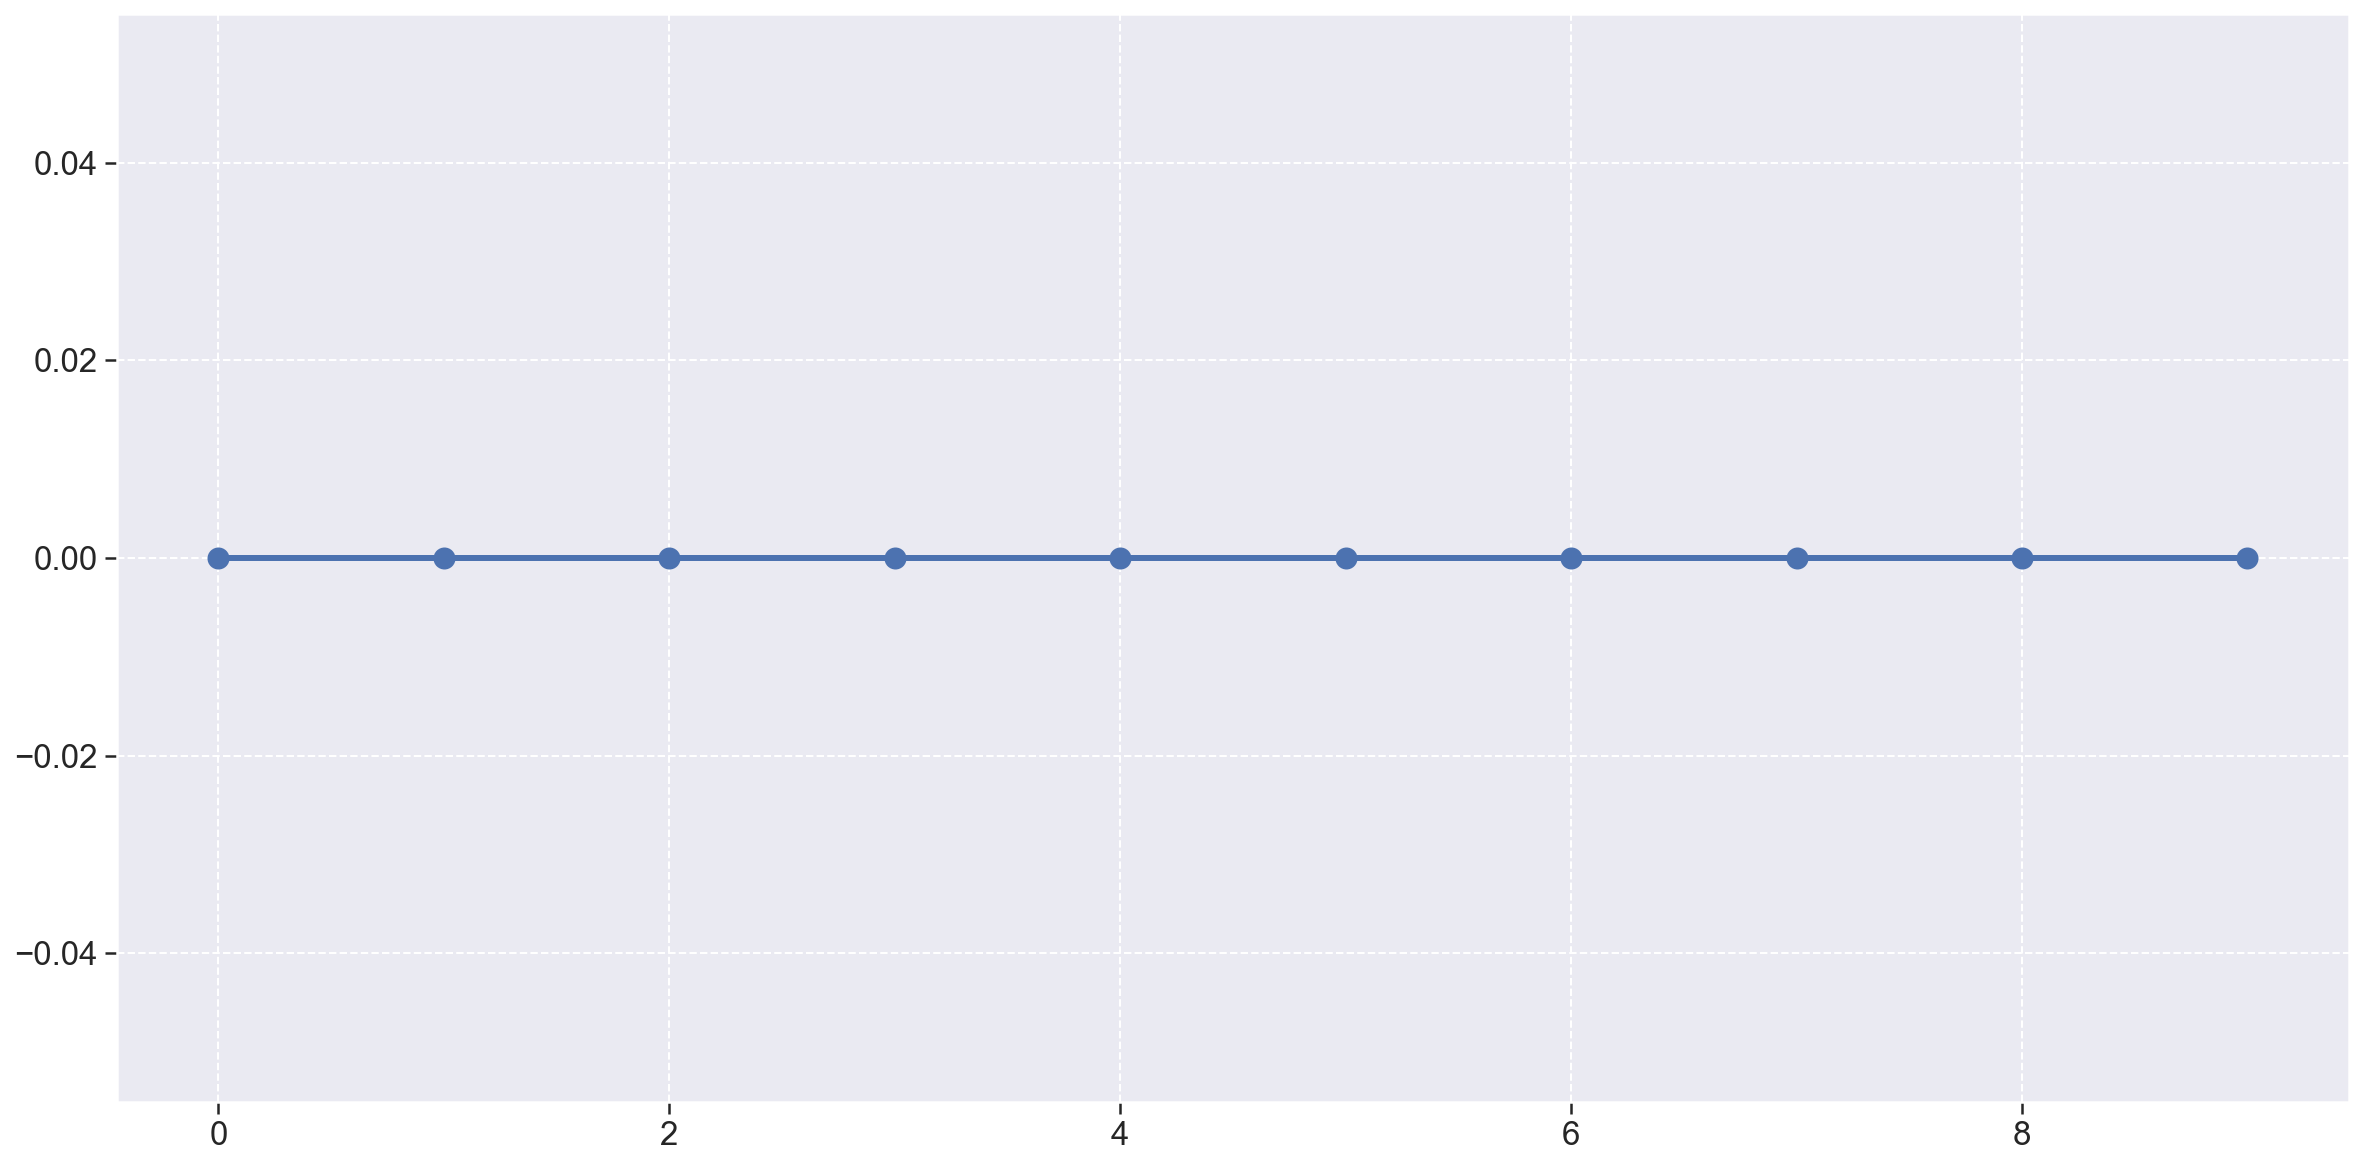

In [27]:
fig = plt.figure(figsize=(20, 10))

plt.plot(users_metrics['m2'], linewidth=3, marker='o', markersize=10)

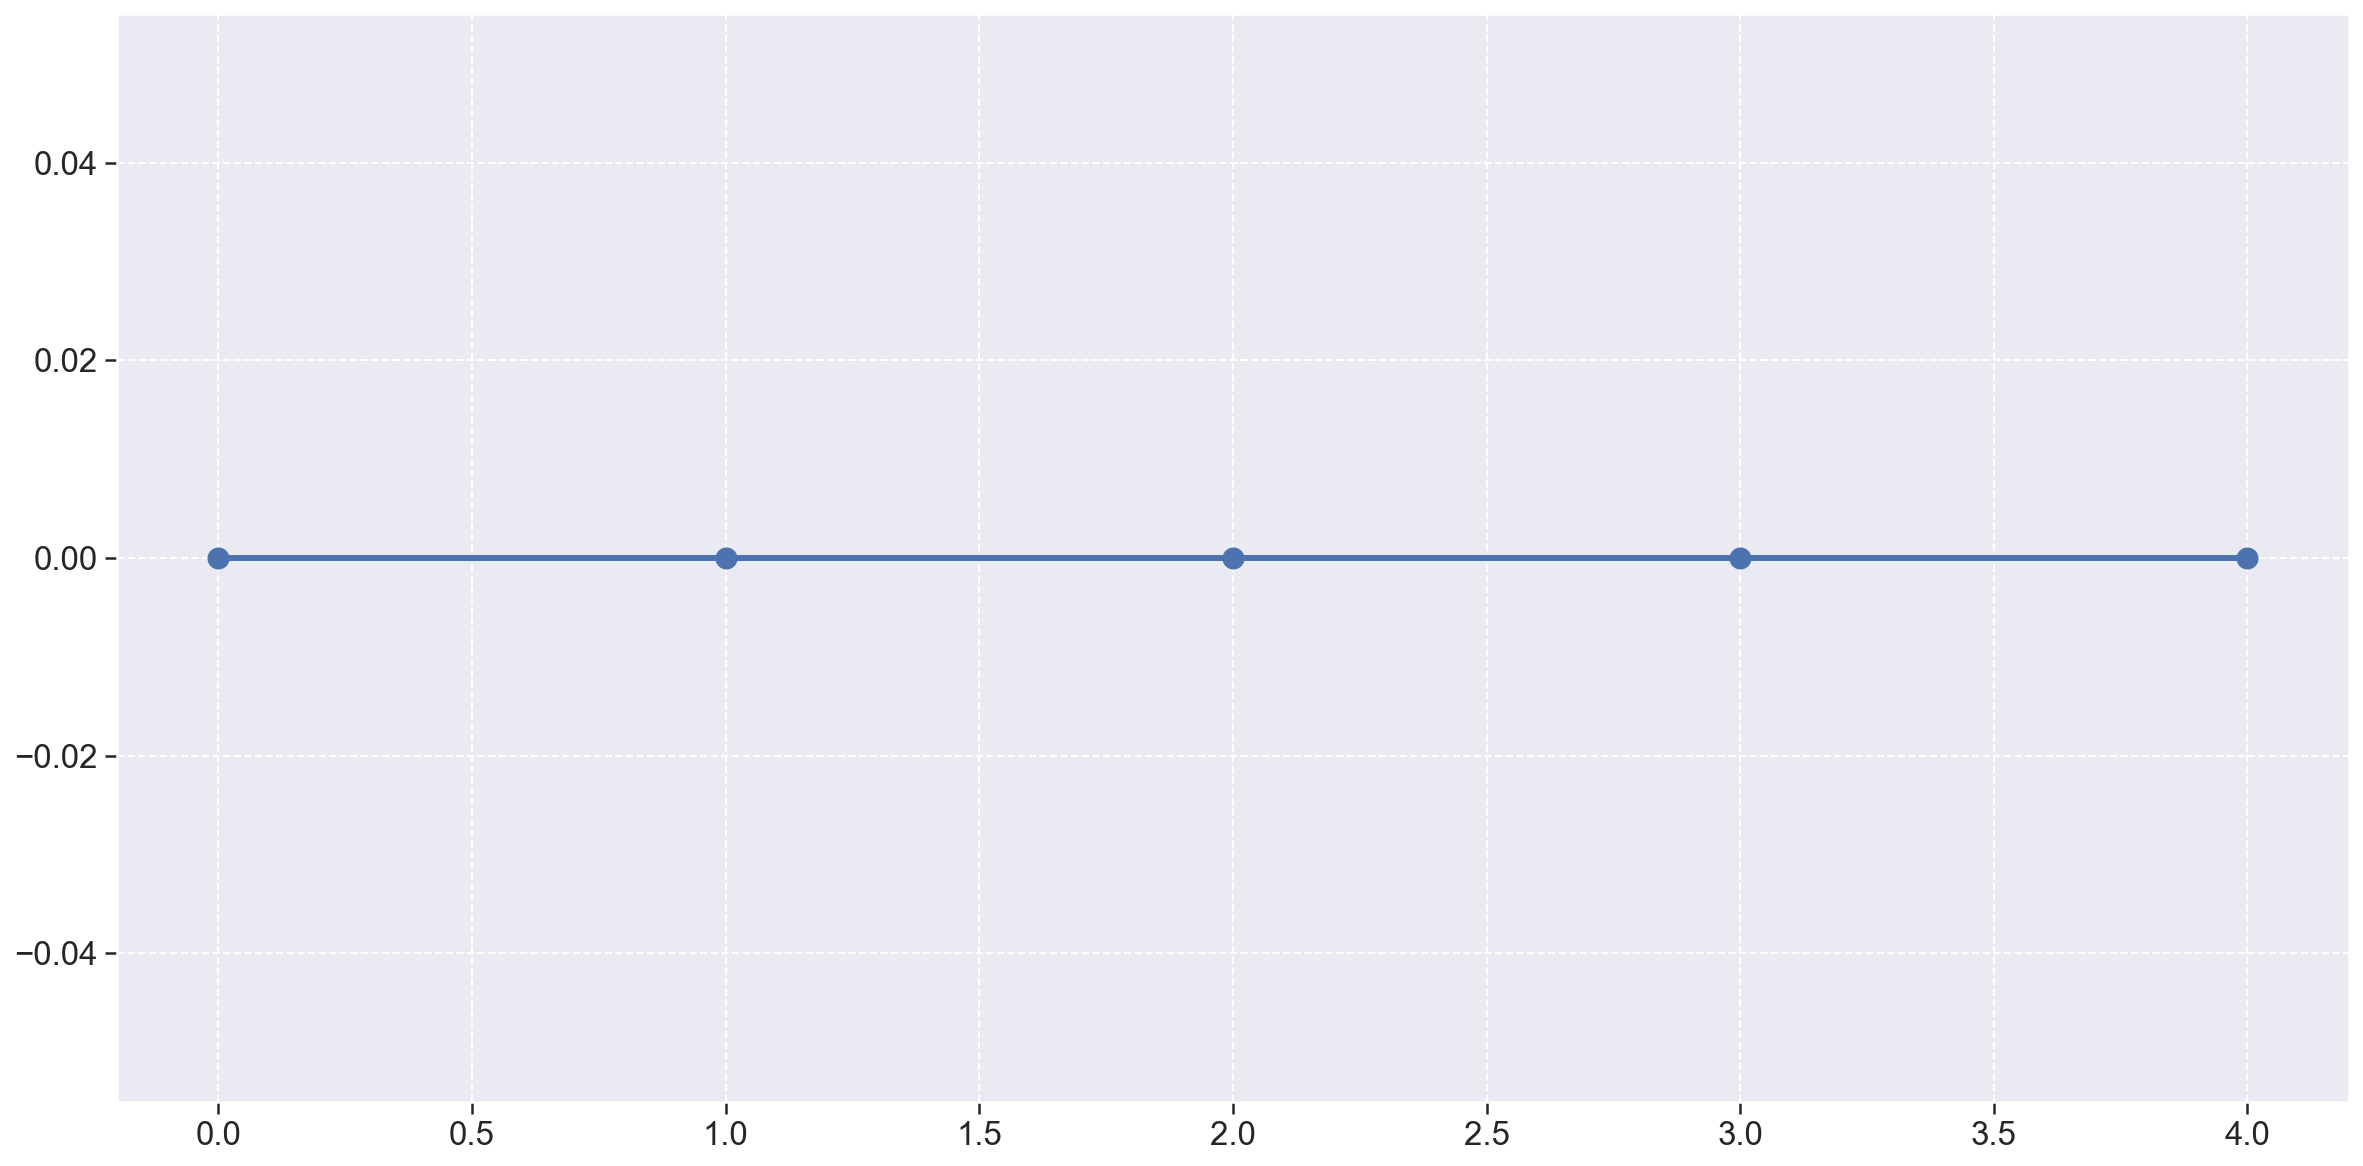

In [28]:
fig = plt.figure(figsize=(20, 10))

plt.plot(sectors_metrics['m2'], linewidth=3, marker='o', markersize=10)

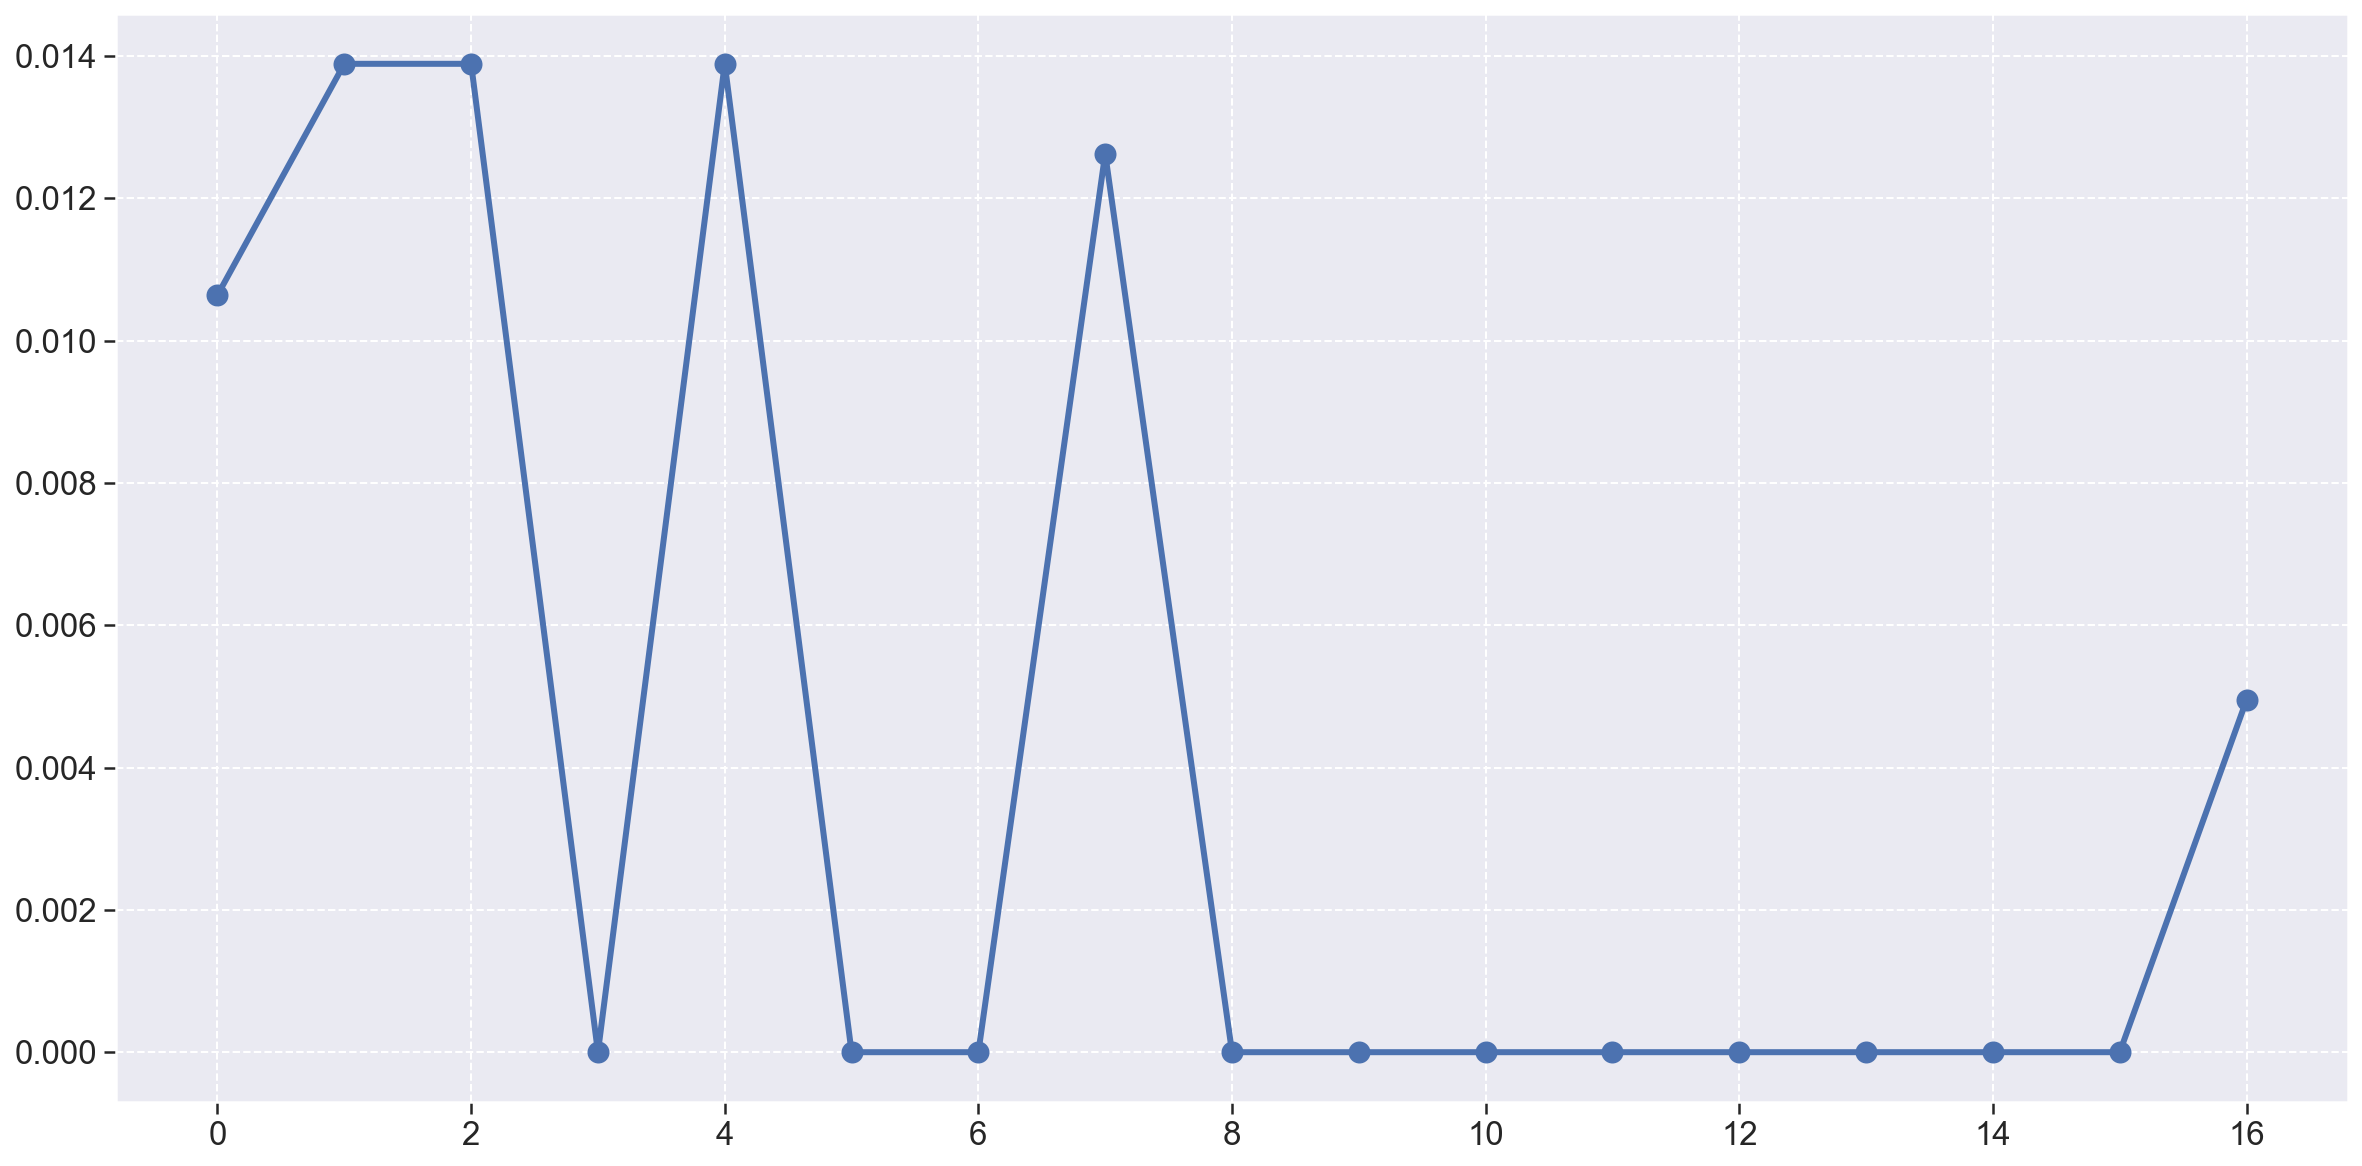

In [29]:
fig = plt.figure(figsize=(20, 10))

plt.plot(frontend_metrics['m2'], linewidth=3, marker='o', markersize=10)

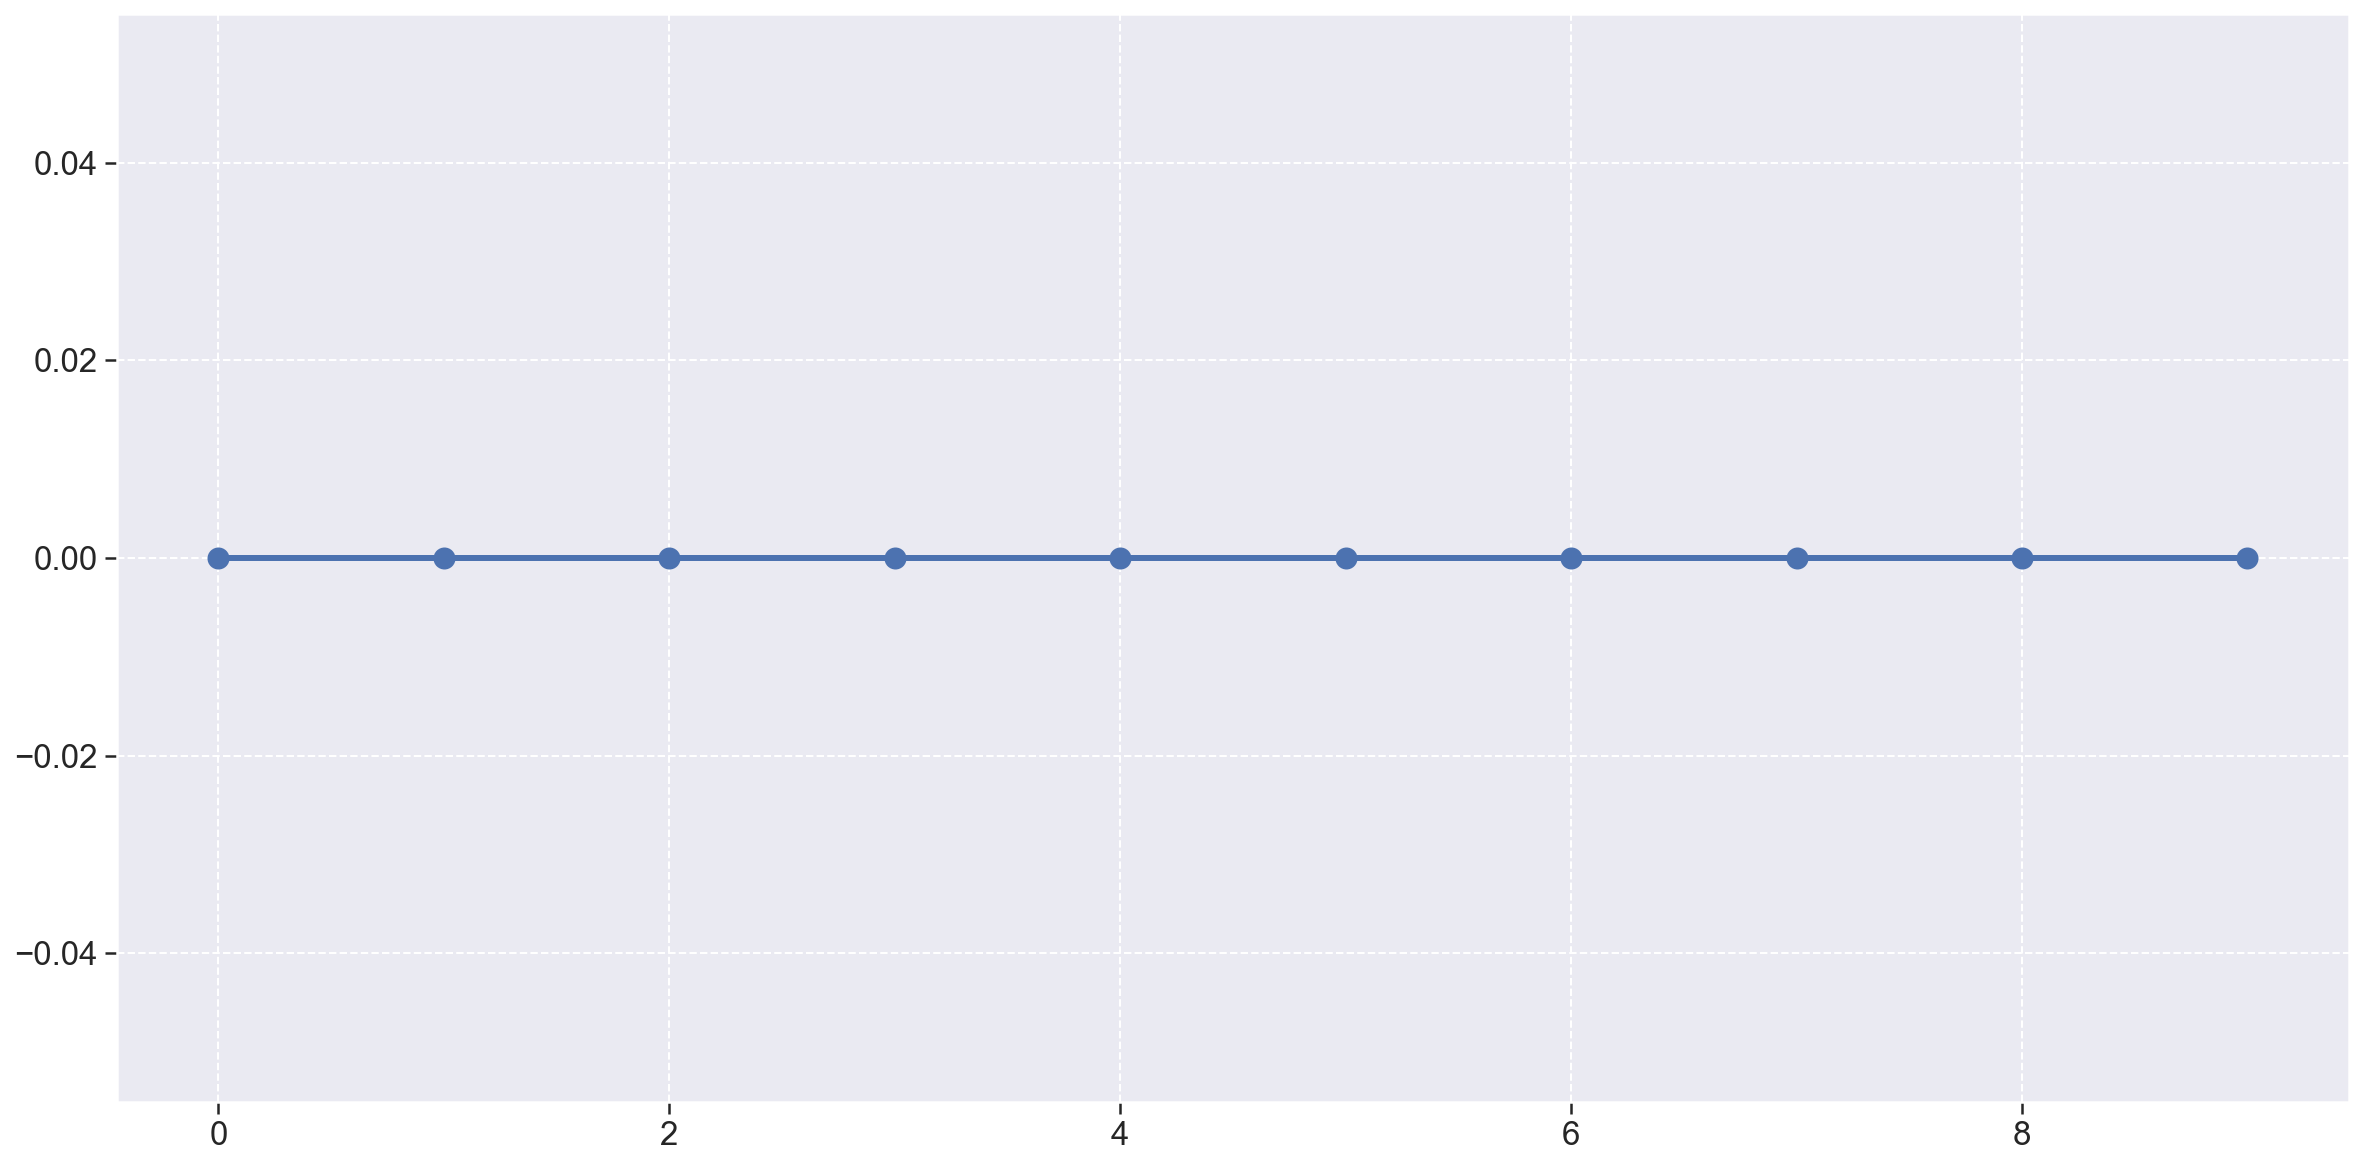

In [30]:
fig = plt.figure(figsize=(20, 10))

plt.plot(demands_metrics['m2'], linewidth=3, marker='o', markersize=10)

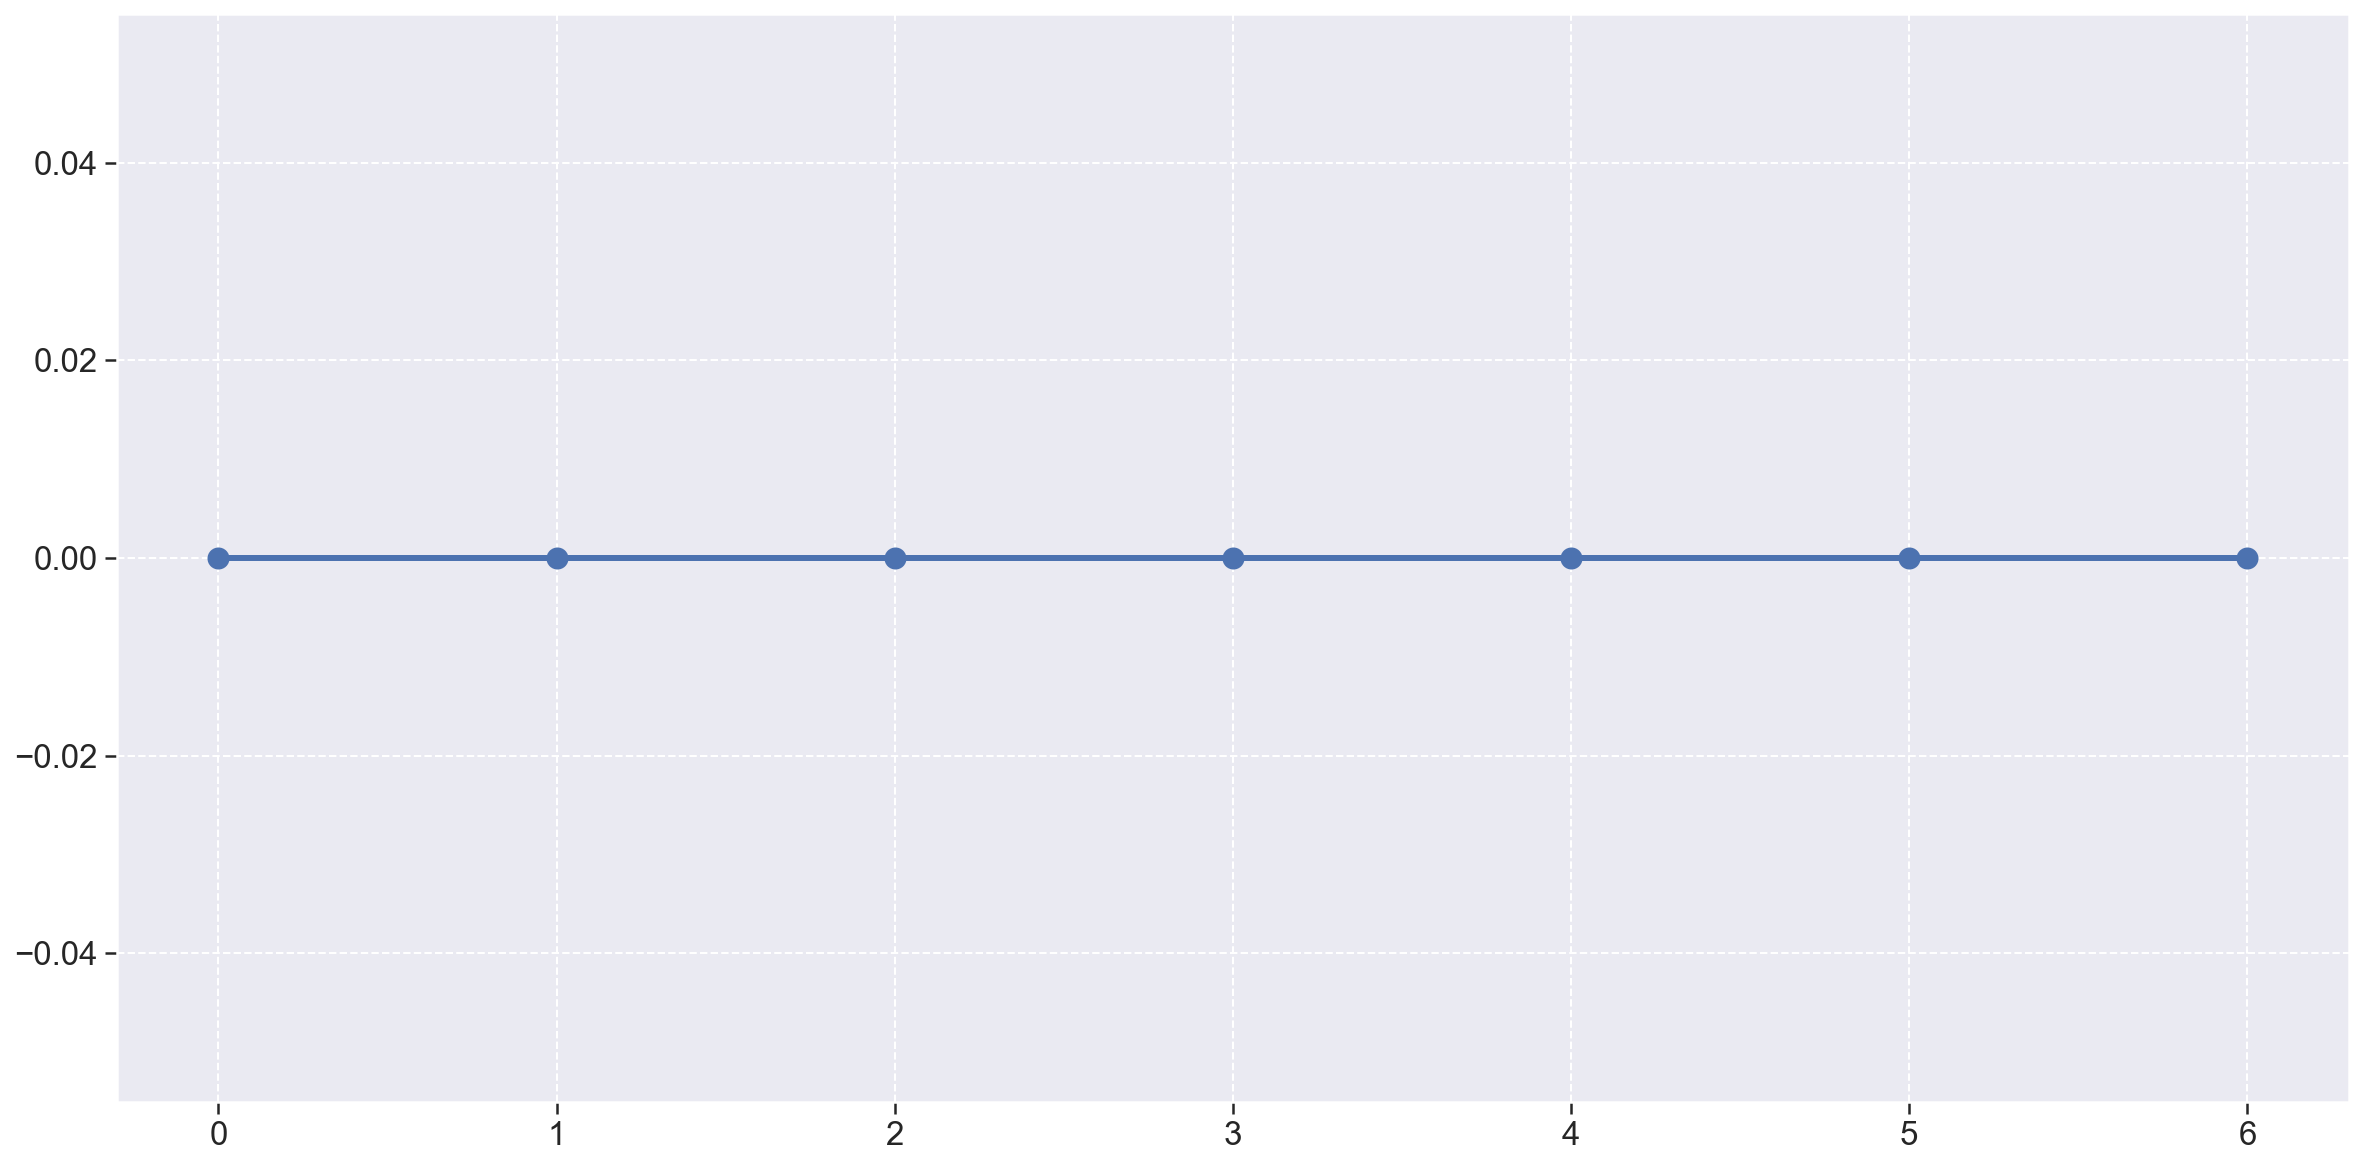

In [31]:
fig = plt.figure(figsize=(20, 10))

plt.plot(clients_metrics['m2'], linewidth=3, marker='o', markersize=10)

## M3

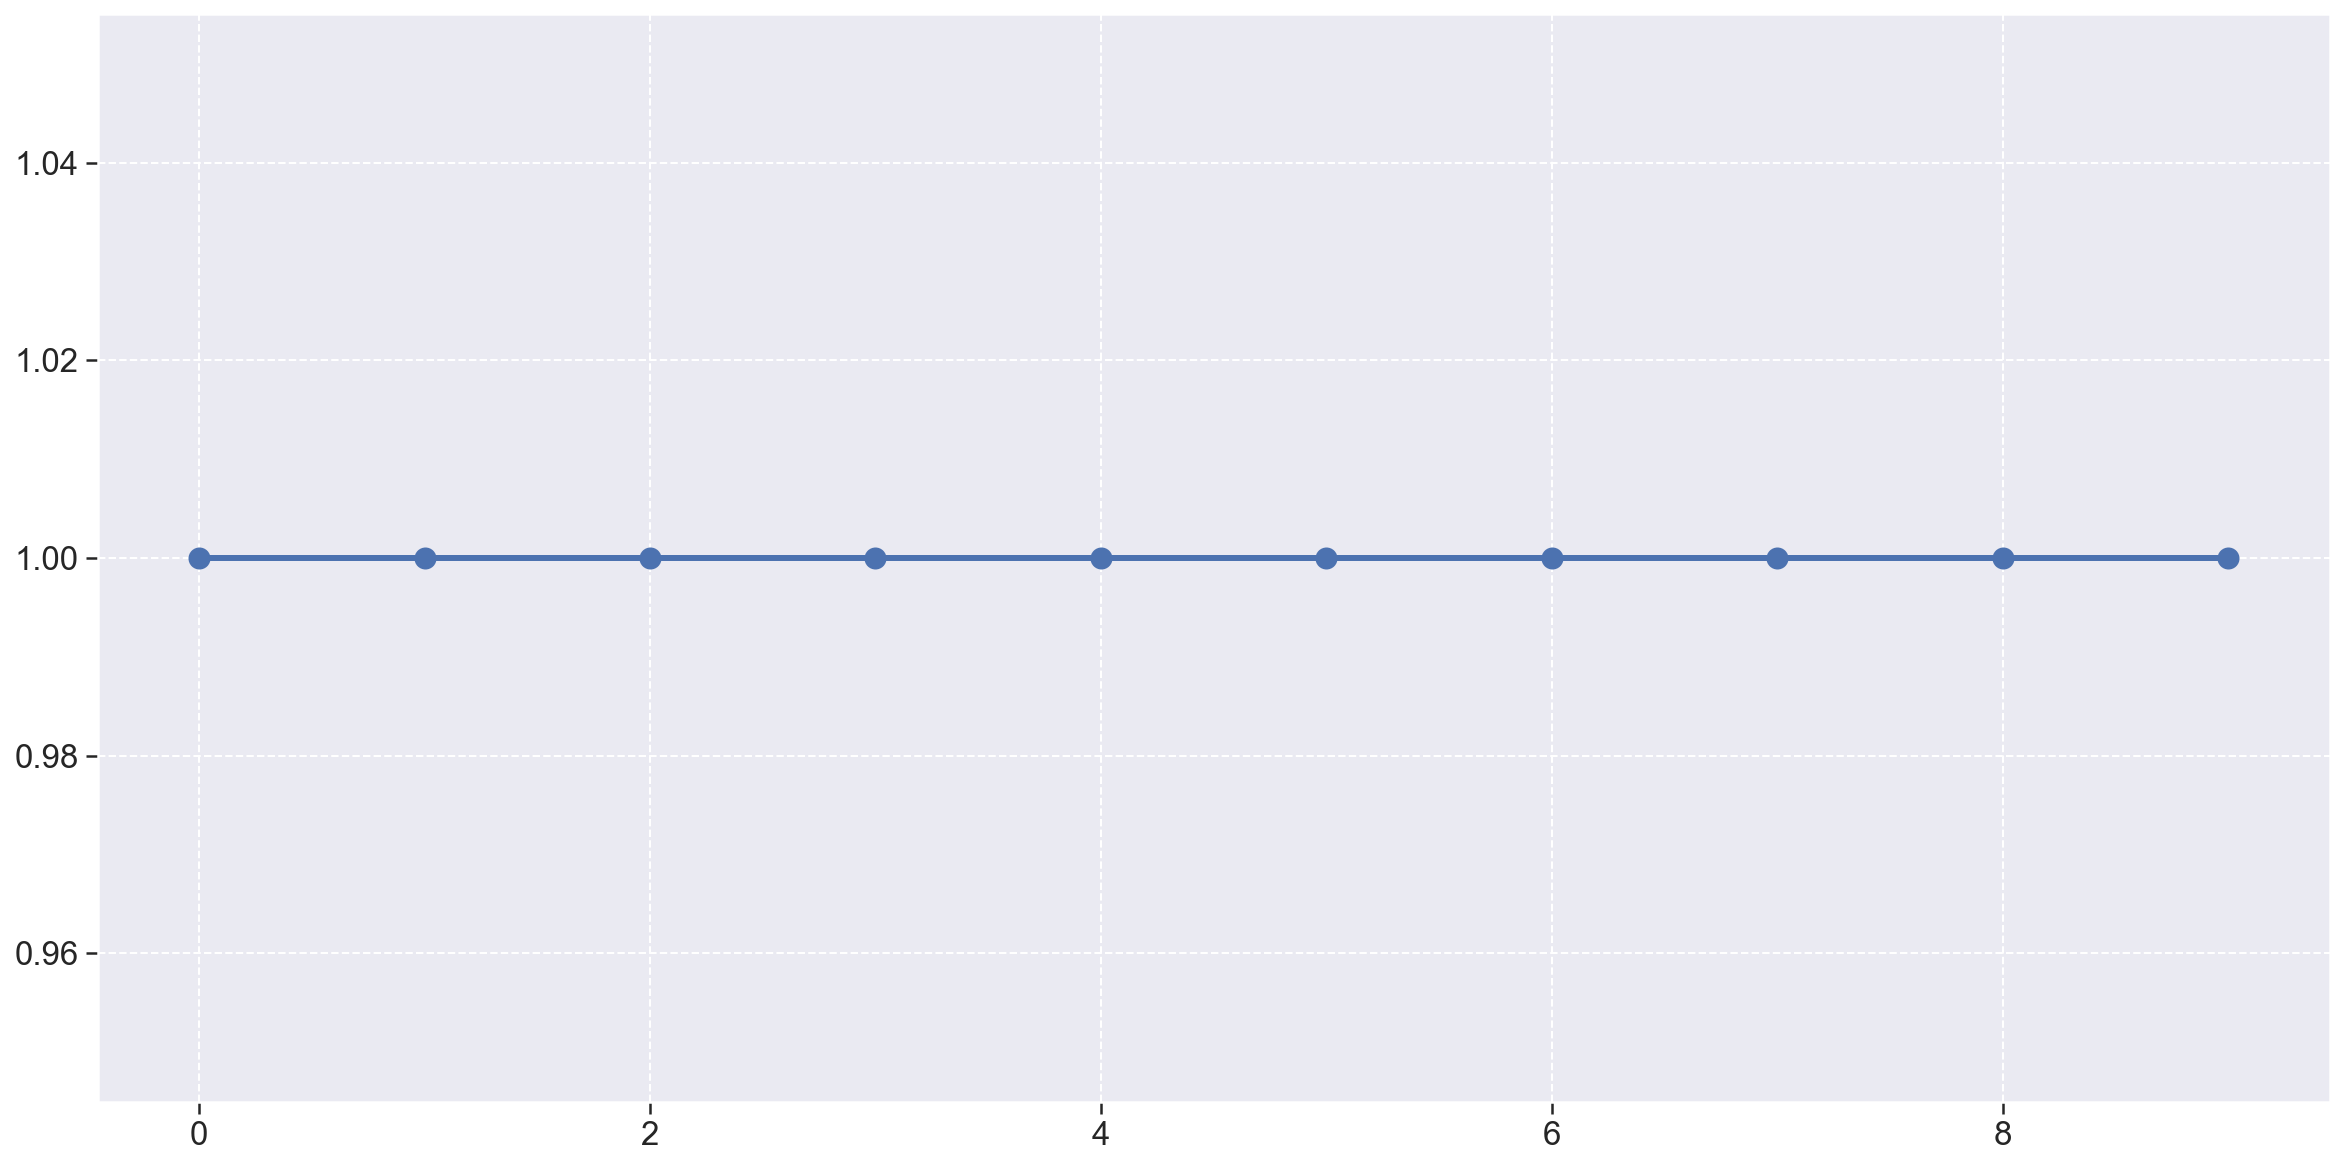

In [32]:
fig = plt.figure(figsize=(20, 10))

plt.plot(users_metrics['m3'], linewidth=3, marker='o', markersize=10)

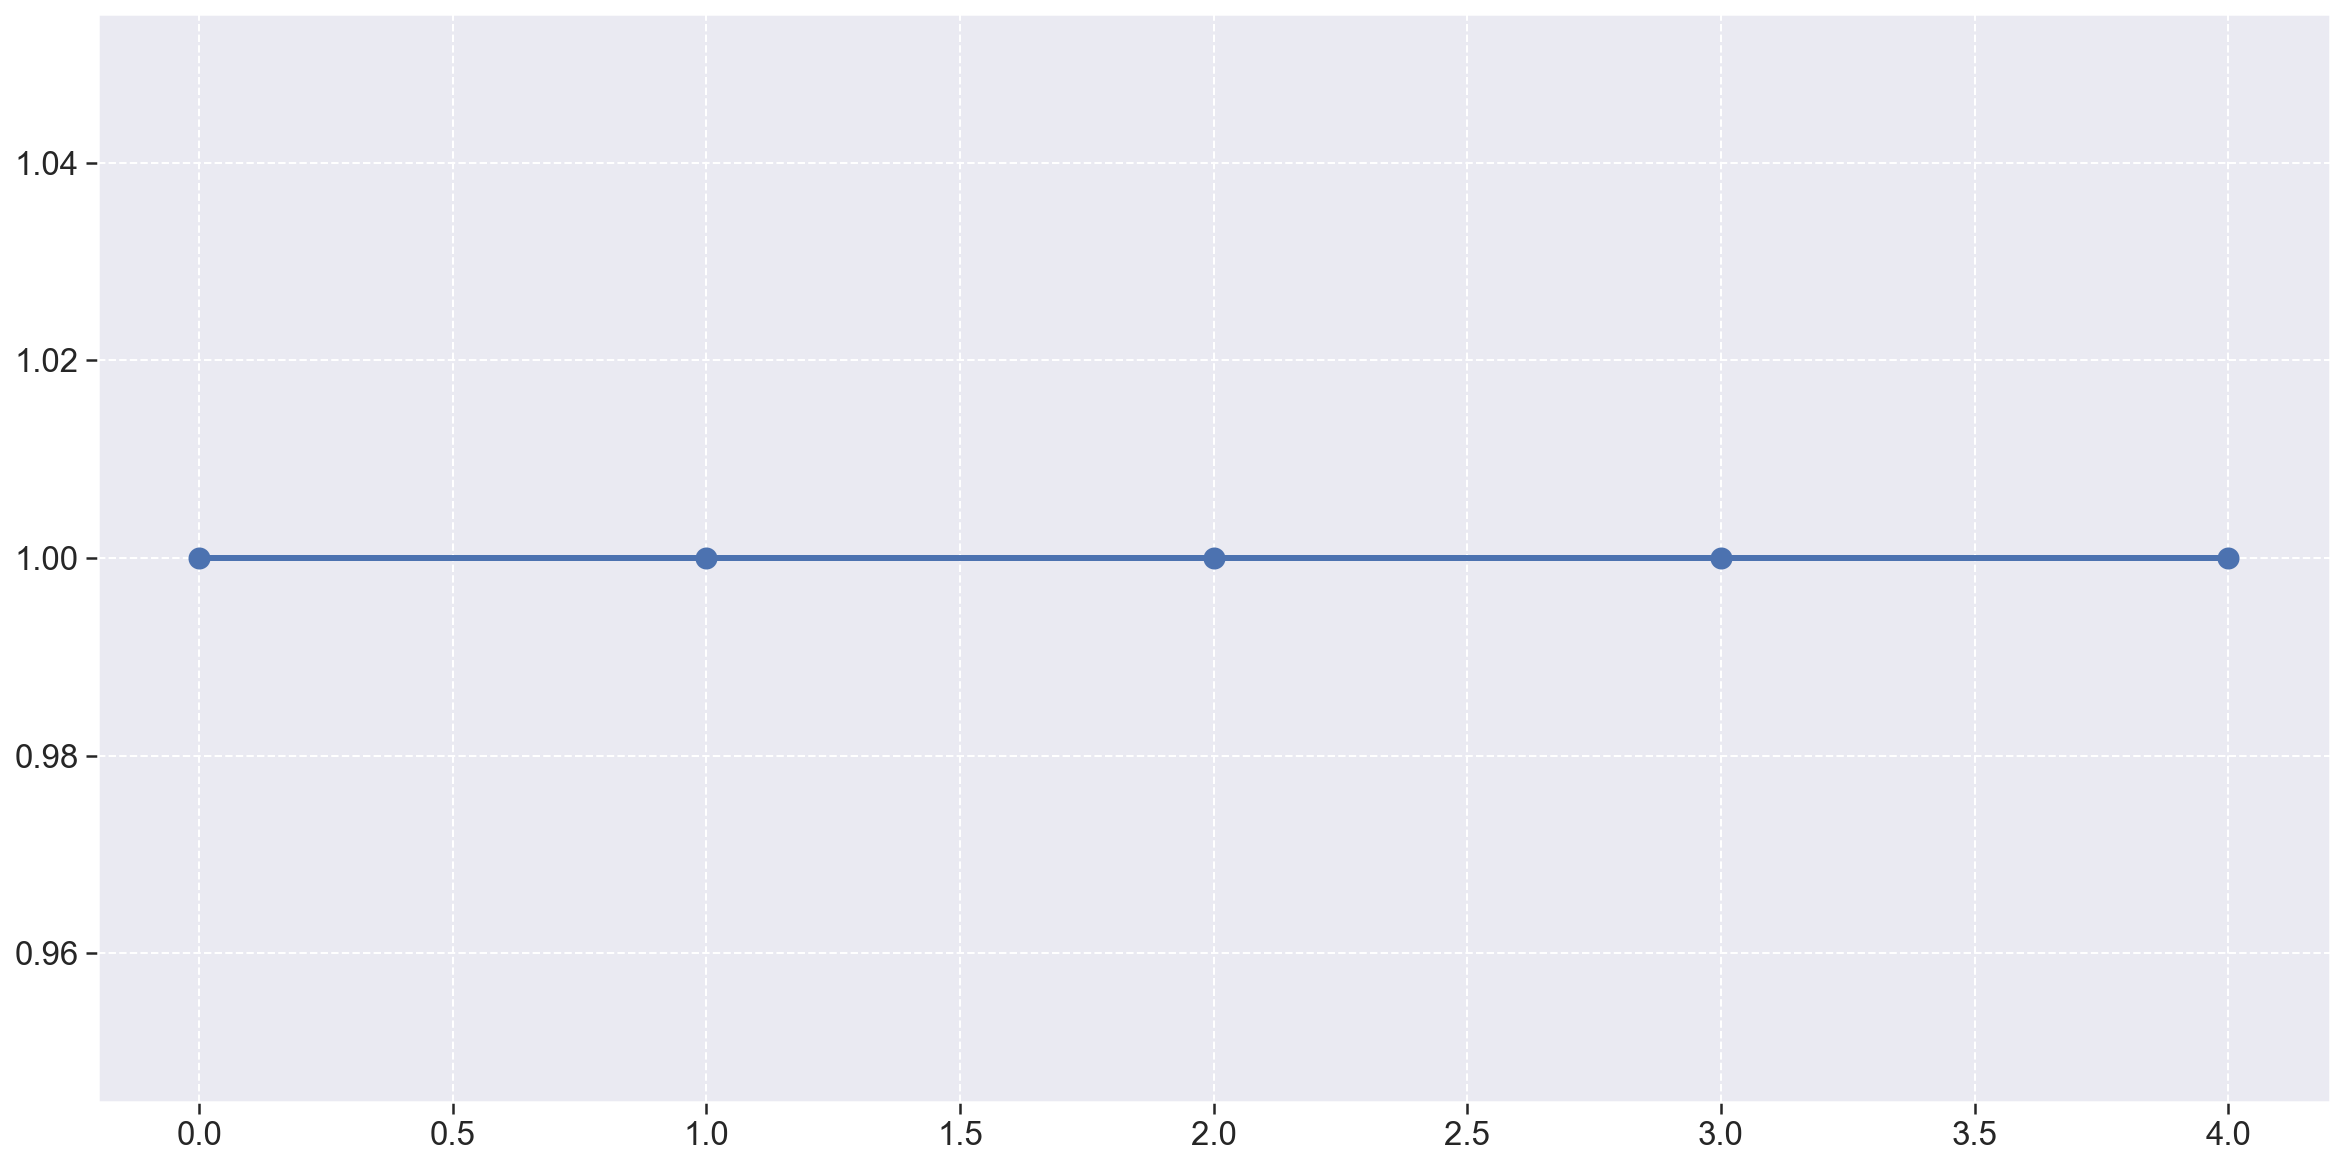

In [33]:
fig = plt.figure(figsize=(20, 10))

plt.plot(sectors_metrics['m3'], linewidth=3, marker='o', markersize=10)

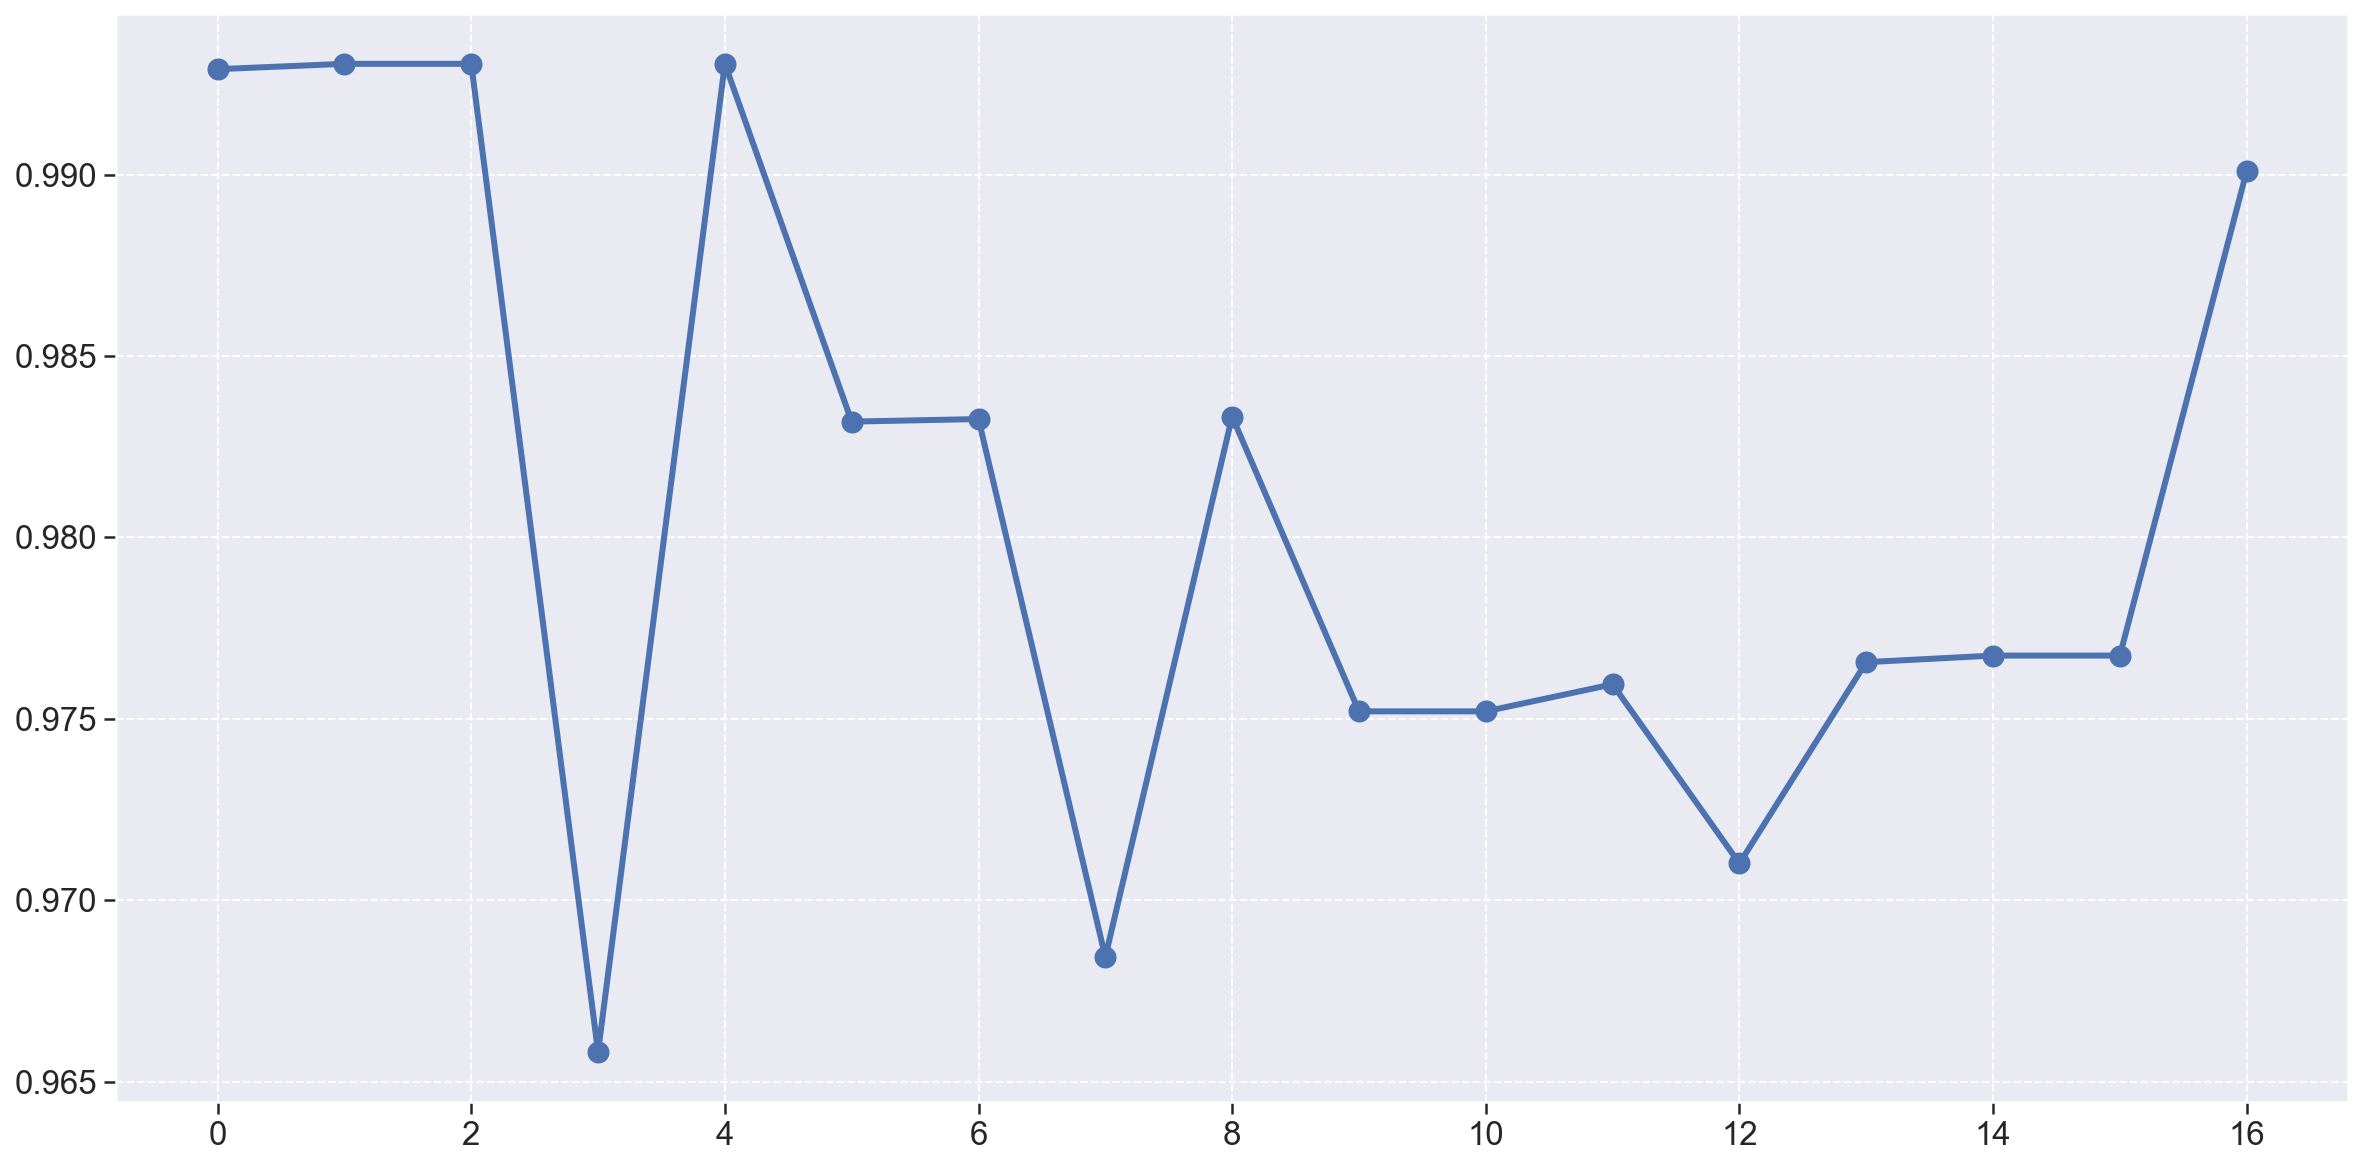

In [34]:
fig = plt.figure(figsize=(20, 10))

plt.plot(frontend_metrics['m3'], linewidth=3, marker='o', markersize=10)

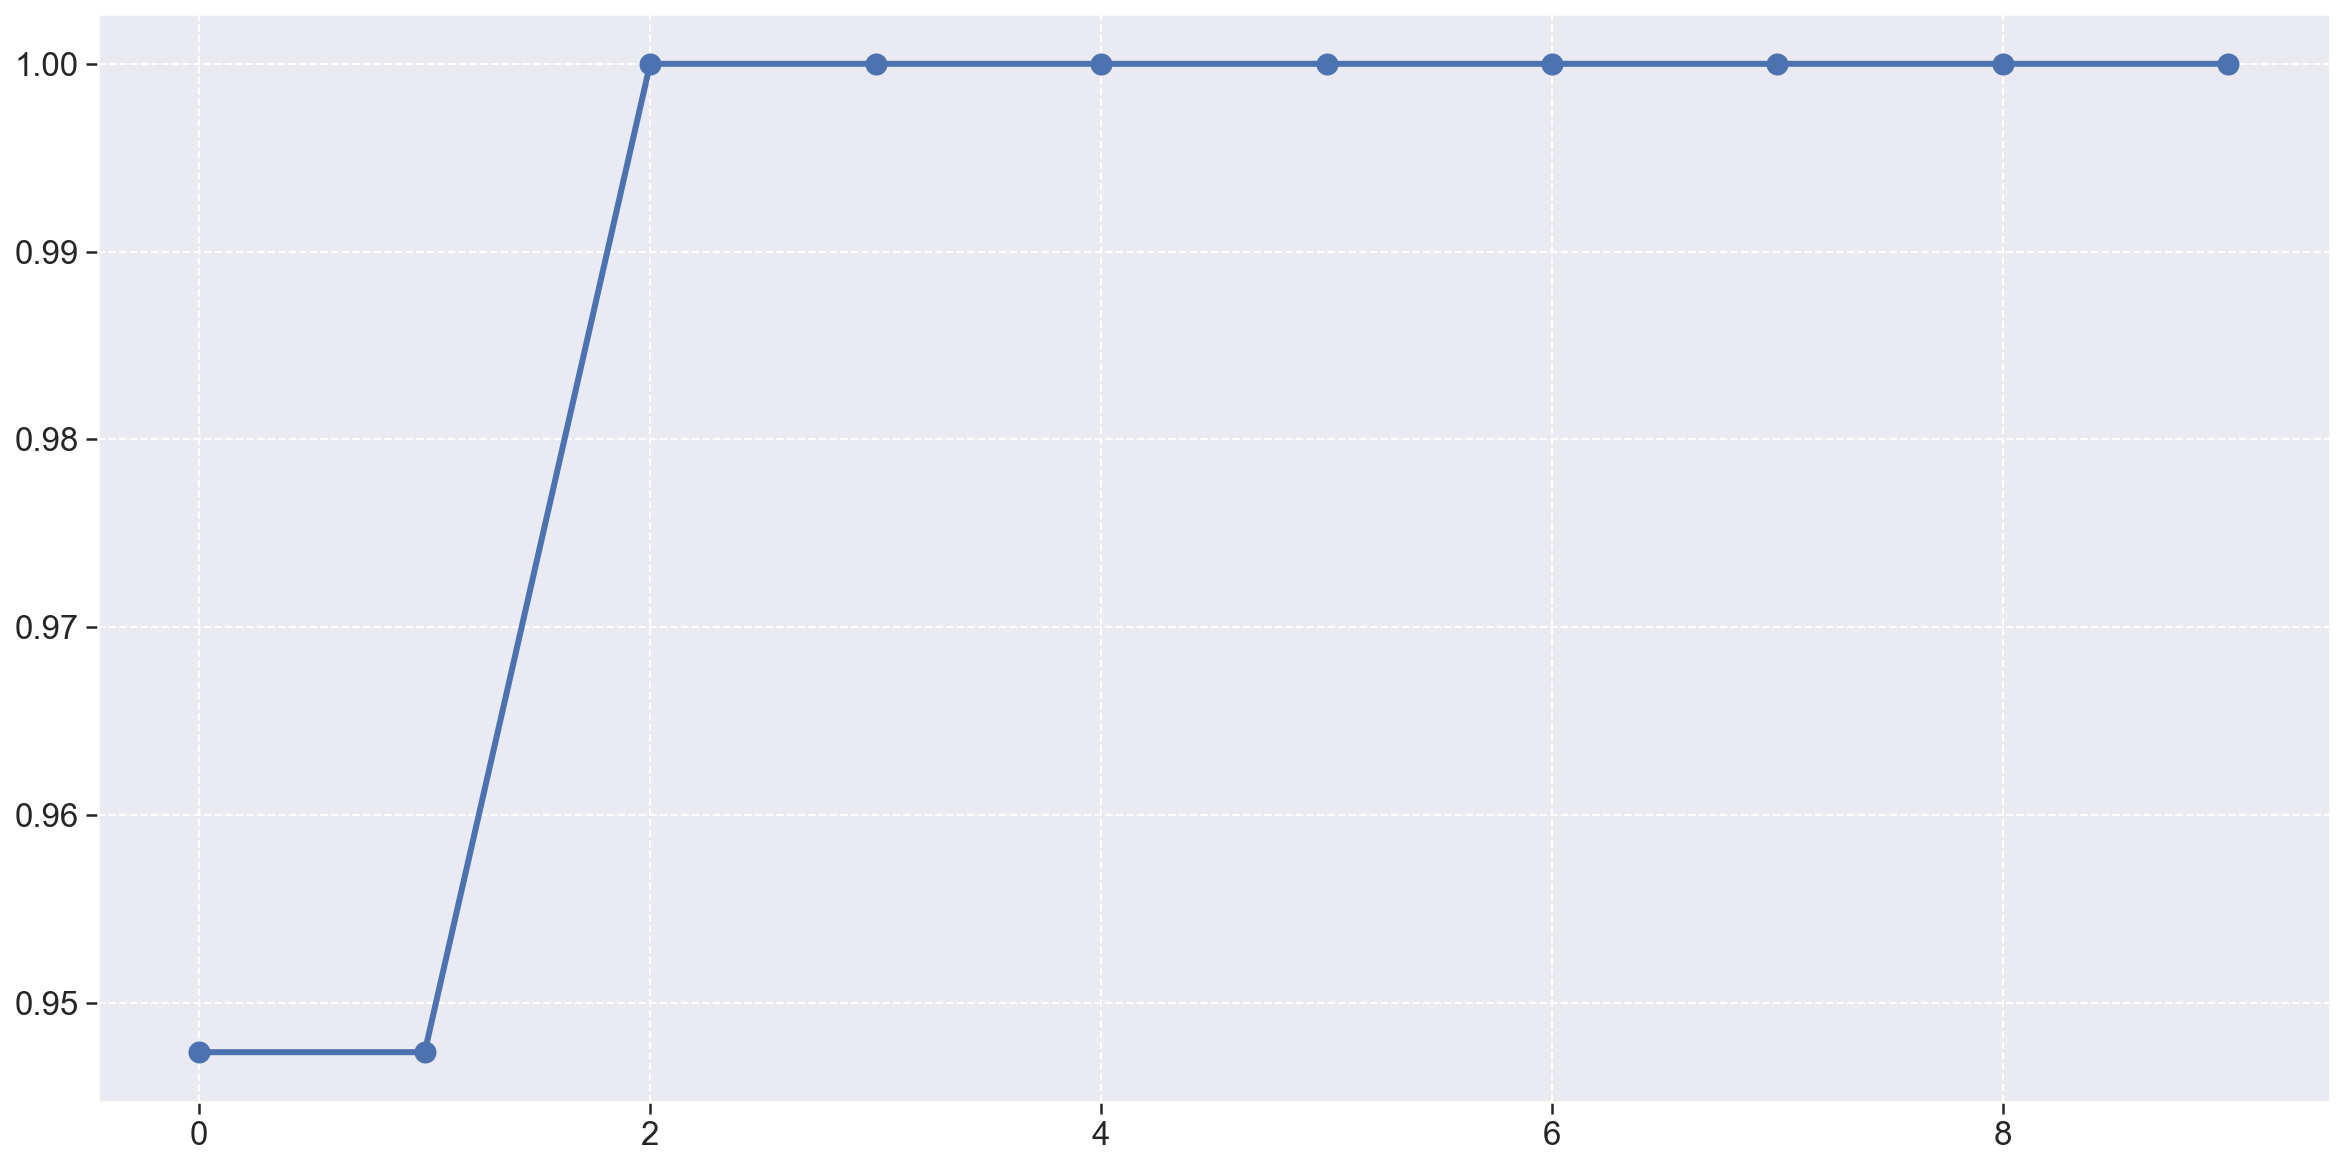

In [35]:
fig = plt.figure(figsize=(20, 10))

plt.plot(demands_metrics['m3'], linewidth=3, marker='o', markersize=10)

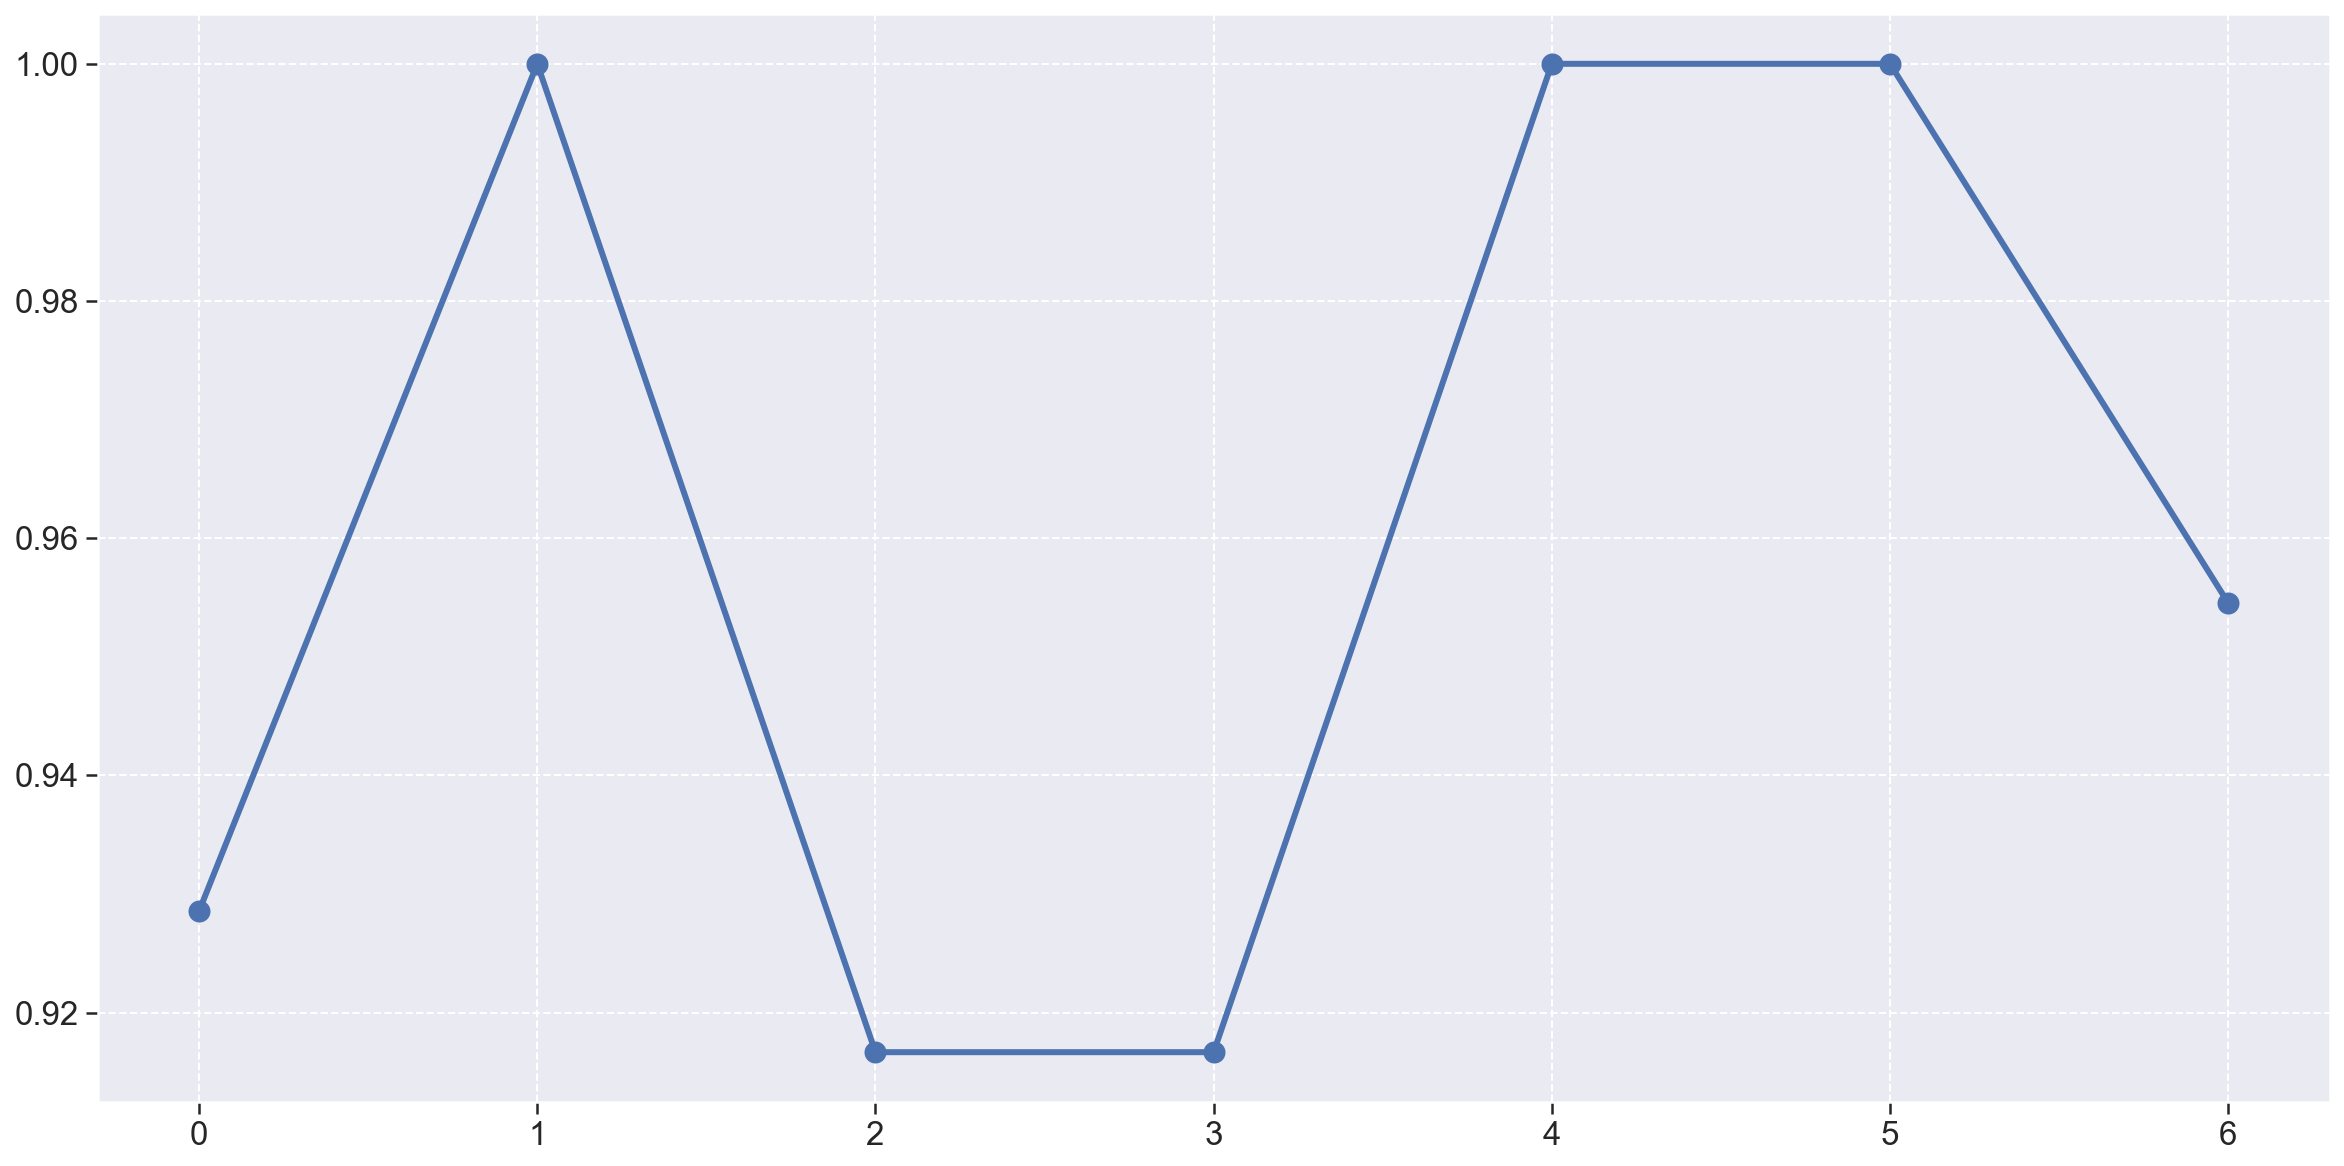

In [36]:
fig = plt.figure(figsize=(20, 10))

plt.plot(clients_metrics['m3'], linewidth=3, marker='o', markersize=10)

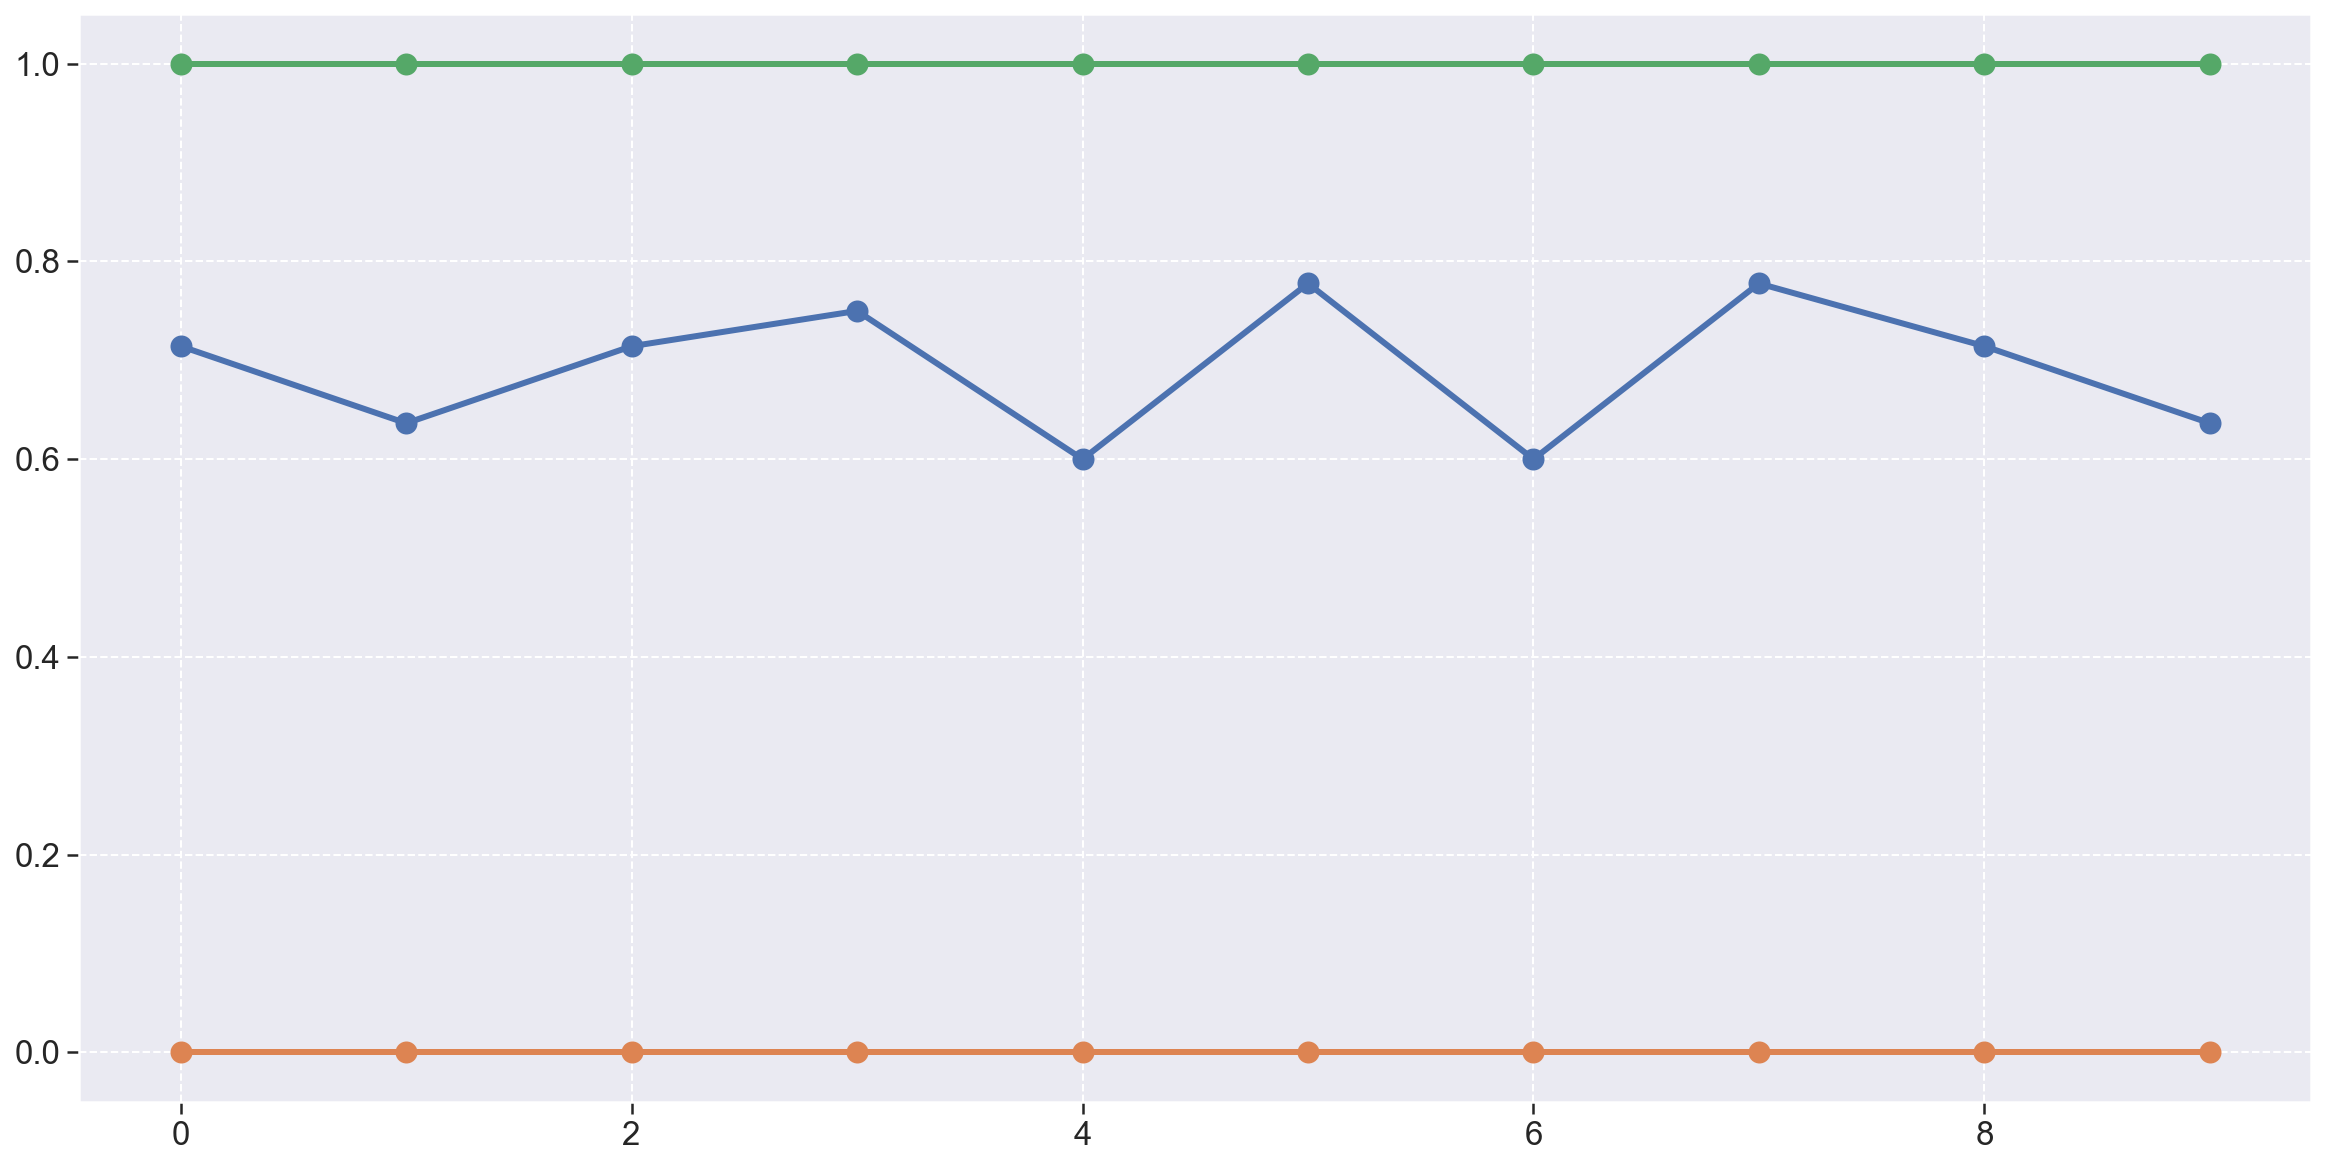

In [37]:
fig = plt.figure(figsize=(20, 10))


plt.plot(users_metrics['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(users_metrics['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(users_metrics['m3'], linewidth=3, marker='o', markersize=10)

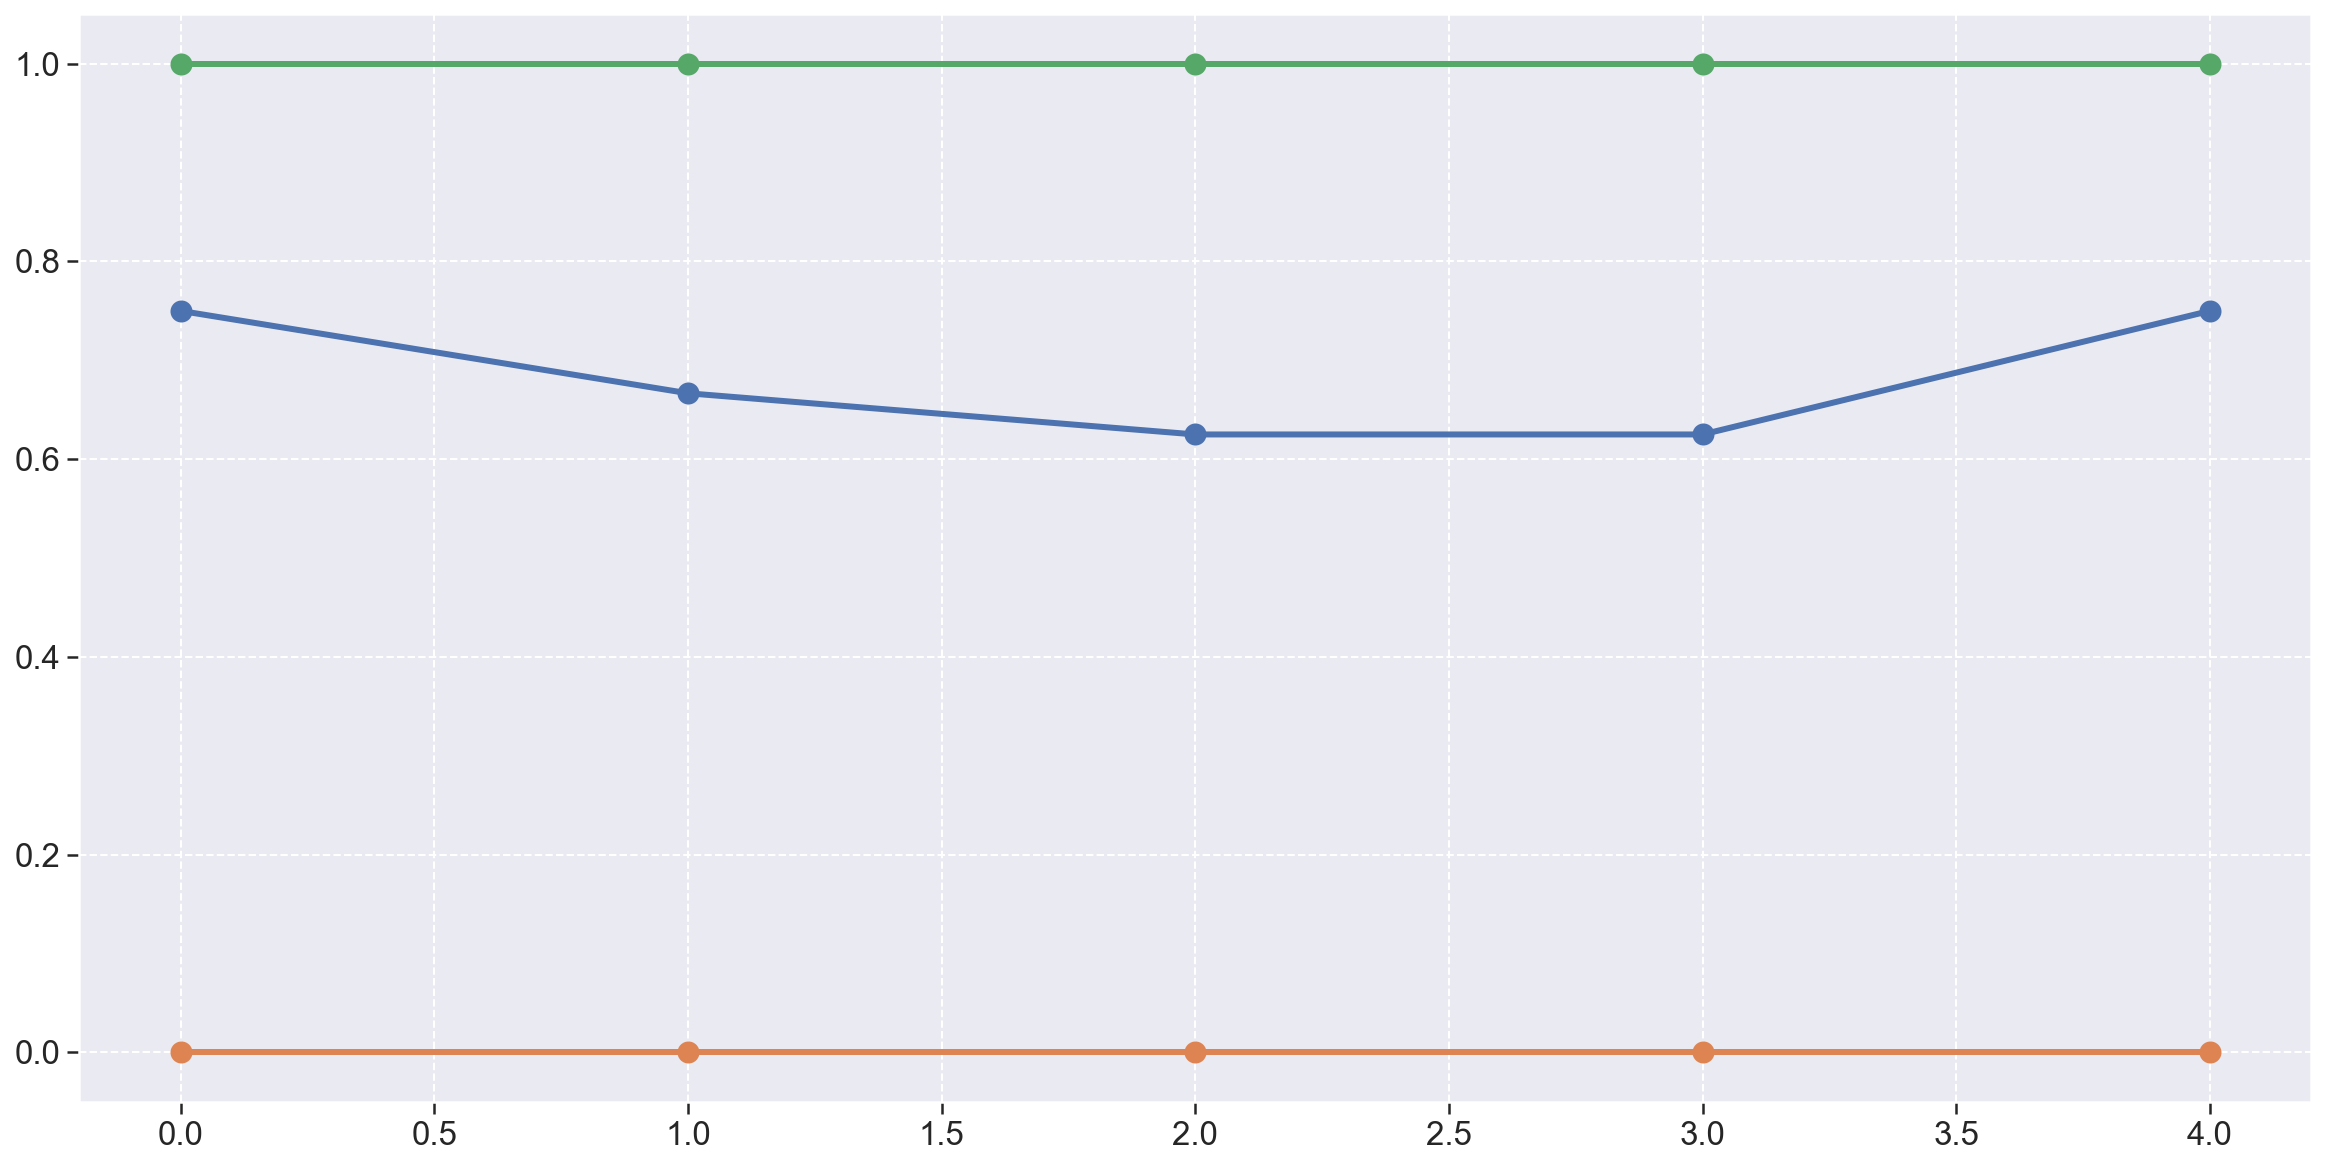

In [38]:
fig = plt.figure(figsize=(20, 10))

plt.plot(sectors_metrics['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(sectors_metrics['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(sectors_metrics['m3'], linewidth=3, marker='o', markersize=10)


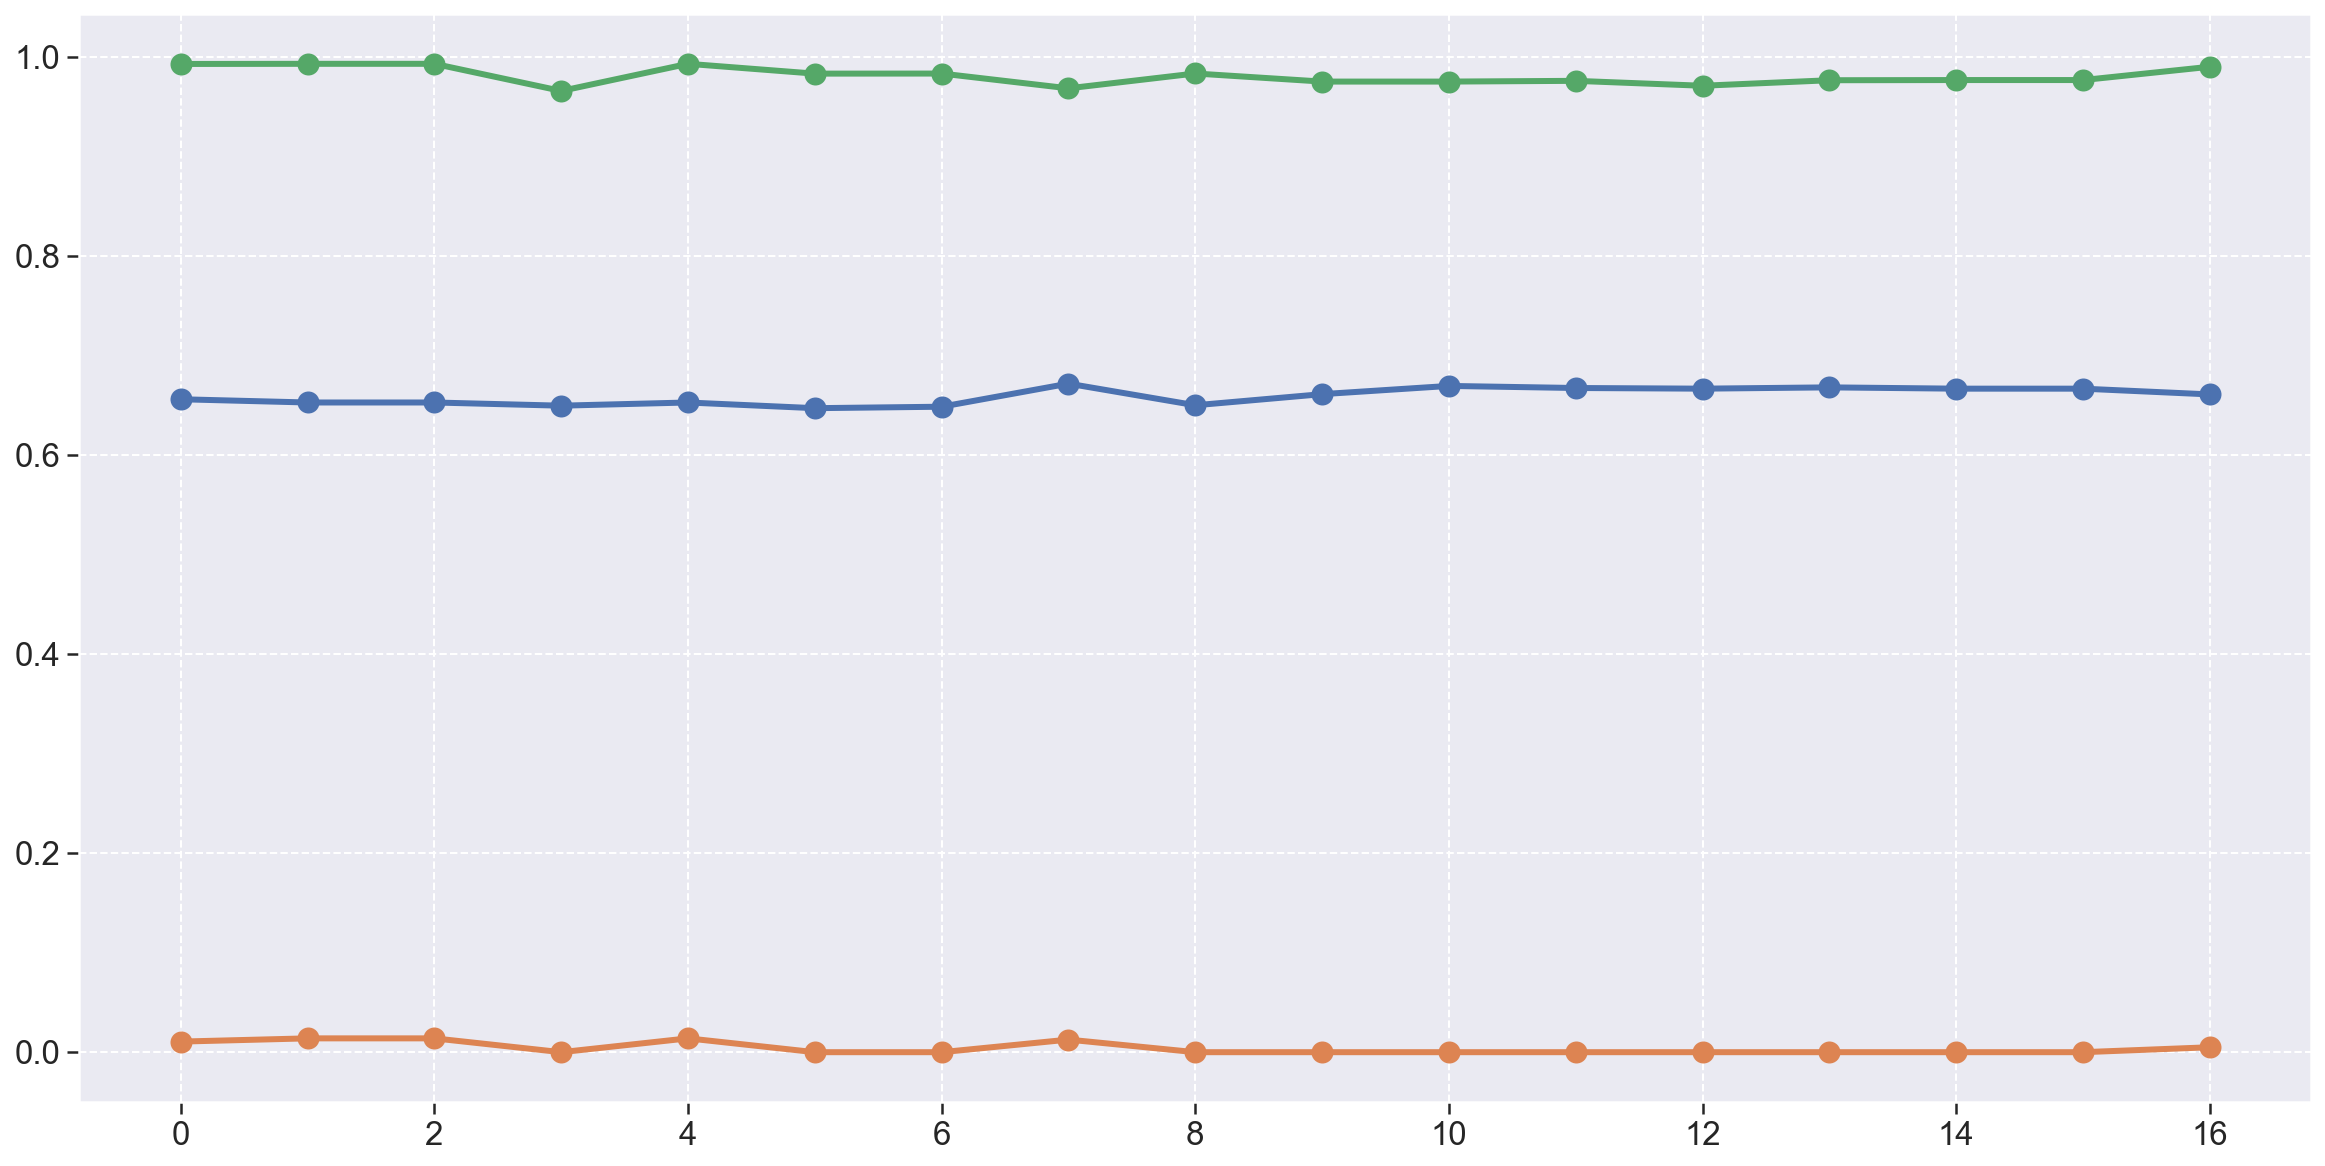

In [39]:
fig = plt.figure(figsize=(20, 10))

plt.plot(frontend_metrics['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(frontend_metrics['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(frontend_metrics['m3'], linewidth=3, marker='o', markersize=10)


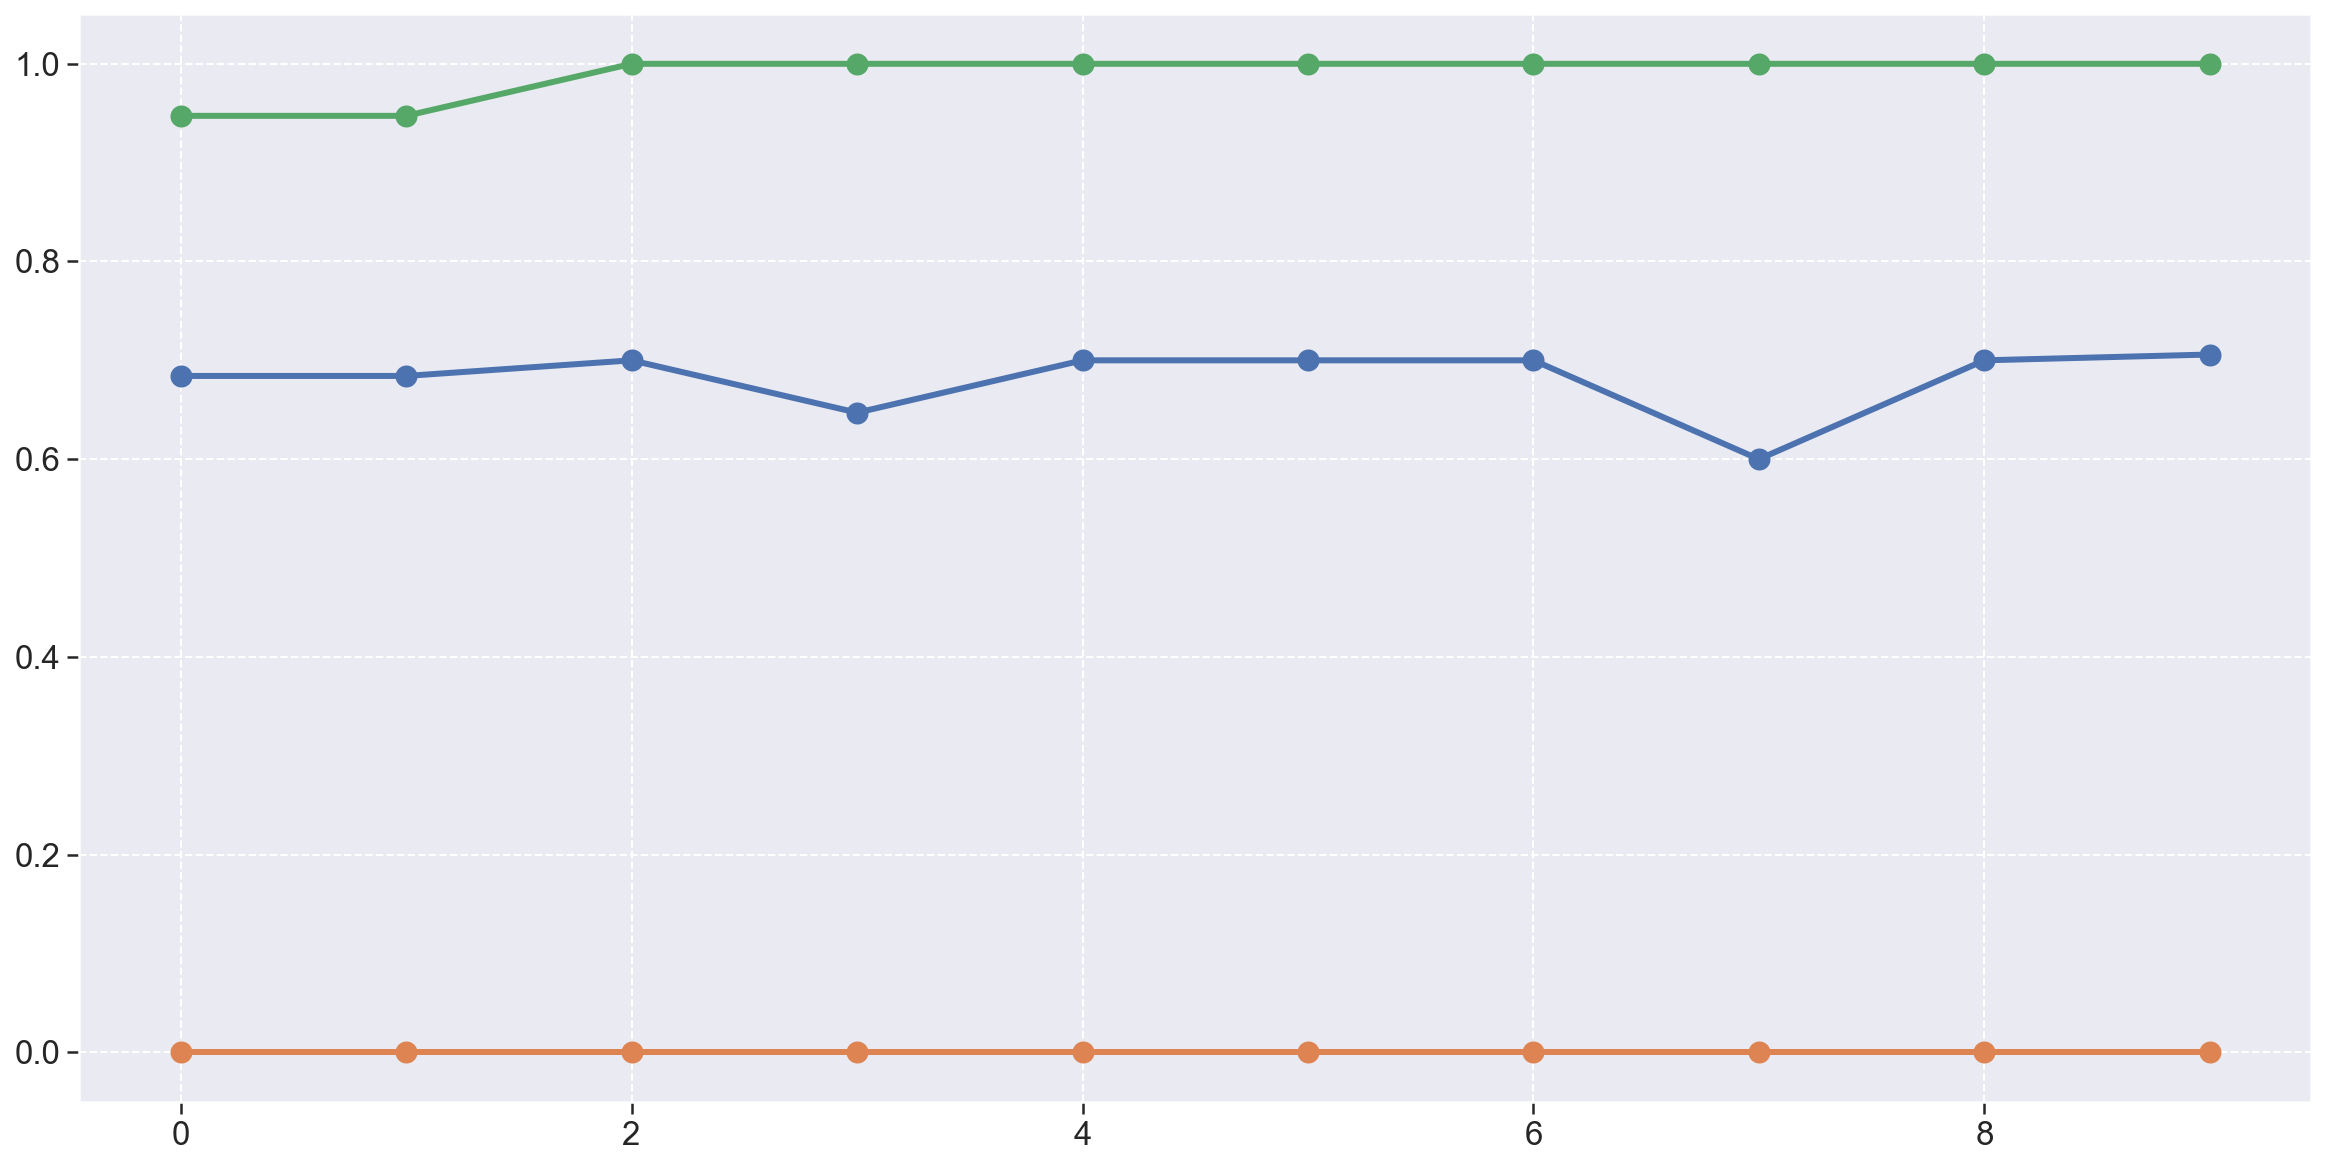

In [40]:
fig = plt.figure(figsize=(20, 10))

plt.plot(demands_metrics['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(demands_metrics['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(demands_metrics['m3'], linewidth=3, marker='o', markersize=10)


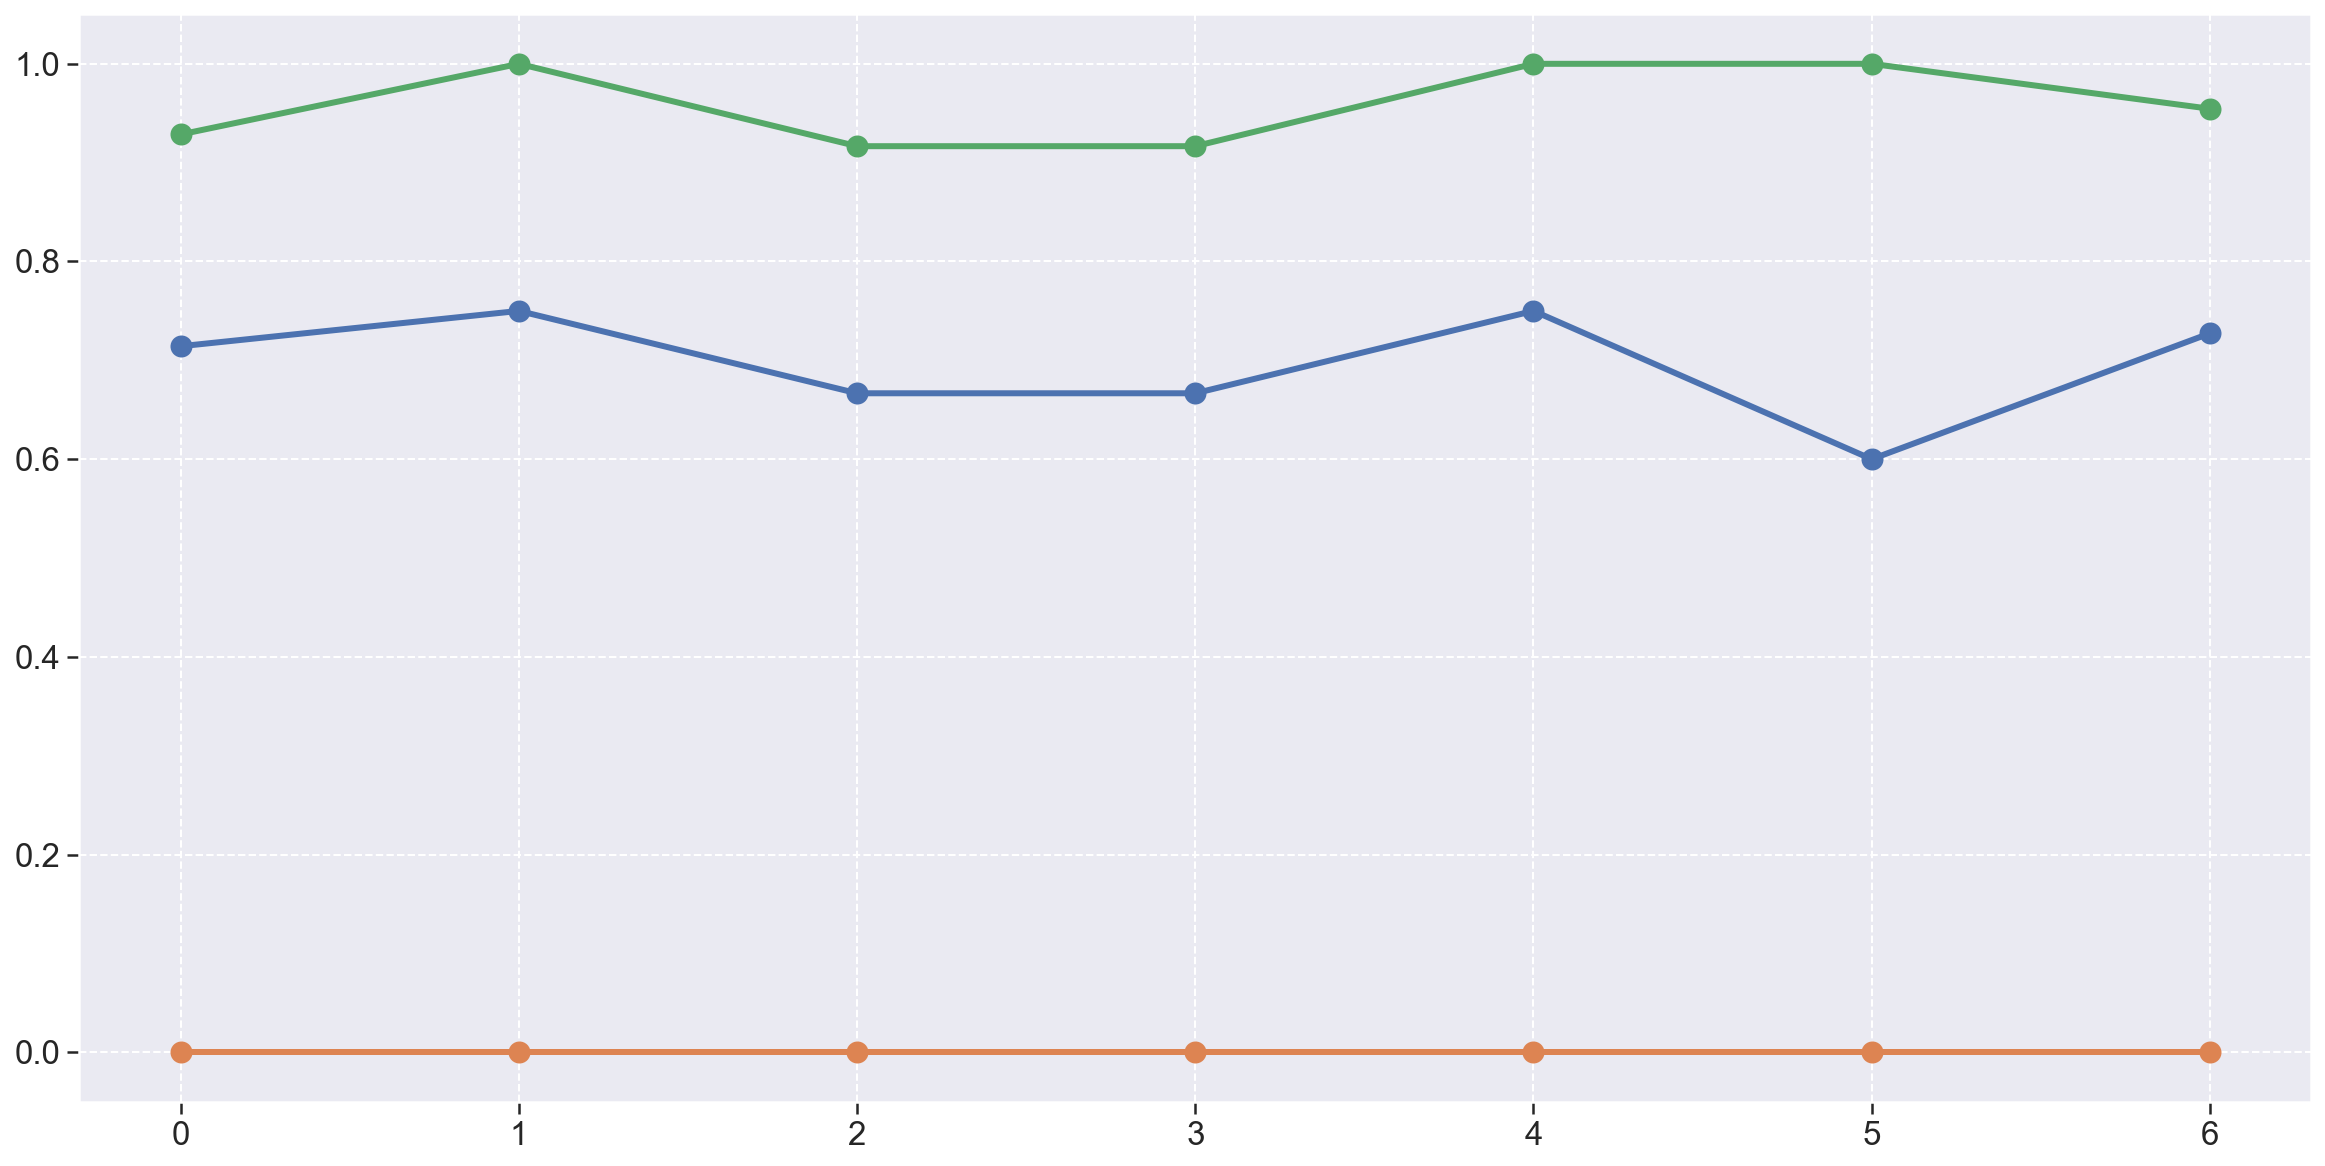

In [41]:
fig = plt.figure(figsize=(20, 10))

plt.plot(clients_metrics['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(clients_metrics['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(clients_metrics['m3'], linewidth=3, marker='o', markersize=10)

### Sub characteristic aggregation

- You must do this for each of your repositories

In [42]:
users_metrics = create_metrics_df(users_df)
sectors_metrics = create_metrics_df(sectors_df)
frontend_metrics = create_metrics_df(frontend_df)
demands_metrics = create_metrics_df(demands_df)
clients_metrics = create_metrics_df(clients_df)

psc1 = 1
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33

users_metrics['asc1'] = ((users_metrics['m1']*pm1)+(users_metrics['m2']*pm2)+(users_metrics['m3']*pm3))*psc1
sectors_metrics['asc1'] = ((sectors_metrics['m1']*pm1)+(sectors_metrics['m2']*pm2)+(sectors_metrics['m3']*pm3))*psc1
frontend_metrics['asc1'] = ((frontend_metrics['m1']*pm1)+(frontend_metrics['m2']*pm2)+(frontend_metrics['m3']*pm3))*psc1
demands_metrics['asc1'] = ((demands_metrics['m1']*pm1)+(demands_metrics['m2']*pm2)+(demands_metrics['m3']*pm3))*psc1
clients_metrics['asc1'] = ((clients_metrics['m1']*pm1)+(clients_metrics['m2']*pm2)+(clients_metrics['m3']*pm3))*psc1

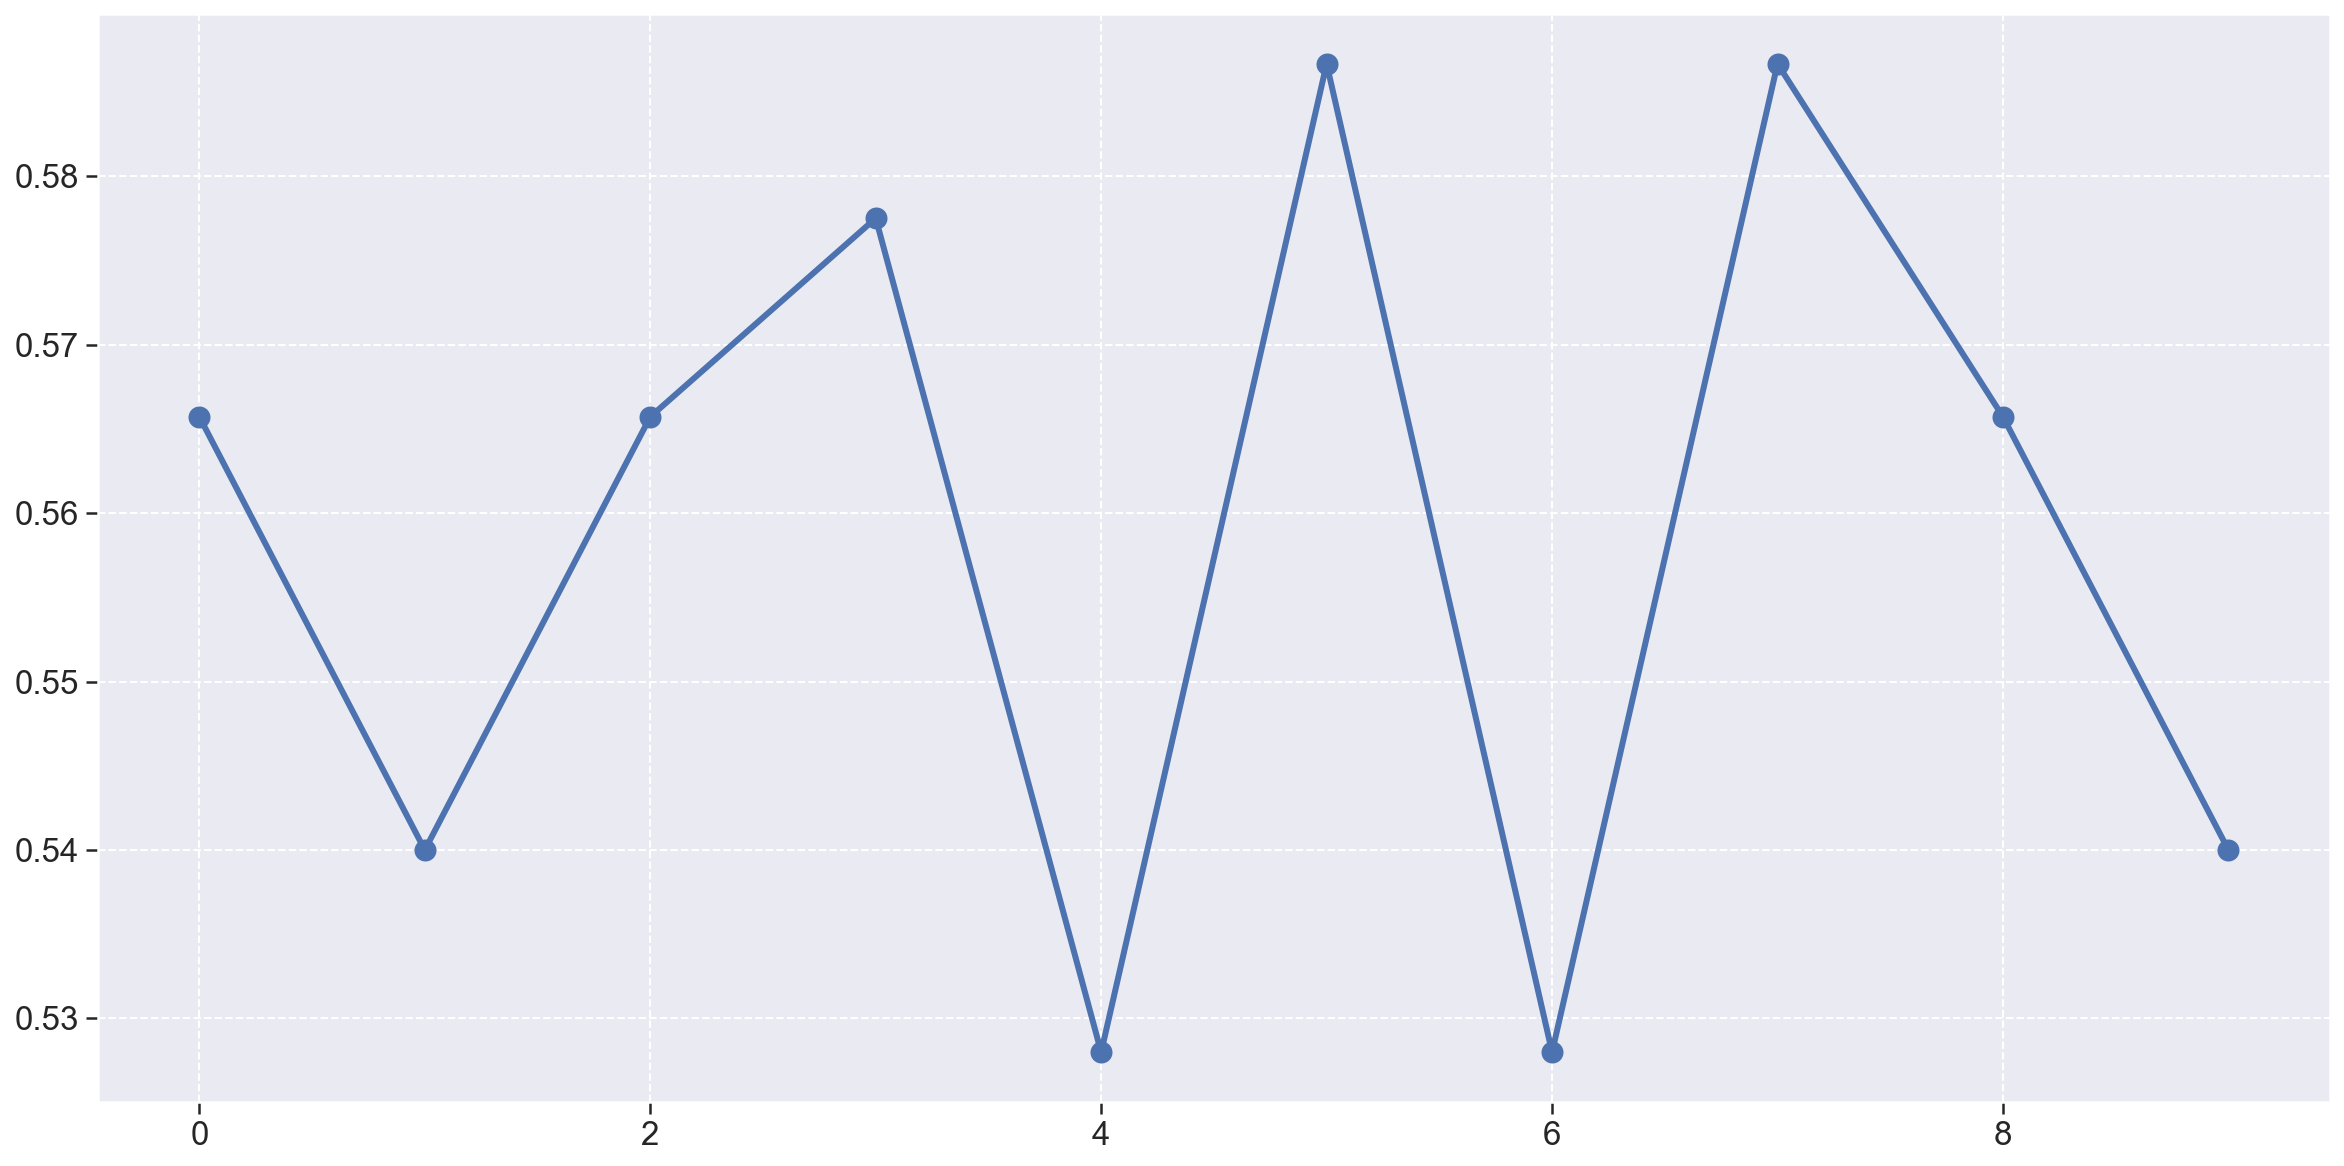

In [43]:
fig = plt.figure(figsize=(20, 10))

plt.plot(users_metrics['asc1'], linewidth=3, marker='o', markersize=10)

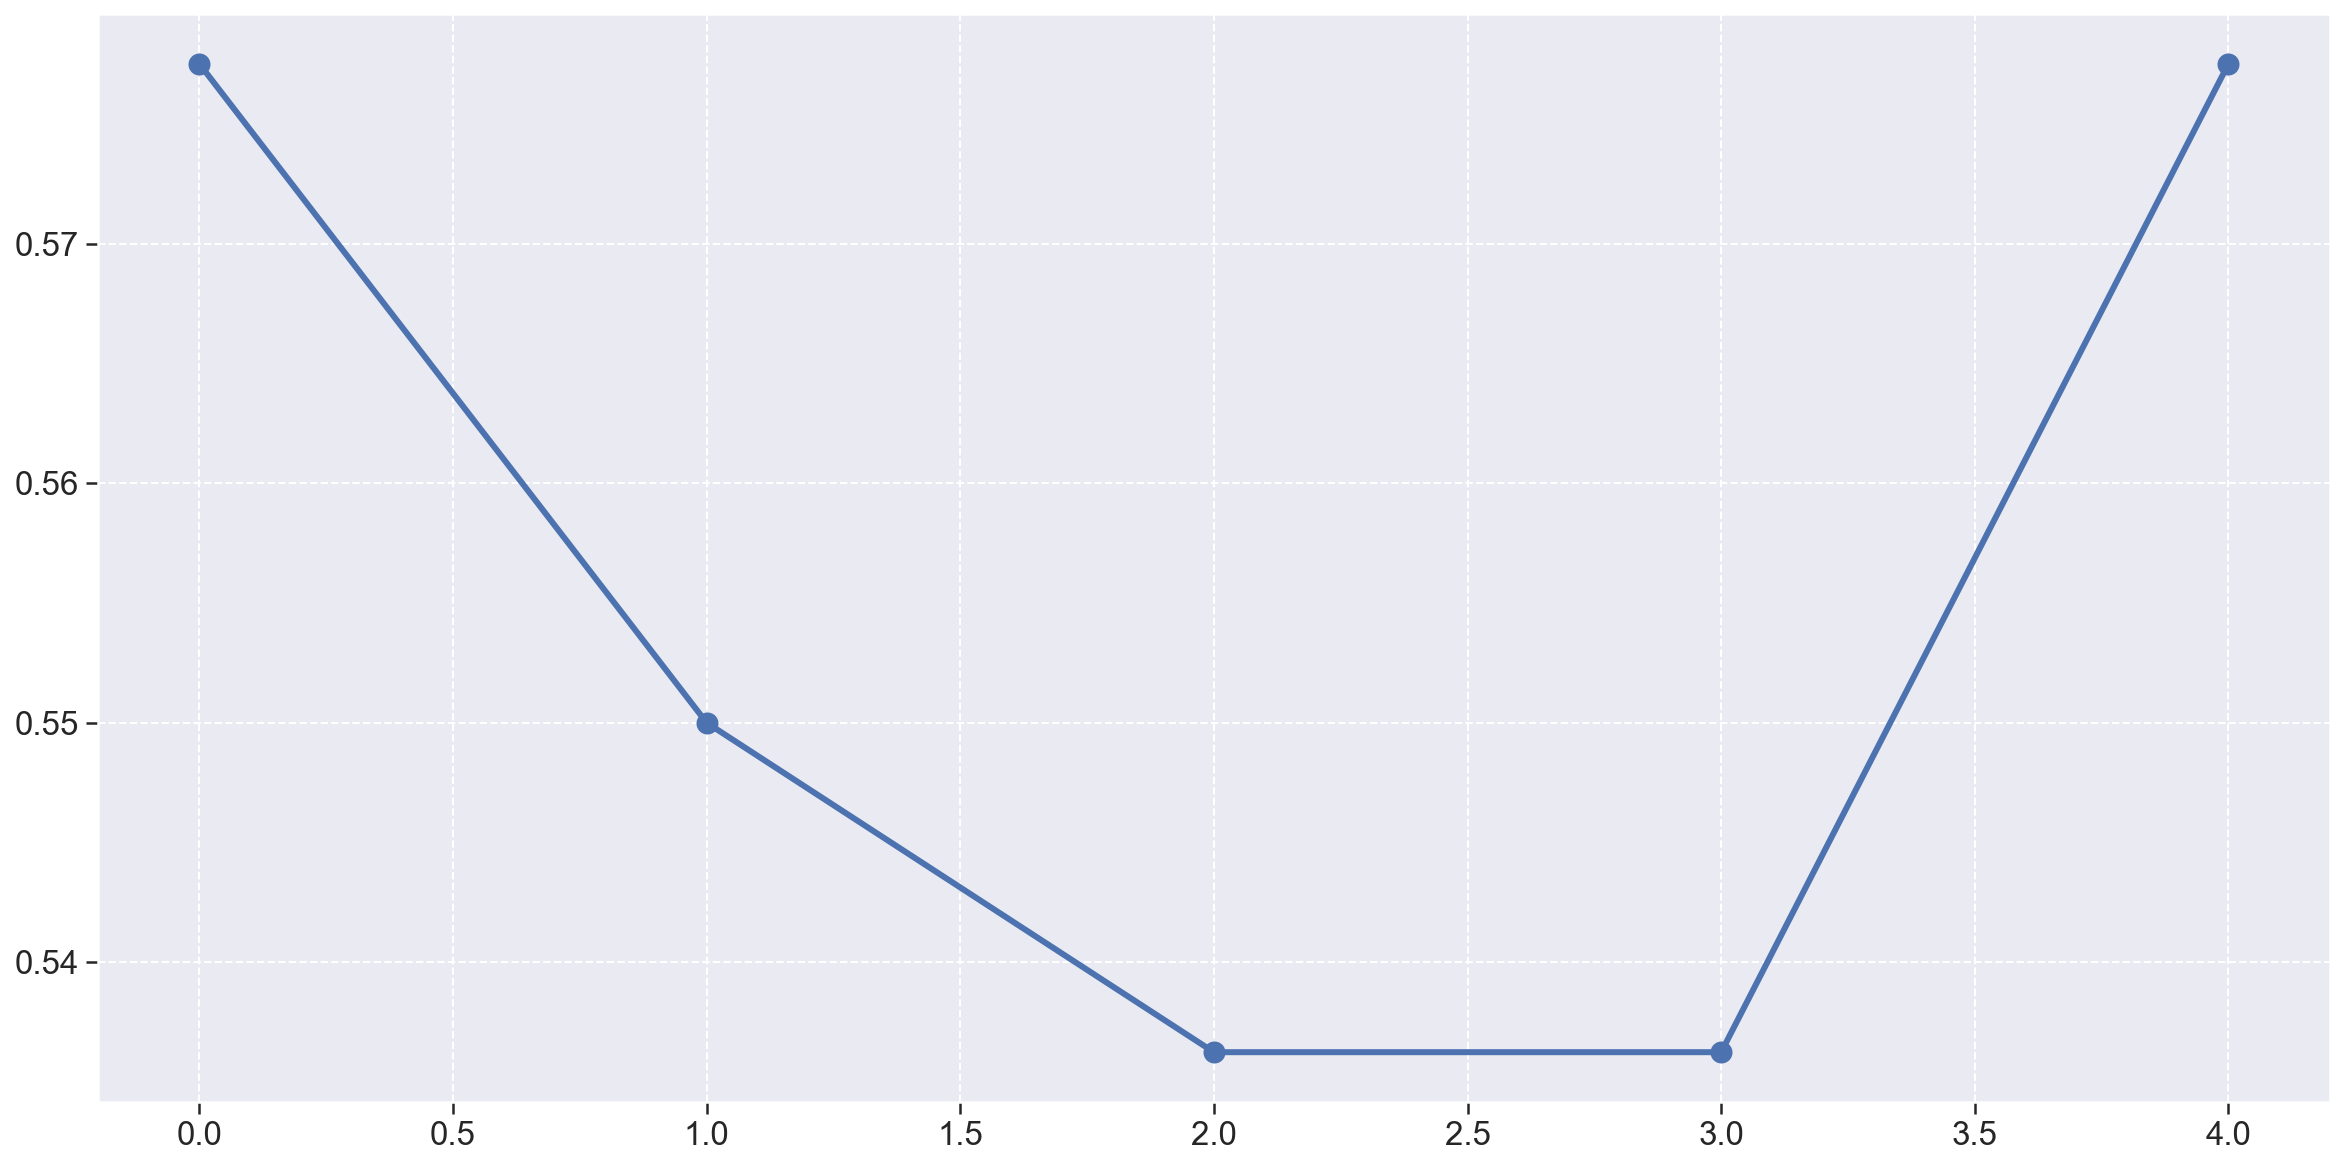

In [44]:
fig = plt.figure(figsize=(20, 10))

plt.plot(sectors_metrics['asc1'], linewidth=3, marker='o', markersize=10)

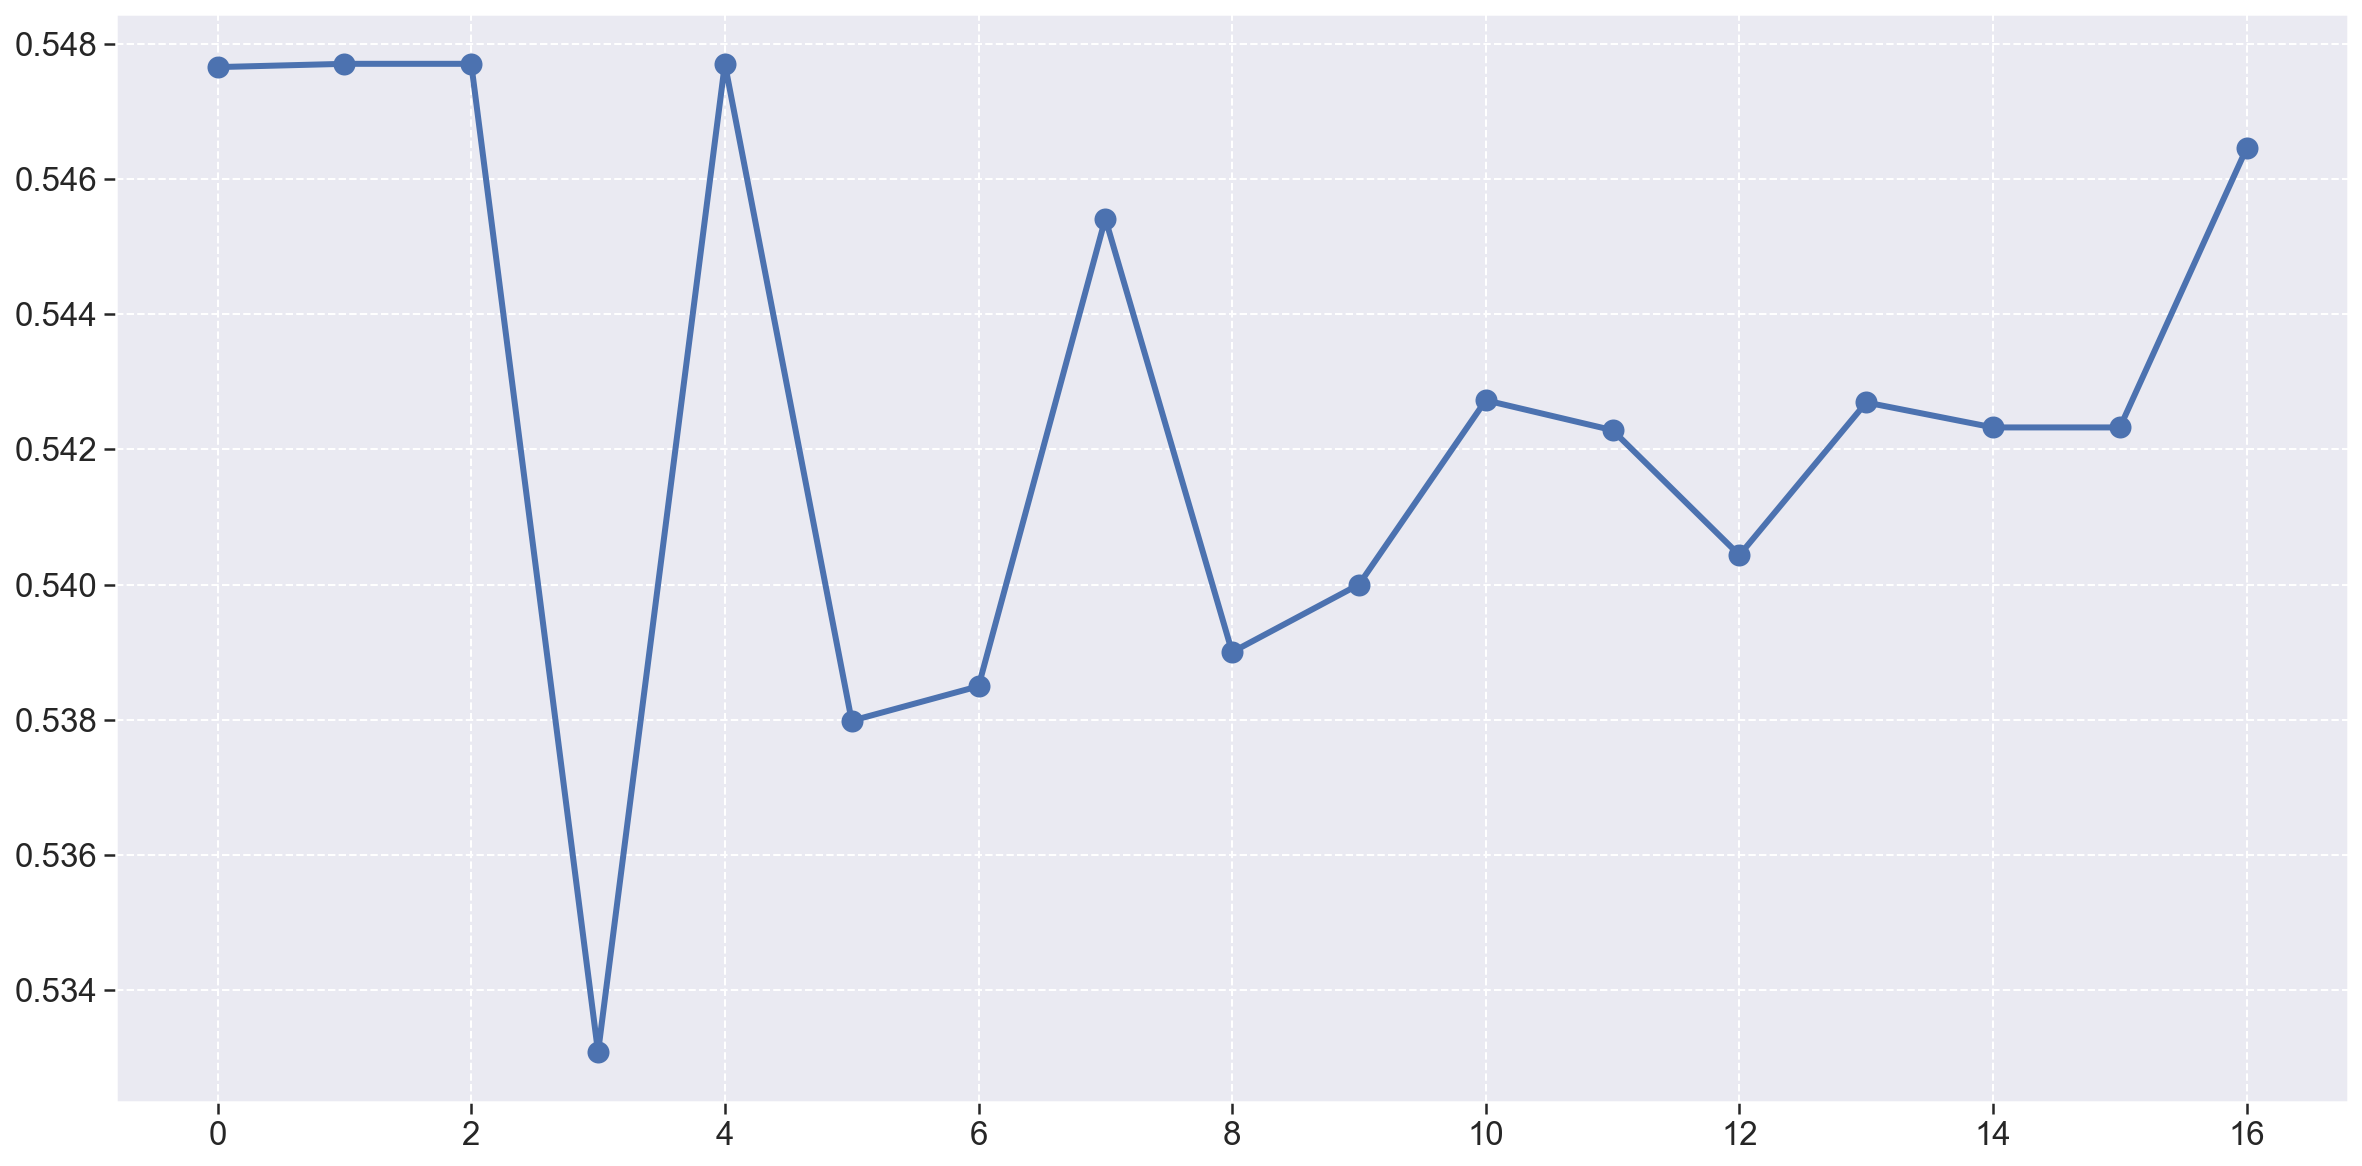

In [45]:
fig = plt.figure(figsize=(20, 10))

plt.plot(frontend_metrics['asc1'], linewidth=3, marker='o', markersize=10)

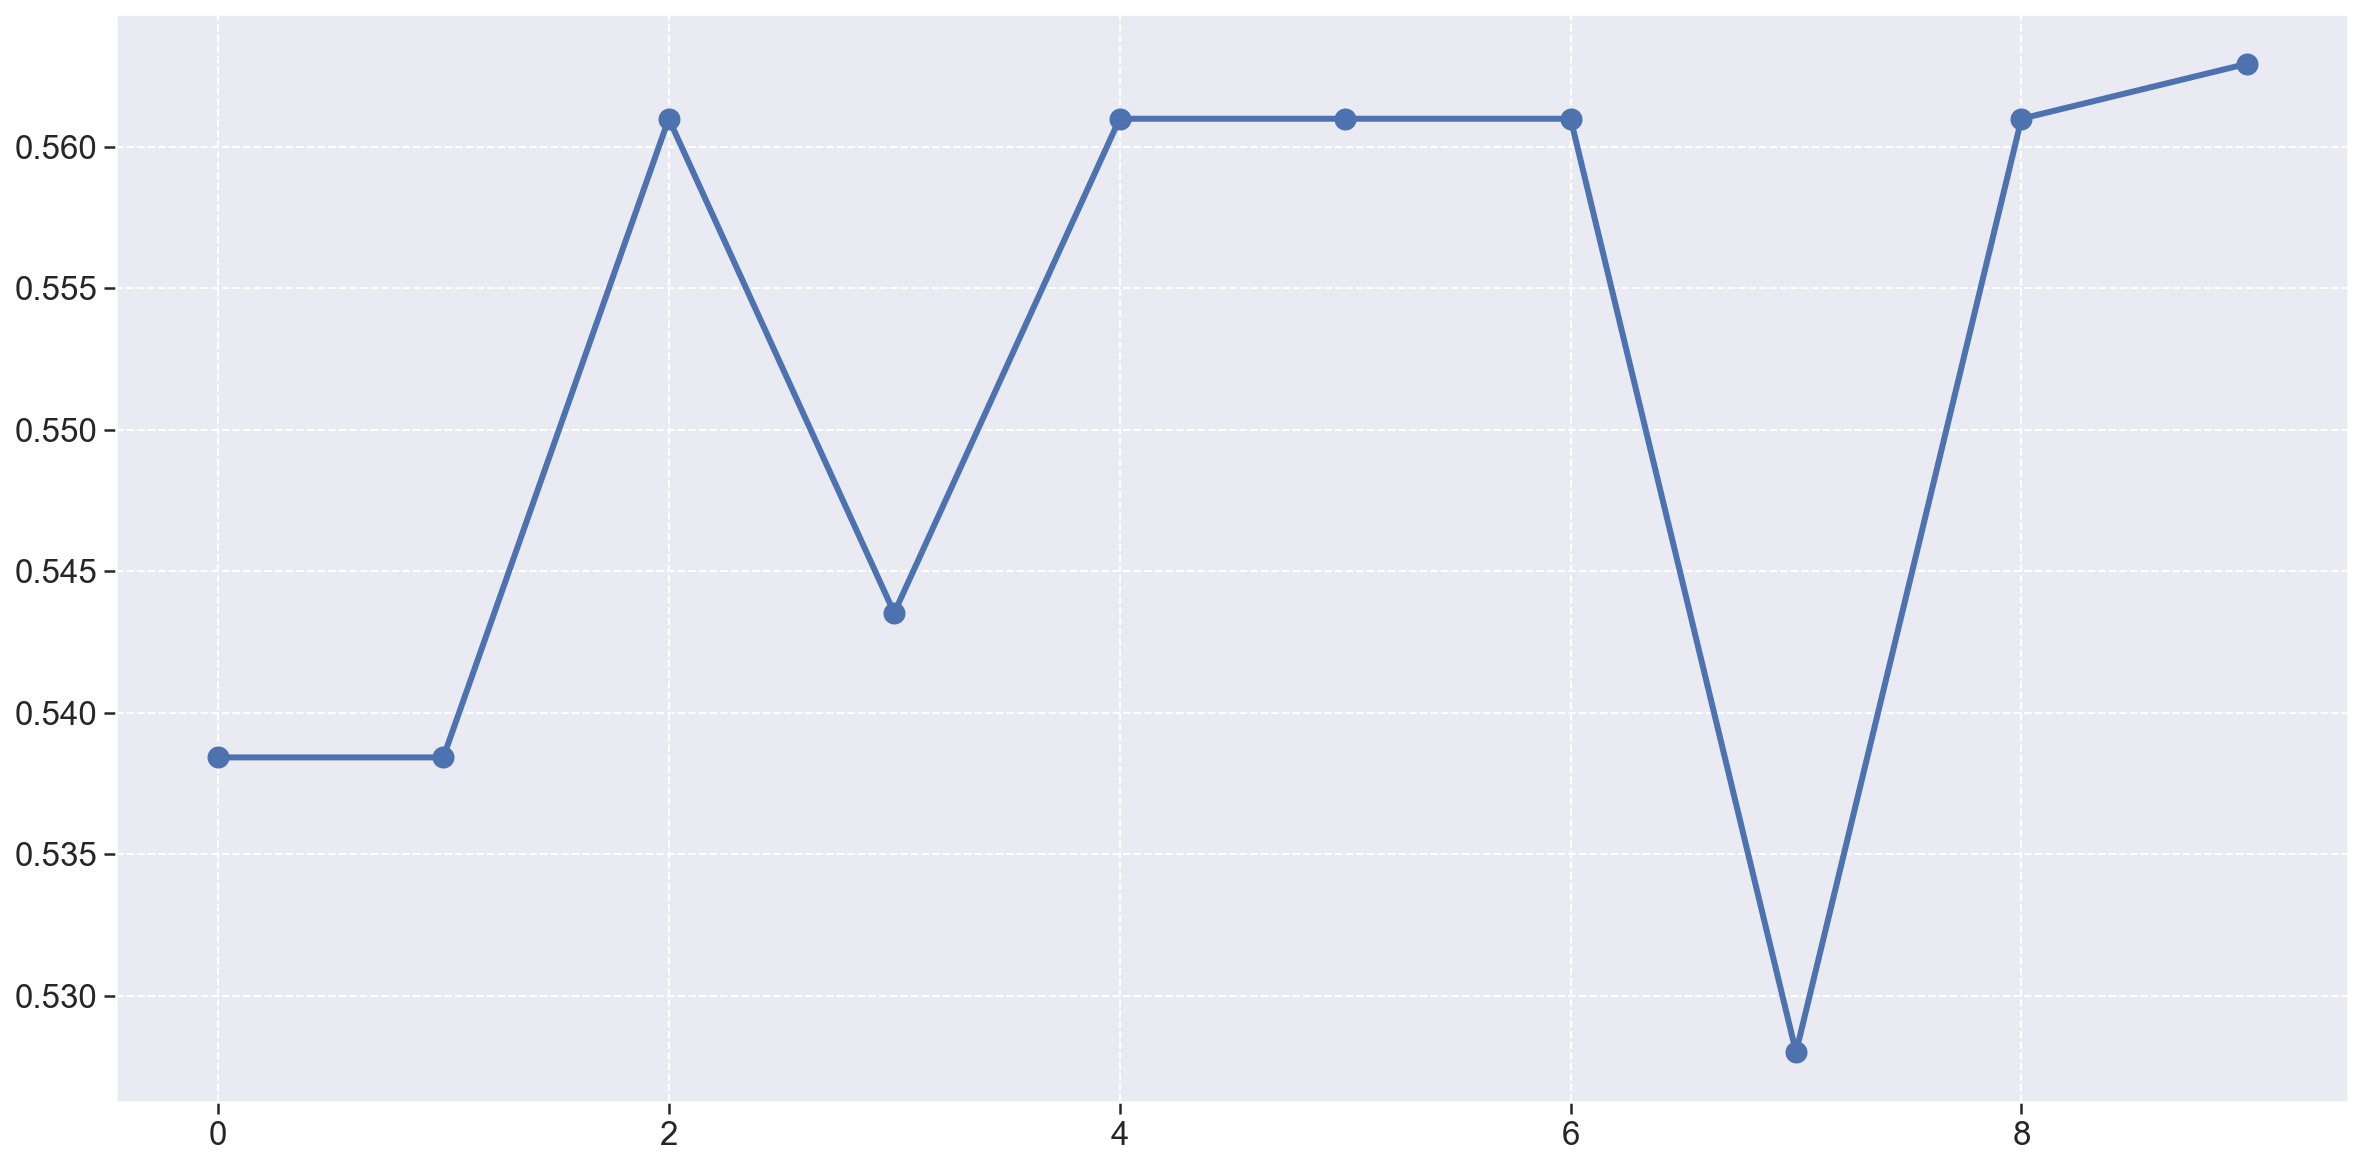

In [46]:
fig = plt.figure(figsize=(20, 10))

plt.plot(demands_metrics['asc1'], linewidth=3, marker='o', markersize=10)

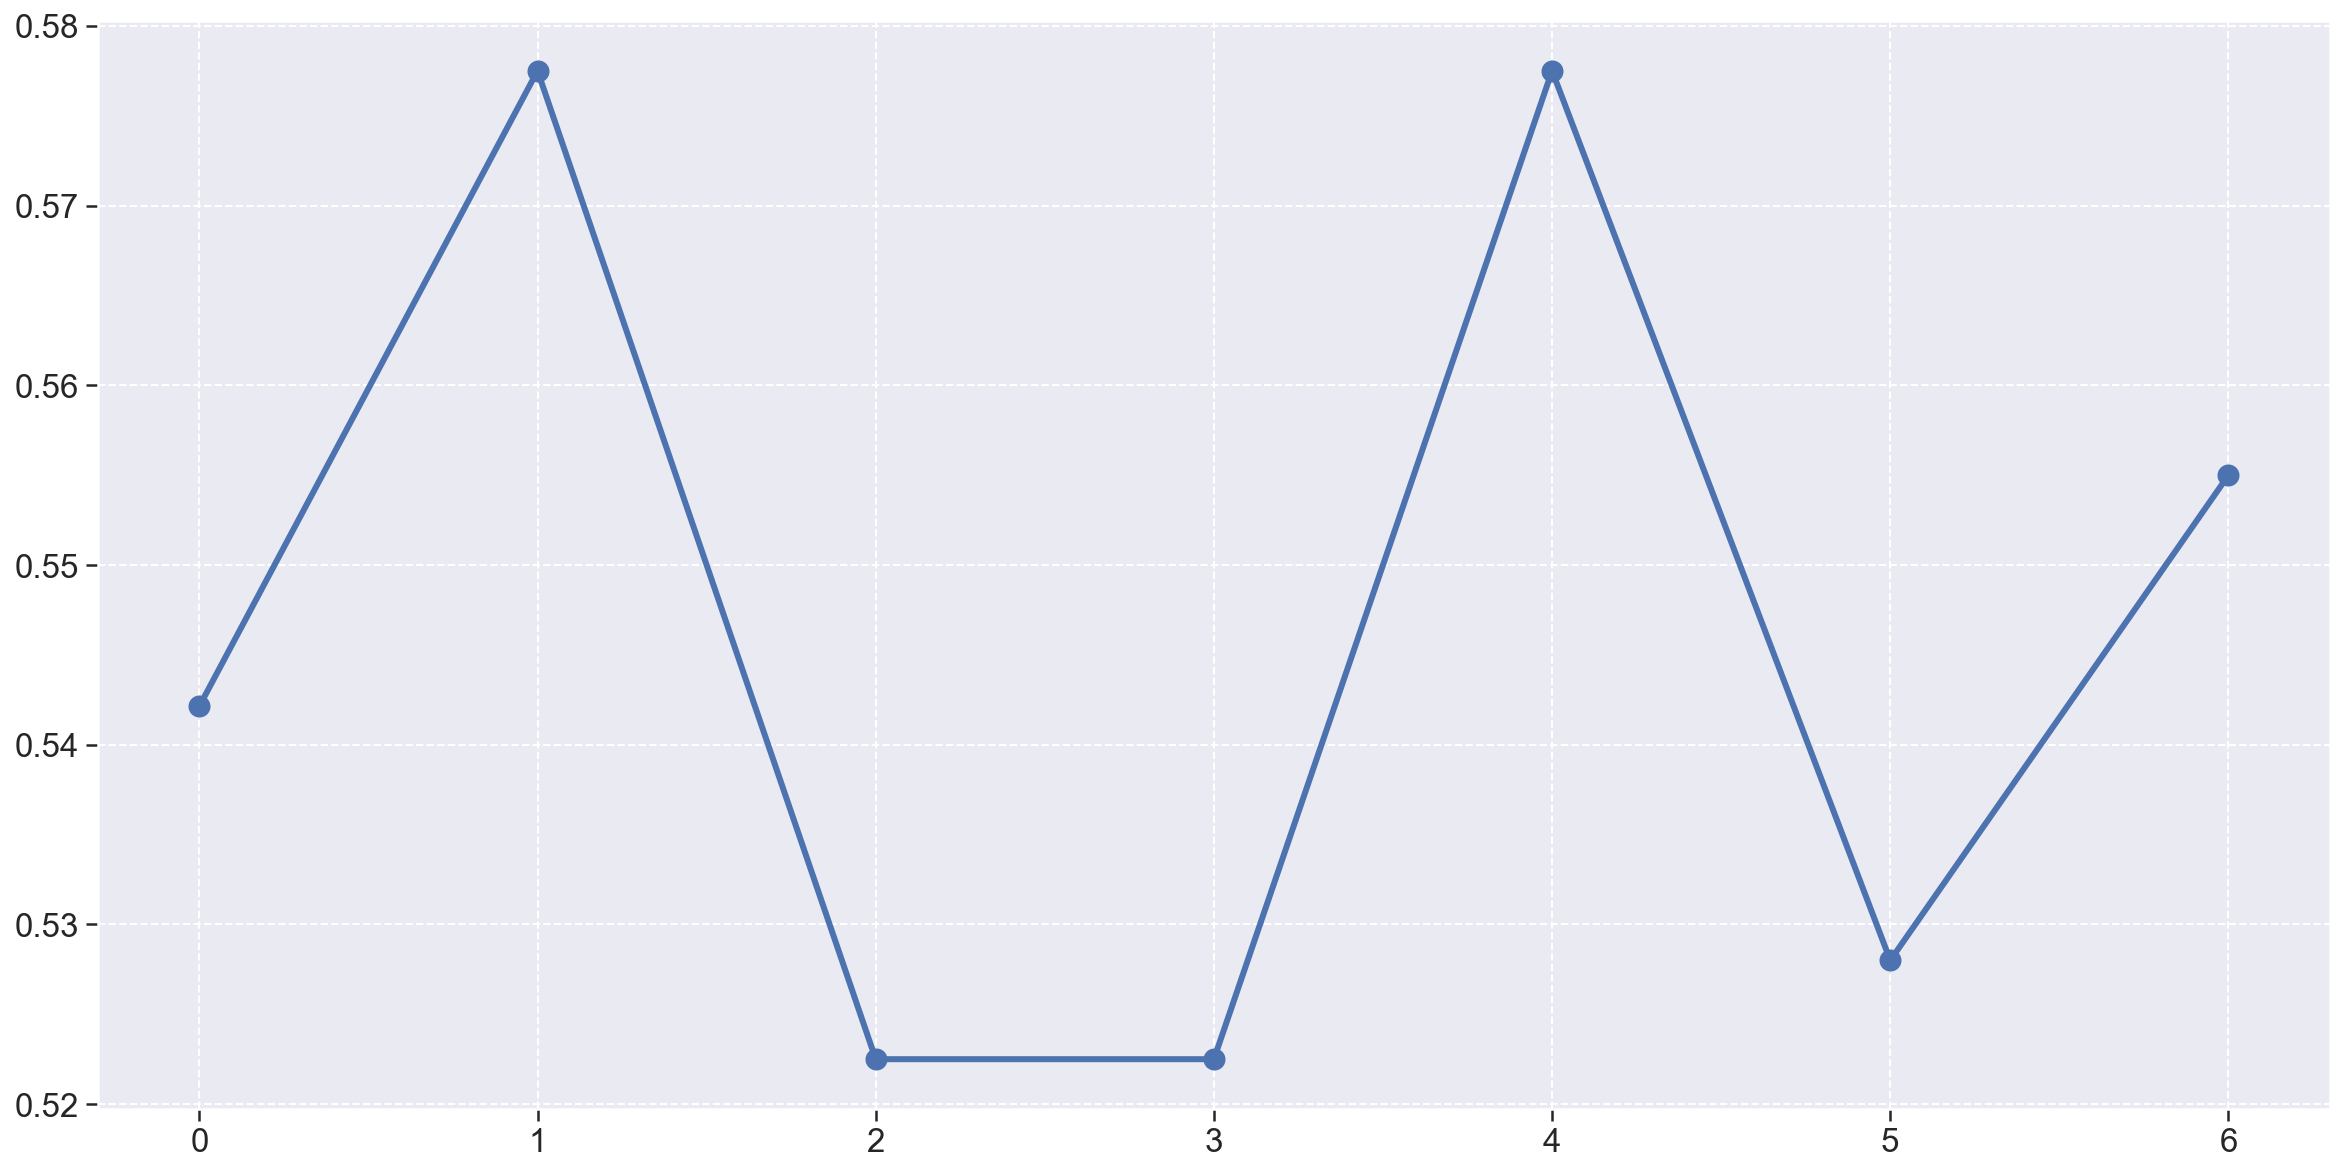

In [47]:
fig = plt.figure(figsize=(20, 10))

plt.plot(clients_metrics['asc1'], linewidth=3, marker='o', markersize=10)

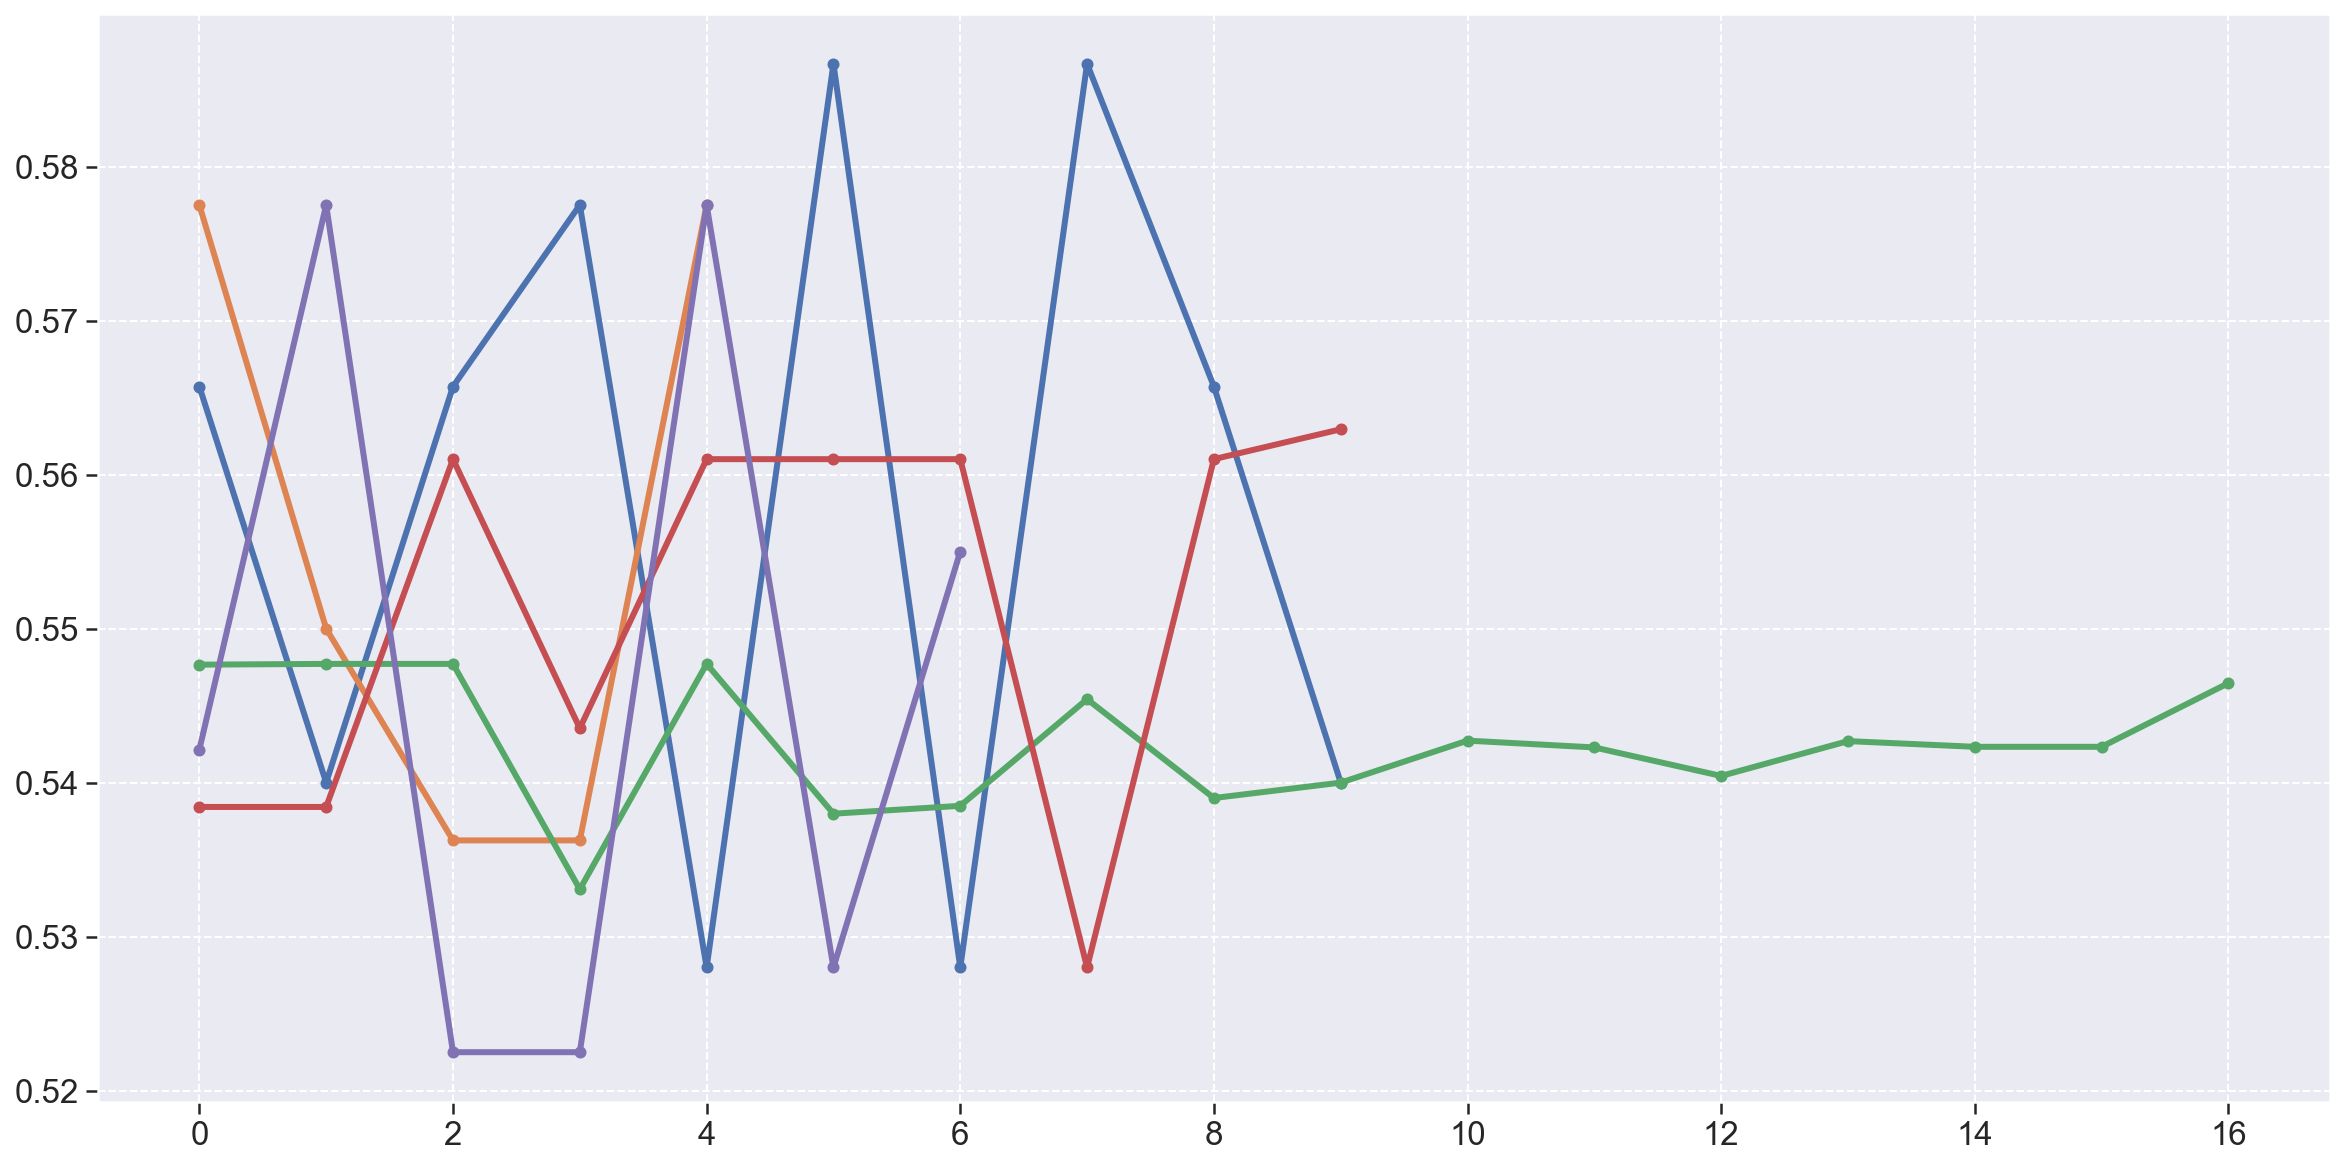

In [48]:
fig = plt.figure(figsize=(20, 10))


plt.plot(users_metrics['asc1'], linewidth=3, marker='o', markersize=5)
plt.plot(sectors_metrics['asc1'], linewidth=3, marker='o', markersize=5)
plt.plot(frontend_metrics['asc1'], linewidth=3, marker='o', markersize=5)
plt.plot(demands_metrics['asc1'], linewidth=3, marker='o', markersize=5)
plt.plot(clients_metrics['asc1'], linewidth=3, marker='o', markersize=5)

In [52]:
metrics_df = pd.concat([users_metrics, sectors_metrics, frontend_metrics, demands_metrics, clients_metrics], ignore_index=True)

metrics_df['ac1'] = metrics_df['asc1'] * 1
metrics_df['totalAC1'] = metrics_df['asc1'] * 0.5

In [53]:
metrics_df

,m1,m2,m3,repository,version,ncloc,asc1,ac1,totalAC1
0,0.714286,0.000000,1.000000,Users,04-04-2021,33.285714,0.565714,0.565714,0.282857
1,0.636364,0.000000,1.000000,Users,04-05-2021,56.909091,0.540000,0.540000,0.270000
2,0.714286,0.000000,1.000000,Users,13-04-2021,33.571429,0.565714,0.565714,0.282857
3,0.750000,0.000000,1.000000,Users,14-04-2021,37.000000,0.577500,0.577500,0.288750
4,0.600000,0.000000,1.000000,Users,14-05-2021,37.500000,0.528000,0.528000,0.264000
5,0.777778,0.000000,1.000000,Users,16-04-2021,33.222222,0.586667,0.586667,0.293333
6,0.600000,0.000000,1.000000,Users,16-05-2021,37.500000,0.528000,0.528000,0.264000
7,0.777778,0.000000,1.000000,Users,20-04-2021,33.222222,0.586667,0.586667,0.293333
8,0.714286,0.000000,1.000000,Users,23-03-2021,33.285714,0.565714,0.565714,0.282857
9,0.636364,0.000000,1.000000,Users,30-04-2021,56.909091,0.540000,0.540000,0.270000


In [54]:
now = datetime.now()
now_str = now.strftime("%d-%m-%Y-%H-%M")

metrics_df.to_csv('data/fga-eps-mds-2020-2-SiGeD-qualidade-total-produto-{}.csv'.format(now_str), index = False)